#### importing data and files

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt
import statsmodels.api as sm
import scipy.stats as st
import re
import math
import collections
from matplotlib import rcParams
from matplotlib import gridspec
from pandas_profiling import ProfileReport
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from collections import Counter
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import chisquare
%matplotlib inline

# chargement des données
from google.colab import drive
drive.mount("/content/drive")

# dataframes
tr = pd.read_csv("/content/drive/MyDrive/OC/P4/P4_official_files/dataset_P4/transactions.csv")
pr = pd.read_csv("/content/drive/MyDrive/OC/P4/P4_official_files/dataset_P4/products.csv")
cl = pd.read_csv("/content/drive/MyDrive/OC/P4/P4_official_files/dataset_P4/customers.csv")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Part 1 -- Data cleaning

## Customers table

#### Checking file and dropping unecessary data

In [ ]:
# quick overview of the file
cl.head()

client_id sex  birth
0    c_4410   f   1967
1    c_7839   f   1975
2    c_1699   f   1984
3    c_5961   f   1962
4    c_5320   m   1943

In [ ]:
# checking data info
cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


In [ ]:
# searching if there are null values
cl[cl.isnull().any(axis=1)]

Empty DataFrame
Columns: [client_id, sex, birth]
Index: []

In [ ]:
# detecting possible "anomalie"
cl.sort_values(by = "client_id", ascending=True).tail()

# ct_0 and ct_1 seems to be "test values"

client_id sex  birth
94       c_997   f   1994
2145     c_998   m   2001
7358     c_999   m   1964
2735      ct_0   f   2001
8494      ct_1   m   2001

In [ ]:
# locating the "test" clients
print(f'THESE ARE THE "TEST" CUSTOMERS: \n\n{cl.loc[cl["client_id"].str.contains("ct", case=False)]}\n\nHence we have to drop it from the table...\n------------------------------------------\n')

# dropping them from the table
cl.drop([2735, 8494], inplace=True)
cl.loc[cl["client_id"].str.contains("ct", case=False)]

THESE ARE THE "TEST" CUSTOMERS: 

     client_id sex  birth
2735      ct_0   f   2001
8494      ct_1   m   2001

Hence we have to drop it from the table...
------------------------------------------



Empty DataFrame
Columns: [client_id, sex, birth]
Index: []

In [ ]:
# last overview
cl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8621 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8621 non-null   object
 1   sex        8621 non-null   object
 2   birth      8621 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 269.4+ KB


#### Adding a new column for customer's Age

In [ ]:
# we will drop the "birth" column as well, since we won't be needing it anymore
cl["age"] = 2022 - cl["birth"]
cl.drop(columns=["birth"], inplace=True)
cl.head()

client_id sex  age
0    c_4410   f   55
1    c_7839   f   47
2    c_1699   f   38
3    c_5961   f   60
4    c_5320   m   79

## Products table

#### Checking file and dropping unecessary data

In [ ]:
# quick overview of the file
pr.head()

id_prod  price  categ
0  0_1421  19.99      0
1  0_1368   5.13      0
2   0_731  17.99      0
3   1_587   4.99      1
4  0_1507   3.99      0

In [ ]:
# checking data info
pr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


In [ ]:
# searching if there are null values
pr[pr.isnull().any(axis=1)]

Empty DataFrame
Columns: [id_prod, price, categ]
Index: []

In [ ]:
# detecting possible "anomalie"
pr.sort_values(by = "price", ascending=True).head()

# T_0 seems to be a "test value"

id_prod  price  categ
731      T_0  -1.00      0
2355   0_202   0.62      0
2272   0_528   0.62      0
370    0_120   0.66      0
1211  0_1844   0.77      0

In [ ]:
# locating the "test" product
print(f'THIS IS THE "TEST" PRODUCT: \n\n{pr.loc[pr["id_prod"] == "T_0"]}\n\nThus we have to drop it from the table...\n------------------------------------------\n')

# dropping them from the table
pr.drop(pr[pr["id_prod"] == "T_0"].index, inplace=True)

# let's verify if well executed
print(f'Index 731 cannot be found,\nwe successfully dropped the unecessary data\n\n{pr.loc[pr["id_prod"] == "T_0"]}\n\n------------------------------------------\n')
pr.sort_values(by = "price", ascending=True).head()

THIS IS THE "TEST" PRODUCT: 

    id_prod  price  categ
731     T_0   -1.0      0

Thus we have to drop it from the table...
------------------------------------------

Index 731 cannot be found,
we successfully dropped the unecessary data

Empty DataFrame
Columns: [id_prod, price, categ]
Index: []

------------------------------------------



id_prod  price  categ
2272   0_528   0.62      0
2355   0_202   0.62      0
370    0_120   0.66      0
1211  0_1844   0.77      0
1530  0_1620   0.80      0

In [ ]:
# last overview
pr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3286 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3286 non-null   object 
 1   price    3286 non-null   float64
 2   categ    3286 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 102.7+ KB


## Transactions table

#### Checking file and dropping unecessary data

In [ ]:
# quick overview of the file
tr.head()

id_prod                        date session_id client_id
0  0_1483  2021-04-10 18:37:28.723910    s_18746    c_4450
1   2_226  2022-02-03 01:55:53.276402   s_159142     c_277
2   1_374  2021-09-23 15:13:46.938559    s_94290    c_4270
3  0_2186  2021-10-17 03:27:18.783634   s_105936    c_4597
4  0_1351  2021-07-17 20:34:25.800563    s_63642    c_1242

In [ ]:
# checking data info
tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337016 entries, 0 to 337015
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     337016 non-null  object
 1   date        337016 non-null  object
 2   session_id  337016 non-null  object
 3   client_id   337016 non-null  object
dtypes: object(4)
memory usage: 10.3+ MB


In [ ]:
# searching if there are null values
tr[tr.isnull().any(axis=1)]

Empty DataFrame
Columns: [id_prod, date, session_id, client_id]
Index: []

In [ ]:
# detecting possible "anomalie"
tr.sort_values(by = "id_prod", ascending=False).head()

# T_0 seems to be a "test value"
# T_0 has client_id ct_0 and ct_1 who were mentioned as "tests values" previously

id_prod                             date session_id client_id
210294     T_0  test_2021-03-01 02:30:02.237432        s_0      ct_0
75176      T_0  test_2021-03-01 02:30:02.237443        s_0      ct_1
203418     T_0  test_2021-03-01 02:30:02.237449        s_0      ct_0
259192     T_0  test_2021-03-01 02:30:02.237444        s_0      ct_0
234706     T_0  test_2021-03-01 02:30:02.237441        s_0      ct_1

In [ ]:
# locating the "test" product in Transactions
print(f'THERE ARE {len(tr.loc[tr["id_prod"] == "T_0"])} "TEST" VALUES FOUND IN TRANSACTIONS: \n\n{tr.loc[tr["id_prod"] == "T_0"]}\n\nThen, we have to drop them from the table...\n------------------------------------------\n')

# dropping them from the table
tr.drop(tr[tr["id_prod"] == "T_0"].index, inplace=True)
tr.loc[tr["id_prod"] == "T_0"]

THERE ARE 200 "TEST" VALUES FOUND IN TRANSACTIONS: 

       id_prod                             date session_id client_id
1431       T_0  test_2021-03-01 02:30:02.237420        s_0      ct_1
2365       T_0  test_2021-03-01 02:30:02.237446        s_0      ct_1
2895       T_0  test_2021-03-01 02:30:02.237414        s_0      ct_1
5955       T_0  test_2021-03-01 02:30:02.237441        s_0      ct_0
7283       T_0  test_2021-03-01 02:30:02.237434        s_0      ct_1
...        ...                              ...        ...       ...
332594     T_0  test_2021-03-01 02:30:02.237445        s_0      ct_0
332705     T_0  test_2021-03-01 02:30:02.237423        s_0      ct_1
332730     T_0  test_2021-03-01 02:30:02.237421        s_0      ct_1
333442     T_0  test_2021-03-01 02:30:02.237431        s_0      ct_1
335279     T_0  test_2021-03-01 02:30:02.237430        s_0      ct_0

[200 rows x 4 columns]

Then, we have to drop them from the table...
------------------------------------------



Empty DataFrame
Columns: [id_prod, date, session_id, client_id]
Index: []

In [ ]:
# last overview
tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336816 entries, 0 to 337015
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     336816 non-null  object
 1   date        336816 non-null  object
 2   session_id  336816 non-null  object
 3   client_id   336816 non-null  object
dtypes: object(4)
memory usage: 12.8+ MB


#### Fixing the date type

In [ ]:
tr

id_prod                        date session_id client_id
0       0_1483  2021-04-10 18:37:28.723910    s_18746    c_4450
1        2_226  2022-02-03 01:55:53.276402   s_159142     c_277
2        1_374  2021-09-23 15:13:46.938559    s_94290    c_4270
3       0_2186  2021-10-17 03:27:18.783634   s_105936    c_4597
4       0_1351  2021-07-17 20:34:25.800563    s_63642    c_1242
...        ...                         ...        ...       ...
337011   1_671  2021-05-28 12:35:46.214839    s_40720    c_3454
337012   0_759  2021-06-19 00:19:23.917703    s_50568    c_6268
337013  0_1256  2021-03-16 17:31:59.442007     s_7219    c_4137
337014   2_227  2021-10-30 16:50:15.997750   s_112349       c_5
337015  0_1417  2021-06-26 14:38:19.732946    s_54117    c_6714

[336816 rows x 4 columns]

In [ ]:
tr["full_time"] = tr["date"]

In [ ]:
# getting rid of microseconds:
def date_claire(date):
    return(date.split(".")[0])

tr["date"] = tr["date"].apply(date_claire)
tr.head(1)

id_prod                 date session_id client_id                   full_time
0  0_1483  2021-04-10 18:37:28    s_18746    c_4450  2021-04-10 18:37:28.723910

In [ ]:
# let's rename the "date" column to "date_and_time" then convert it to datetime:
tr.rename(columns={"date": "date_and_time"}, inplace=True)
tr["date_and_time"] = pd.to_datetime(tr["date_and_time"])
tr["full_time"] = pd.to_datetime(tr["full_time"])
tr.head(1)

id_prod       date_and_time session_id client_id                  full_time
0  0_1483 2021-04-10 18:37:28    s_18746    c_4450 2021-04-10 18:37:28.723910

In [ ]:
tr.dtypes

id_prod                  object
date_and_time    datetime64[ns]
session_id               object
client_id                object
full_time        datetime64[ns]
dtype: object

In [ ]:
# splitting the date into multiple categories:
# day
# day number
# month name
# month number
# year
# quarterly

tr.loc[:, "date_and_time"] = pd.to_datetime(tr.loc[:, "date_and_time"], errors="coerce")

tr["month"] = tr["date_and_time"].dt.strftime("%B")
tr["day"] = tr["date_and_time"].map(lambda d: d.day)
tr["year"] = tr["date_and_time"].map(lambda d: d.year)

tr["quarterly"] = [int((day-1)*4/31)+1 for day in tr["day"]]
tr["_monthnum"] = tr["date_and_time"].map(lambda d: d.month)
tr["_daynum"] = tr["date_and_time"].map(lambda d: d.weekday()+1)

tr["day_name"] = tr["_daynum"].map({1:str("Monday"), 2:str("Tuesday"), 3:str("Wednesday"), 4:str("Thursday"), 5:str("Friday"), 6:str("Saturday"), 7:str("Sunday")})

tr.head(2)

id_prod       date_and_time session_id  ... _monthnum _daynum  day_name
0  0_1483 2021-04-10 18:37:28    s_18746  ...         4       6  Saturday
1   2_226 2022-02-03 01:55:53   s_159142  ...         2       4  Thursday

[2 rows x 12 columns]

In [ ]:
# the date_and_time to datetime conversion will let us apply get_date() and get_hour()
# this will give us separate columns for date and for hour
def get_date(dh):
    return(dh.date());
tr["date"] = tr["date_and_time"].apply(get_date)

def get_hour(dh):
    return(dh.time());
tr["hour"] = tr["date_and_time"].apply(get_hour)

# we won't be needing the date_and_time column anymore in this case, so we can drop it
tr.drop(columns="date_and_time", inplace=True)
tr.head(2)

id_prod session_id client_id  ...  day_name        date      hour
0  0_1483    s_18746    c_4450  ...  Saturday  2021-04-10  18:37:28
1   2_226   s_159142     c_277  ...  Thursday  2022-02-03  01:55:53

[2 rows x 13 columns]

# Part 2 -- Data preparation 

### TP table -- Transactions and Products

In [ ]:
# merging Transactions and Products first
tp = pd.merge(tr, pr, on="id_prod", how="left").copy(); tp.head(2)

id_prod session_id client_id  ...      hour  price  categ
0  0_1483    s_18746    c_4450  ...  18:37:28   4.99    0.0
1   2_226   s_159142     c_277  ...  01:55:53  65.75    2.0

[2 rows x 15 columns]

In [ ]:
# summation of total turnover
tp["price"].sum()

5796577.770000001

#### Checking file

In [ ]:
# checking for any possible missing values
tp[tp.isnull().any(axis=1)]

id_prod session_id client_id  ...      hour price  categ
6231    0_2245    s_49705    c_1533  ...  03:03:12   NaN    NaN
10797   0_2245    s_49323    c_7954  ...  05:53:01   NaN    NaN
14045   0_2245   s_124474    c_5120  ...  17:35:59   NaN    NaN
17480   0_2245   s_172304    c_4964  ...  18:08:49   NaN    NaN
21071   0_2245        s_3     c_580  ...  00:09:29   NaN    NaN
...        ...        ...       ...  ...       ...   ...    ...
322523  0_2245    s_16936    c_4167  ...  19:59:19   NaN    NaN
329226  0_2245    s_13738    c_7790  ...  23:29:02   NaN    NaN
330297  0_2245   s_128815    c_6189  ...  14:14:40   NaN    NaN
335331  0_2245    s_26624    c_1595  ...  18:58:47   NaN    NaN
336020  0_2245    s_28235    c_5714  ...  03:35:03   NaN    NaN

[103 rows x 15 columns]

In [ ]:
tp_missing = tp.loc[tp["id_prod"].str.contains("0_224", case=False)].sort_values(by="id_prod")
print(tp_missing.groupby("id_prod")["price"].sum());

# other method
tp_absent = tp[tp.id_prod.isin(pr.id_prod)==False]["id_prod"].unique()[0];
print(f"\nWe notice that id_prod {tp_absent} doesn't have price nor category recorded,\nso we will have to impute its values by using mean")

id_prod
0_224      200.16
0_2240     297.27
0_2241    1000.09
0_2242     127.16
0_2243     809.10
0_2244     853.74
0_2245       0.00
0_2246     648.90
0_2247      20.93
0_2248    1820.94
0_2249       5.98
Name: price, dtype: float64

We notice that id_prod 0_2245 doesn't have price nor category recorded,
so we will have to impute its values by using mean


In [ ]:
# verifying other modalities [monthly]
tp_date_detection = tp.copy()

# sorting relevant values
tp_date_detection.sort_values(by=["month", "day", "categ"], ascending=[True, True, False], inplace=True)
# creation d"un filtre par mois
filt = (tp_date_detection["month"] == "October") & (tp_date_detection["categ"] == 1)

# visulation
print(f"There are no transactions made for Category 1 between October 2 to October 27")
tp_date_detection[filt].groupby(["categ", "month", "day"])[["price"]].sum()


# ---------------------------------------------------------------------------------
# GO BACK HERE!
# enlever octobre de la data set
# trans_prod.drop(trans_prod[trans_prod["month"] == "October"].index, inplace=True)

# verification: tpc.loc[tpc["month"] == "October"] ou
# set(tp.month.unique())

There are no transactions made for Category 1 between October 2 to October 27


price
categ month   day         
1.0   October 1    7003.79
              28   6317.99
              29   6425.18
              30   6753.69
              31   7261.67

#### FIlling missing values of 0_2245

In [ ]:
# Fonction permettant de récupérer le premier chiffre d'un identifiant de produit dans nos données:
def get_categ(car):
    return  int(car.split("_")[0])

# Moyenne des prix aux alentours de 0_224
pr_price = pr.loc[pr["id_prod"].str.contains("0_224", case=False)]
pr_price = pd.DataFrame(pr_price)

mean_price = pr_price["price"].mean()
mean_price = round(mean_price, 2)
print(f"Prix moyen des produits 0_224 à 0_2249 est {mean_price}")

# Remplissage des valeurs nuls
tp["categ"] = tp.id_prod.apply(get_categ)
tp["price"].fillna(mean_price, inplace=True)  #tp["price"].replace(np.nan, mean_price, inplace=True)



# GO BACK HERE!
# tp["is_sold"].fillna(True, inplace=True)      #tp["is_sold"].replace(np.nan, True, inplace=True)

Prix moyen des produits 0_224 à 0_2249 est 10.82


In [ ]:
# let's verify
print(tp.loc[tp["id_prod"].str.contains("0_224", case=False)].groupby("id_prod")["price"].sum())

tp.loc[tp["id_prod"] == tp_absent][["id_prod", "price", "categ"]]

id_prod
0_224      200.16
0_2240     297.27
0_2241    1000.09
0_2242     127.16
0_2243     809.10
0_2244     853.74
0_2245    1114.46
0_2246     648.90
0_2247      20.93
0_2248    1820.94
0_2249       5.98
Name: price, dtype: float64


id_prod  price  categ
6231    0_2245  10.82      0
10797   0_2245  10.82      0
14045   0_2245  10.82      0
17480   0_2245  10.82      0
21071   0_2245  10.82      0
...        ...    ...    ...
322523  0_2245  10.82      0
329226  0_2245  10.82      0
330297  0_2245  10.82      0
335331  0_2245  10.82      0
336020  0_2245  10.82      0

[103 rows x 3 columns]

### TPC table -- TP and Customers

In [ ]:
# creating the final data set to use for the entire analysis
tpc = pd.merge(tp, cl, on="client_id", how="left")
tpc = tpc.sort_values(by="full_time").reset_index(drop=True); tpc.head(2)

id_prod session_id client_id  ... categ sex  age
0  0_1259        s_1     c_329  ...     0   f   55
1  0_1390        s_2     c_664  ...     0   m   62

[2 rows x 17 columns]

#### Fixing chronology

In [ ]:
# verifying chronology of dates by month
tpc.groupby("month")[["price"]].sum()

price
month               
April      473132.20
August     479402.57
December   523013.42
February   532859.90
January    523009.41
July       480941.94
June       481333.68
March      479409.41
May        489454.51
November   512998.37
October    319235.70
September  502901.12

In [ ]:
# setting [month] column in the right order
months = ["March","April","May","June","July","August",
          "September","October", "November",
          "December","January","February"]

tpc["month"] = pd.CategoricalIndex(tpc["month"], ordered=True, categories=months)
tpc.sort_values(by=["date"])

# let's verify
tpc.groupby("month")[["price"]].sum()

price
month               
March      479409.41
April      473132.20
May        489454.51
June       481333.68
July       480941.94
August     479402.57
September  502901.12
October    319235.70
November   512998.37
December   523013.42
January    523009.41
February   532859.90

In [ ]:
# verifying chronology of dates by day
tpc.groupby("day_name")[["price"]].sum()

price
day_name            
Friday     838201.67
Monday     843017.46
Saturday   820955.06
Sunday     821362.81
Thursday   830712.63
Tuesday    825164.72
Wednesday  818277.88

In [ ]:
# setting [day] column in the right order
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

tpc["day_name"] = pd.CategoricalIndex(tpc["day_name"], ordered=True, categories=days)
tpc.sort_values(by=["date"])

# let's verify
tpc.groupby("day_name")[["price"]].sum()

price
day_name            
Monday     843017.46
Tuesday    825164.72
Wednesday  818277.88
Thursday   830712.63
Friday     838201.67
Saturday   820955.06
Sunday     821362.81

### Final touches for TPC

#### Supplementary values (Basket size)

In [ ]:
# how much books were bought per session
tpc["basket_size"] = tpc["session_id"].value_counts()[tpc["session_id"]].tolist(); tpc.head(2)

id_prod session_id client_id  ... sex age  basket_size
0  0_1259        s_1     c_329  ...   f  55            1
1  0_1390        s_2     c_664  ...   m  62            1

[2 rows x 18 columns]

#### Fixing date to datetime

In [ ]:
tpc.dtypes

id_prod                object
session_id             object
client_id              object
full_time      datetime64[ns]
month                category
day                     int64
year                    int64
quarterly               int64
_monthnum               int64
_daynum                 int64
day_name             category
date                   object
hour                   object
price                 float64
categ                   int64
sex                    object
age                     int64
basket_size             int64
dtype: object

In [ ]:
# date as object to datetime
tpc["date"] = pd.to_datetime(tpc["date"])

# other method to add day and month name (already done in Fixing Date @Transactions)
# sliced_tr["month"] = sliced_tr["date_and_time"].dt.month.apply(month_name)
# sliced_tr["day"] = sliced_tr["date_and_time"].dt.day

#### Binning age in 3 sections

In [ ]:
# defining class function
def set_class(a):
    if a<=30: return("student")
    elif a<=50: return("active")
    else: return("senior")

# binning
tpc["client_type"] = tpc["age"].apply(set_class)
# tpc = tpc.reset_index(drop=True)
tpc.head()

id_prod session_id client_id  ... age basket_size  client_type
0  0_1259        s_1     c_329  ...  55           1       senior
1  0_1390        s_2     c_664  ...  62           1       senior
2  0_1352        s_3     c_580  ...  34           4       active
3  0_1458        s_4    c_7912  ...  33           2       active
4  0_1358        s_5    c_2033  ...  66           1       senior

[5 rows x 19 columns]

#### Arranging columns for the Final Table

In [ ]:
tpc.head()

id_prod session_id client_id  ... age basket_size  client_type
0  0_1259        s_1     c_329  ...  55           1       senior
1  0_1390        s_2     c_664  ...  62           1       senior
2  0_1352        s_3     c_580  ...  34           4       active
3  0_1458        s_4    c_7912  ...  33           2       active
4  0_1358        s_5    c_2033  ...  66           1       senior

[5 rows x 19 columns]

In [ ]:
# arranging our main data base:
tpc = tpc.reindex(columns=["id_prod", "categ", "price", "client_id", "sex", "age", "client_type", "session_id", "basket_size", "date", "_daynum", "day_name", "month", "day", "year", "hour", "quarterly", "_monthnum", "full_time"]); tpc.head(2)

id_prod  categ  price  ... quarterly _monthnum                  full_time
0  0_1259      0  11.99  ...         1         3 2021-03-01 00:01:07.843138
1  0_1390      0  19.37  ...         1         3 2021-03-01 00:02:26.047414

[2 rows x 19 columns]

# Part 3 -- Data analysis

### Functions

In [ ]:
# On donne, ici, la fonction eta_squared qui nous renvoie le rapport de corrélation entre une variable quantitative et une
# variable qualitative:
def eta_carre(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

In [ ]:
# p_value + coefficient de corrélation de Pearson

def pears(data, V1, V2):
    X, Y = data[V1], data[V2]
    pearson = st.pearsonr(X, Y)[0]
    p_value = st.pearsonr(X, Y)[1]
    print("Coefficient de corrélation de Pearson:", pearson)
    print("Sa p_value est de:", p_value)

In [ ]:
# colors
sex_color = ["#d26466","#b4d3b2"]
f_color = "#d26466"
m_color = "#b4d3b2"

# labels
sex_label = ["Femme", "Homme"]

## Central tendency and dispersion

In [ ]:
# Top key figures
print("MOST product SOLD:\n", tpc["id_prod"].mode(), "\n\n")
print("MOST client PURCHASED:\n", tpc["client_id"].mode(), "\n\n")
print("MOST sex:\n", tpc["sex"].mode(), "\n\n")
print("MOST month:\n", tpc["month"].mode())

MOST product SOLD:
 0    1_369
dtype: object 


MOST client PURCHASED:
 0    c_1609
dtype: object 


MOST sex:
 0    m
dtype: object 


MOST month:
 0    September
Name: month, dtype: category
Categories (12, object): ['March' < 'April' < 'May' < 'June' ... 'November' < 'December' < 'January' <
                          'February']


#### Per price

In [ ]:
price_sex_df = tpc

print("count = ",tpc["price"].count())
print("mode = ",round(price_sex_df["price"].mode()[0],2))
print("mean = ",round(price_sex_df["price"].mean(),2))
print("ecart type = ",round(price_sex_df["price"].std(ddof=0),2))
print("min = ",round(price_sex_df["price"].min(),2))
print("q1 = ",round(price_sex_df["price"].quantile(.25),2))
print("median = ",round(price_sex_df["price"].quantile(.50),2))
print("q3 = ",round(price_sex_df["price"].quantile(.75),2))
print("max = ",round(price_sex_df["price"].max(),2))
print("variance = ",round(price_sex_df["price"].var(ddof=0),2))
print("skewness = ",round(price_sex_df["price"].skew(),2))
print("kurtosis = ",round(price_sex_df["price"].kurtosis(),2))

# pour le fichier TPC [prix]

count =  336816
mode =  15.99
mean =  17.21
ecart type =  17.85
min =  0.62
q1 =  8.61
median =  13.9
q3 =  18.99
max =  300.0
variance =  318.73
skewness =  5.48
kurtosis =  45.44


#### Per category

--------------------
CATEGORY 0
MEAN price:
 10.646913362830803
MEDIAN price:
 9.99
MODE price:
 0    4.99
dtype: float64
var:
 24.293144361626585
ect:
 4.928807600386384
skw:
 0.42657065256554866
kur:
 -0.3724492422371104
--------------------
MOST product SOLD from Category 0 :
 0    0_1422
dtype: object
MOST client PURCHASED:
 0    c_1609
dtype: object
MOST sex:
 0    m
dtype: object
MOST month:
 0    September
Name: month, dtype: category
Categories (12, object): ['March' < 'April' < 'May' < 'June' ... 'November' < 'December' < 'January' <
                          'February']
MOST day:
 0    16
dtype: int64


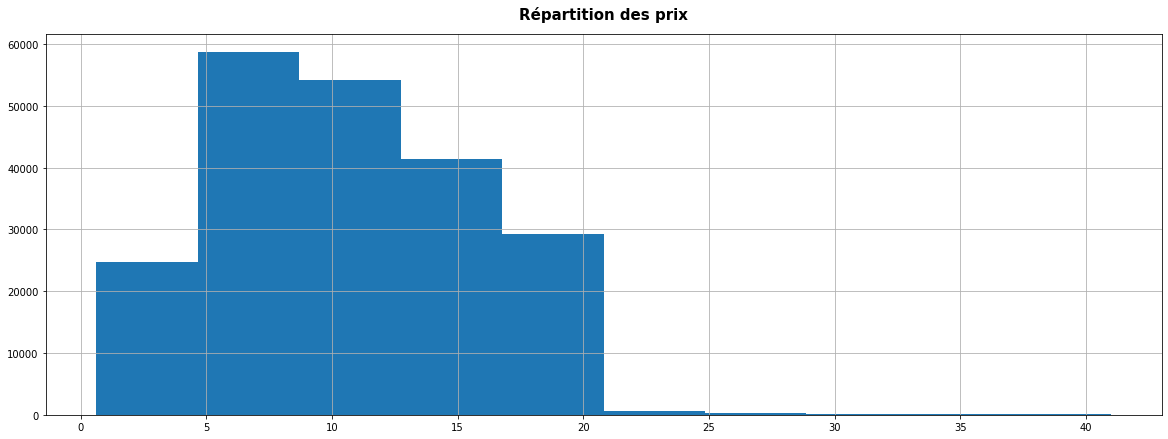

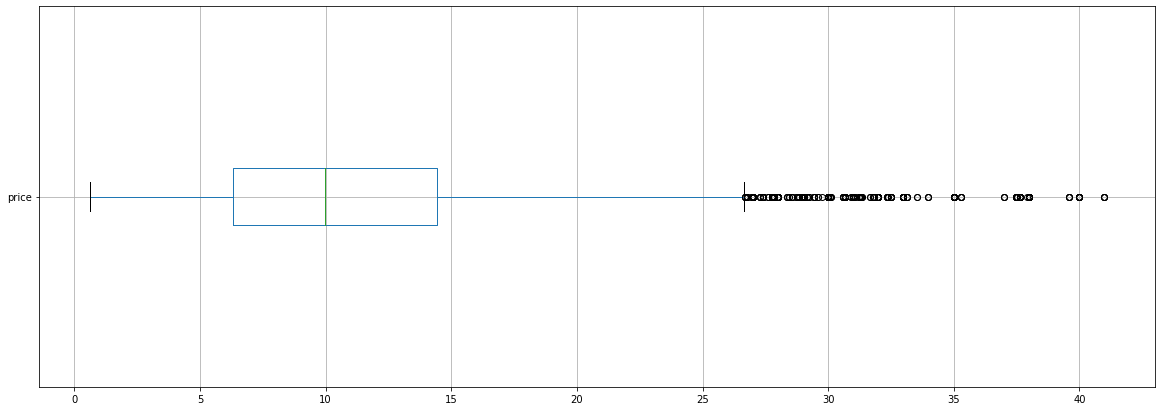

--------------------
CATEGORY 1
MEAN price:
 20.480105800342987
MEDIAN price:
 19.08
MODE price:
 0    15.99
dtype: float64
var:
 57.28857407270174
ect:
 7.568921592453032
skw:
 1.727288185296096
kur:
 8.154192525286465
--------------------
MOST product SOLD from Category 1 :
 0    1_369
dtype: object
MOST client PURCHASED:
 0    c_1609
dtype: object
MOST sex:
 0    f
dtype: object
MOST month:
 0    January
Name: month, dtype: category
Categories (12, object): ['March' < 'April' < 'May' < 'June' ... 'November' < 'December' < 'January' <
                          'February']
MOST day:
 0    1
dtype: int64


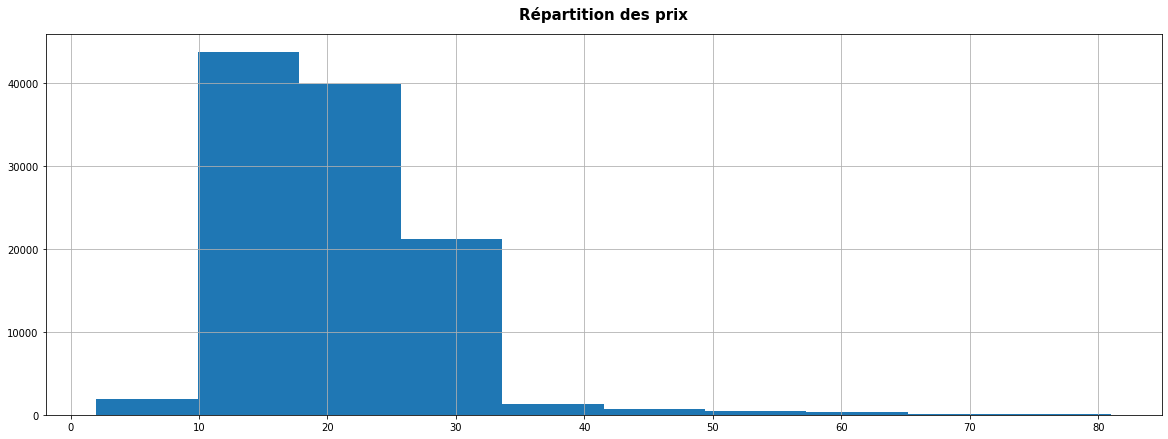

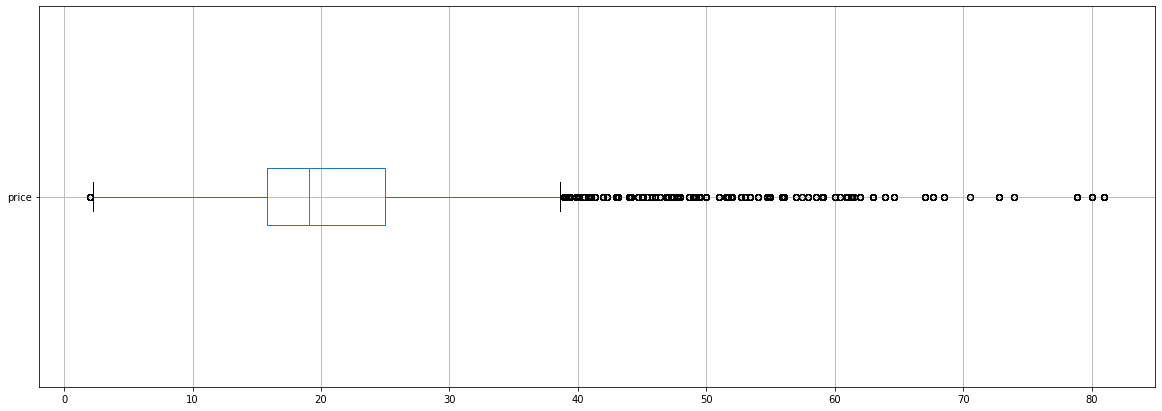

--------------------
CATEGORY 2
MEAN price:
 75.17494929352512
MEDIAN price:
 62.83
MODE price:
 0    68.99
dtype: float64
var:
 1527.1592950064933
ect:
 39.07888553946355
skw:
 2.3156310026622955
kur:
 5.537461225837998
--------------------
MOST product SOLD from Category 2 :
 0    2_135
dtype: object
MOST client PURCHASED:
 0    c_4958
dtype: object
MOST sex:
 0    m
dtype: object
MOST month:
 0    July
Name: month, dtype: category
Categories (12, object): ['March' < 'April' < 'May' < 'June' ... 'November' < 'December' < 'January' <
                          'February']
MOST day:
 0    23
dtype: int64


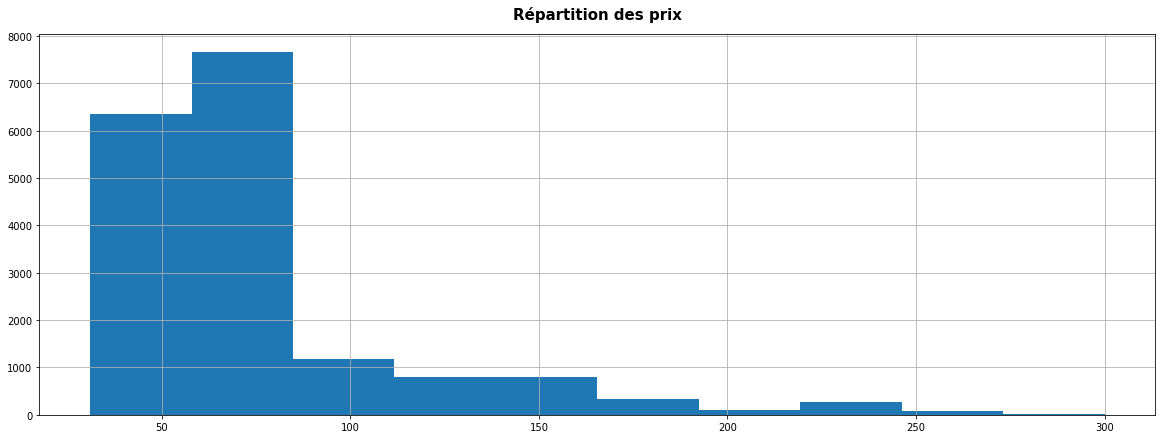

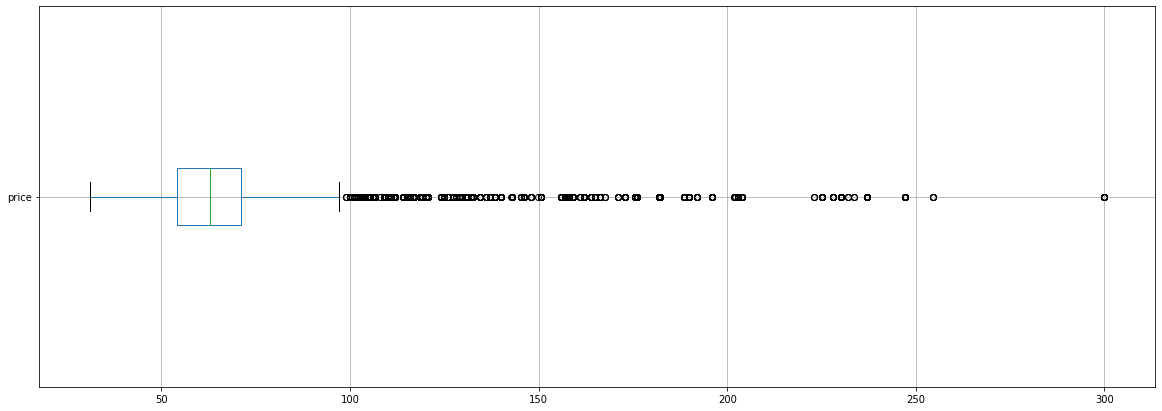

In [ ]:
for cat in tpc["categ"].unique():
    subset = tpc[tpc.categ == cat]       # Création du sous-échantillon
    print("-"*20)
    print("CATEGORY", cat)
    # For each category,
    # we create a subset (sub sample)
    # which contains only the operations of the current category
    print("MEAN price:\n",subset["price"].mean())     # Moyenne
    print("MEDIAN price:\n",subset["price"].median()) # Mediane
    print("MODE price:\n",subset["price"].mode())     # Mode
    print("var:\n",subset["price"].var(ddof=0))       # Variance
    print("ect:\n",subset["price"].std(ddof=0))       # Ecart type
    print("skw:\n",subset['price'].skew())            # Skewness
    print("kur:\n",subset['price'].kurtosis())        # Kusrtosis
    print("-"*20)
    print("MOST product SOLD from Category", cat, ":\n",subset["id_prod"].mode())
    print("MOST client PURCHASED:\n",subset["client_id"].mode())
    print("MOST sex:\n",subset["sex"].mode())
    print("MOST month:\n",subset["month"].mode())
    print("MOST day:\n",subset["day"].mode())

    # Titre
    plt.title("Répartition des prix", fontsize=15, fontweight="bold", pad=15)

    subset["price"].hist(figsize=(20,7)) # Crée l'histogramme
    plt.show()                          # Affiche l'histogramme
    subset.boxplot(column="price", vert=False, figsize=(20,7))
    plt.show()

#### Per gender

In [ ]:
# central tendency for female clients
age_f = tpc[tpc["sex"] == "f"][["price", "age"]]
age_f.describe()

price            age
count  167575.000000  167575.000000
mean       17.065618      44.737544
std        17.360067      13.846978
min         0.620000      18.000000
25%         8.610000      35.000000
50%        13.940000      43.000000
75%        18.990000      53.000000
max       300.000000      93.000000

In [ ]:
# central tendency for male clients
age_m = tpc[tpc["sex"] == "m"][["price", "age"]]
age_m.describe()

price            age
count  169241.000000  169241.000000
mean       17.359394      43.621185
std        18.327029      13.172784
min         0.620000      18.000000
25%         8.580000      35.000000
50%        13.830000      42.000000
75%        18.990000      50.000000
max       300.000000      93.000000

--------------------
GENDER =  f
moy:
 17.065618200832667
med:
 13.94
mod:
 0    15.99
dtype: float64
var:
 301.3701343895442
ect:
 17.3600153913971
MOST product bought by [gender] f :
 0    1_369
dtype: object
MOST client PURCHASED:
 0    c_6714
dtype: object
MOST sex:
 0    f
dtype: object
MOST month:
 0    September
Name: month, dtype: category
Categories (12, object): ['March' < 'April' < 'May' < 'June' ... 'November' < 'December' < 'January' <
                          'February']
MOST day:
 0    28
dtype: int64


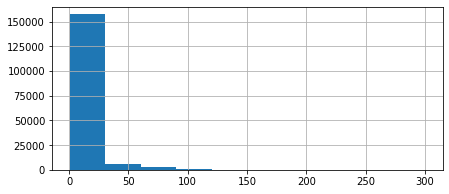

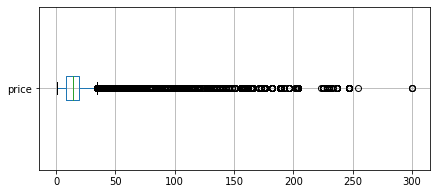

--------------------
GENDER =  m
moy:
 17.359394354824467
med:
 13.83
mod:
 0    15.99
dtype: float64
var:
 335.8780082317298
ect:
 18.326974879442865
MOST product bought by [gender] m :
 0    1_417
dtype: object
MOST client PURCHASED:
 0    c_1609
dtype: object
MOST sex:
 0    m
dtype: object
MOST month:
 0    September
Name: month, dtype: category
Categories (12, object): ['March' < 'April' < 'May' < 'June' ... 'November' < 'December' < 'January' <
                          'February']
MOST day:
 0    16
dtype: int64


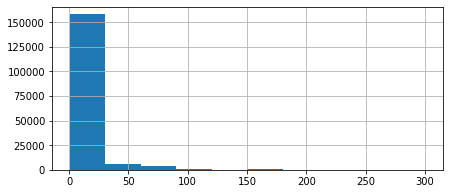

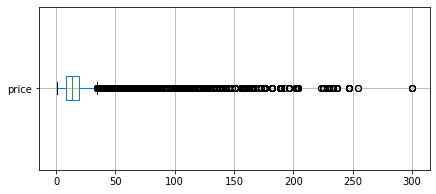

In [ ]:
for s in tpc["sex"].unique():
    subset = tpc[tpc.sex == s]       # Création du sous-échantillon
    print("-"*20)
    print("GENDER = ",s)
    # For each category,
    # we create a subset (sub sample)
    # which contains only the operations of the current category
    print("moy:\n",subset["price"].mean())
    print("med:\n",subset["price"].median())
    print("mod:\n",subset["price"].mode())
    print("var:\n",subset["price"].var(ddof=0))
    print("ect:\n",subset["price"].std(ddof=0))
    print("MOST product bought by [gender]", s, ":\n",subset["id_prod"].mode())
    print("MOST client PURCHASED:\n",subset["client_id"].mode())
    print("MOST sex:\n",subset["sex"].mode())
    print("MOST month:\n",subset["month"].mode())
    print("MOST day:\n",subset["day"].mode())

    subset["price"].hist(figsize=(7,3)) # Crée l'histogramme
    plt.show()                          # Affiche l'histogramme
    subset.boxplot(column="price", vert=False, figsize=(7,3))
    plt.show()

#### Per age

In [ ]:
age_sex_df = tpc

print("count = ",tpc["age"].count())
print("mode = ",round(age_sex_df["age"].mode()[0],2))
print("mean = ",round(age_sex_df["age"].mean(),2))
print("ecart type = ",round(age_sex_df["age"].std(ddof=0),2))
print("min = ",round(age_sex_df["age"].min(),2))
print("q1 = ",round(age_sex_df["age"].quantile(.25),2))
print("median = ",round(age_sex_df["age"].quantile(.50),2))
print("q3 = ",round(age_sex_df["age"].quantile(.75),2))
print("max = ",round(age_sex_df["age"].max(),2))
print("variance = ",round(age_sex_df["age"].var(ddof=0),2))
print("skewness = ",round(age_sex_df["age"].skew(),2))
print("kurtosis = ",round(age_sex_df["age"].kurtosis(),2))

# pour le fichier TPC [age]

count =  336816
mode =  42
mean =  44.18
ecart type =  13.52
min =  18
q1 =  35.0
median =  42.0
q3 =  51.0
max =  93
variance =  182.9
skewness =  0.58
kurtosis =  0.45


#### Per month

--------------------
MONTH of  March
moy:
 16.781343111170244
med:
 13.71
mod:
 0    15.99
dtype: float64
var:
 291.38894642133255
ect:
 17.07011852393921
MOST product bought in the month of  March :
 0    1_498
dtype: object
MOST client PURCHASED:
 0    c_1609
dtype: object
MOST sex:
 0    m
dtype: object
MOST month:
 0    March
Name: month, dtype: category
Categories (12, object): ['March' < 'April' < 'May' < 'June' ... 'November' < 'December' < 'January' <
                          'February']
MOST day:
 0    21
dtype: int64


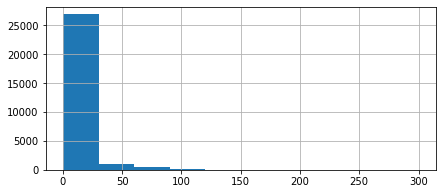

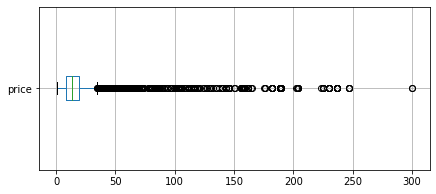

--------------------
MONTH of  April
moy:
 16.650790075661213
med:
 12.99
mod:
 0    3.99
dtype: float64
var:
 309.8873071463203
ect:
 17.603616308767933
MOST product bought in the month of  April :
 0    1_369
1    1_407
dtype: object
MOST client PURCHASED:
 0    c_1609
dtype: object
MOST sex:
 0    f
dtype: object
MOST month:
 0    April
Name: month, dtype: category
Categories (12, object): ['March' < 'April' < 'May' < 'June' ... 'November' < 'December' < 'January' <
                          'February']
MOST day:
 0    25
dtype: int64


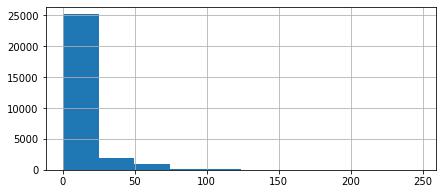

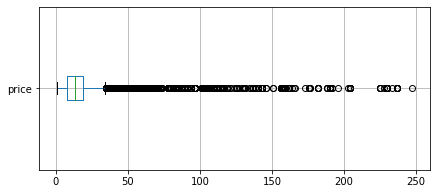

--------------------
MONTH of  May
moy:
 17.328890423080576
med:
 13.23
mod:
 0    4.99
dtype: float64
var:
 372.4124907143662
ect:
 19.297991882949017
MOST product bought in the month of  May :
 0    1_417
dtype: object
MOST client PURCHASED:
 0    c_1609
dtype: object
MOST sex:
 0    f
dtype: object
MOST month:
 0    May
Name: month, dtype: category
Categories (12, object): ['March' < 'April' < 'May' < 'June' ... 'November' < 'December' < 'January' <
                          'February']
MOST day:
 0    8
dtype: int64


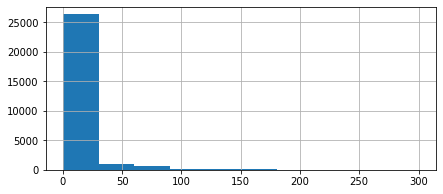

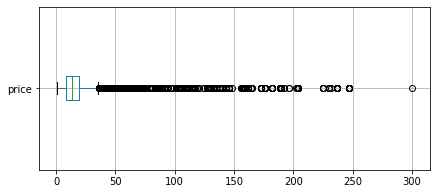

--------------------
MONTH of  June
moy:
 17.94748797494005
med:
 13.99
mod:
 0    15.99
dtype: float64
var:
 354.48990465958303
ect:
 18.82790229047259
MOST product bought in the month of  June :
 0    1_412
dtype: object
MOST client PURCHASED:
 0    c_1609
dtype: object
MOST sex:
 0    m
dtype: object
MOST month:
 0    June
Name: month, dtype: category
Categories (12, object): ['March' < 'April' < 'May' < 'June' ... 'November' < 'December' < 'January' <
                          'February']
MOST day:
 0    22
dtype: int64


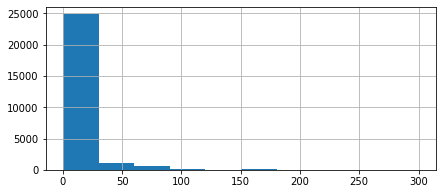

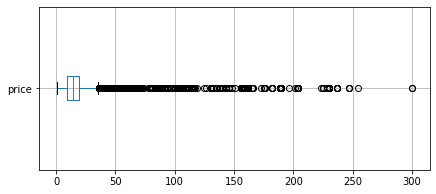

--------------------
MONTH of  July
moy:
 19.45872875869565
med:
 14.99
mod:
 0    15.99
dtype: float64
var:
 436.8848254190565
ect:
 20.901790005142058
MOST product bought in the month of  July :
 0    1_414
dtype: object
MOST client PURCHASED:
 0    c_1609
dtype: object
MOST sex:
 0    m
dtype: object
MOST month:
 0    July
Name: month, dtype: category
Categories (12, object): ['March' < 'April' < 'May' < 'June' ... 'November' < 'December' < 'January' <
                          'February']
MOST day:
 0    1
dtype: int64


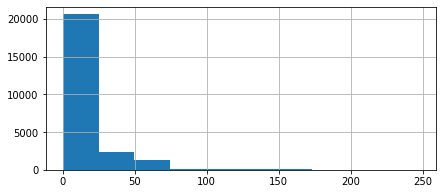

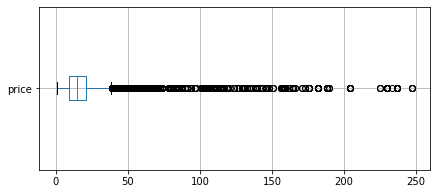

--------------------
MONTH of  August
moy:
 18.71277450329522
med:
 13.99
mod:
 0    15.99
dtype: float64
var:
 452.03390549936785
ect:
 21.261089000786573
MOST product bought in the month of  August :
 0    1_406
1    1_414
dtype: object
MOST client PURCHASED:
 0    c_1609
dtype: object
MOST sex:
 0    m
dtype: object
MOST month:
 0    August
Name: month, dtype: category
Categories (12, object): ['March' < 'April' < 'May' < 'June' ... 'November' < 'December' < 'January' <
                          'February']
MOST day:
 0    27
dtype: int64


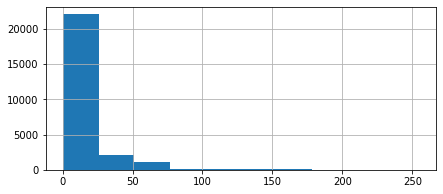

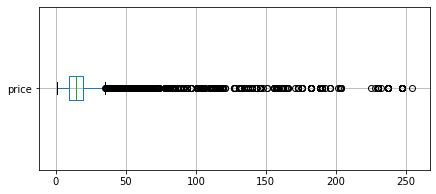

--------------------
MONTH of  September
moy:
 15.117571093605866
med:
 12.99
mod:
 0    15.99
dtype: float64
var:
 189.5116665407438
ect:
 13.76632363925619
MOST product bought in the month of  September :
 0    1_369
dtype: object
MOST client PURCHASED:
 0    c_1609
dtype: object
MOST sex:
 0    m
dtype: object
MOST month:
 0    September
Name: month, dtype: category
Categories (12, object): ['March' < 'April' < 'May' < 'June' ... 'November' < 'December' < 'January' <
                          'February']
MOST day:
 0    30
dtype: int64


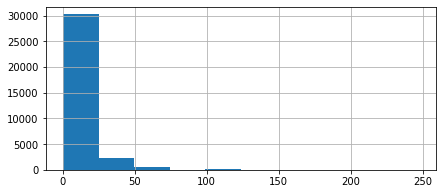

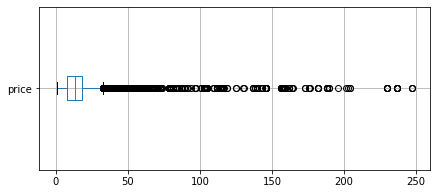

--------------------
MONTH of  October
moy:
 14.790386397329094
med:
 11.03
mod:
 0    4.99
dtype: float64
var:
 307.511456902226
ect:
 17.53600458776816
MOST product bought in the month of  October :
 0    0_1428
dtype: object
MOST client PURCHASED:
 0    c_1609
dtype: object
MOST sex:
 0    m
dtype: object
MOST month:
 0    October
Name: month, dtype: category
Categories (12, object): ['March' < 'April' < 'May' < 'June' ... 'November' < 'December' < 'January' <
                          'February']
MOST day:
 0    1
dtype: int64


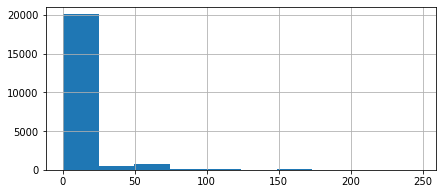

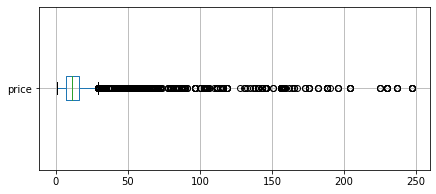

--------------------
MONTH of  November
moy:
 18.141895179824843
med:
 14.99
mod:
 0    15.99
dtype: float64
var:
 308.0625463357878
ect:
 17.551710638447403
MOST product bought in the month of  November :
 0    1_412
dtype: object
MOST client PURCHASED:
 0    c_1609
dtype: object
MOST sex:
 0    m
dtype: object
MOST month:
 0    November
Name: month, dtype: category
Categories (12, object): ['March' < 'April' < 'May' < 'June' ... 'November' < 'December' < 'January' <
                          'February']
MOST day:
 0    13
dtype: int64


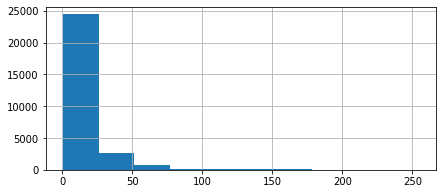

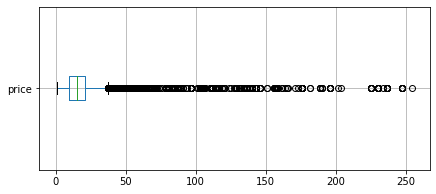

--------------------
MONTH of  December
moy:
 16.130441031331593
med:
 13.99
mod:
 0    15.99
dtype: float64
var:
 198.21417060489892
ect:
 14.078855443710577
MOST product bought in the month of  December :
 0    1_417
dtype: object
MOST client PURCHASED:
 0    c_1609
dtype: object
MOST sex:
 0    m
dtype: object
MOST month:
 0    December
Name: month, dtype: category
Categories (12, object): ['March' < 'April' < 'May' < 'June' ... 'November' < 'December' < 'January' <
                          'February']
MOST day:
 0    31
dtype: int64


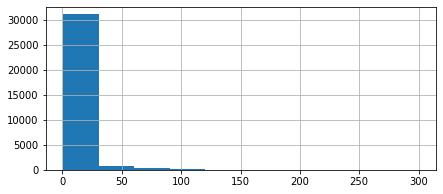

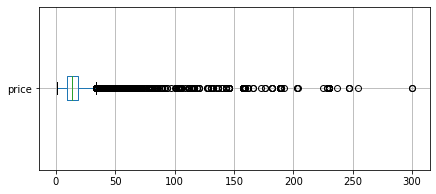

--------------------
MONTH of  January
moy:
 17.84040830945232
med:
 14.99
mod:
 0    15.99
dtype: float64
var:
 289.7769376044514
ect:
 17.02283576859189
MOST product bought in the month of  January :
 0    1_369
dtype: object
MOST client PURCHASED:
 0    c_1609
dtype: object
MOST sex:
 0    f
dtype: object
MOST month:
 0    January
Name: month, dtype: category
Categories (12, object): ['March' < 'April' < 'May' < 'June' ... 'November' < 'December' < 'January' <
                          'February']
MOST day:
 0    8
dtype: int64


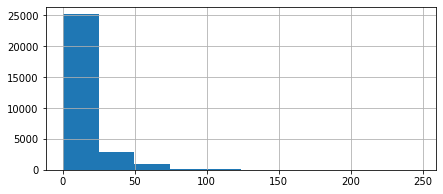

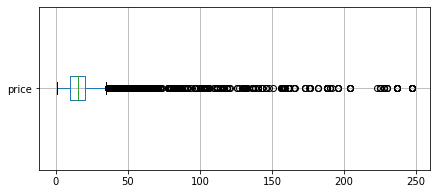

--------------------
MONTH of  February
moy:
 18.022115872422013
med:
 13.99
mod:
 0    15.99
dtype: float64
var:
 360.77803645384586
ect:
 18.994157955904384
MOST product bought in the month of  February :
 0    1_425
dtype: object
MOST client PURCHASED:
 0    c_1609
dtype: object
MOST sex:
 0    f
dtype: object
MOST month:
 0    February
Name: month, dtype: category
Categories (12, object): ['March' < 'April' < 'May' < 'June' ... 'November' < 'December' < 'January' <
                          'February']
MOST day:
 0    27
dtype: int64


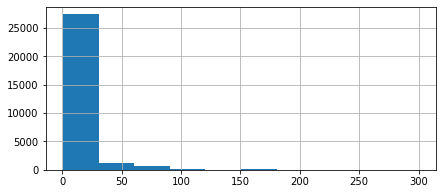

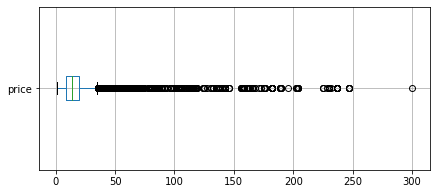

In [ ]:
for m in tpc["month"].unique():
    subset = tpc[tpc.month == m]       # Création du sous-échantillon
    print("-"*20)
    print("MONTH of ", m)
    # For each category,
    # we create a subset (sub sample)
    # which contains only the operations of the current category
    print("moy:\n",subset["price"].mean())
    print("med:\n",subset["price"].median())
    print("mod:\n",subset["price"].mode())
    print("var:\n",subset["price"].var(ddof=0))
    print("ect:\n",subset["price"].std(ddof=0))
    print("MOST product bought in the month of ", m, ":\n",subset["id_prod"].mode())
    print("MOST client PURCHASED:\n",subset["client_id"].mode())
    print("MOST sex:\n",subset["sex"].mode())
    print("MOST month:\n",subset["month"].mode())
    print("MOST day:\n",subset["day"].mode())

    subset["price"].hist(figsize=(7,3)) # Crée l'histogramme
    plt.show()                          # Affiche l'histogramme
    subset.boxplot(column="price", vert=False, figsize=(7,3))
    plt.show()

#### Per quarter

--------------------
Quarter =  1
moy:
 17.293996672854142
med:
 13.9
mod:
 0    15.99
dtype: float64
var:
 328.11720850376037
ect:
 18.11400586573164
MOST product bought in quarter  1 :
 0    1_369
dtype: object
MOST client PURCHASED:
 0    c_1609
dtype: object
MOST sex:
 0    f
dtype: object
MOST month:
 0    February
Name: month, dtype: category
Categories (12, object): ['March' < 'April' < 'May' < 'June' ... 'November' < 'December' < 'January' <
                          'February']
MOST day:
 0    1
dtype: int64


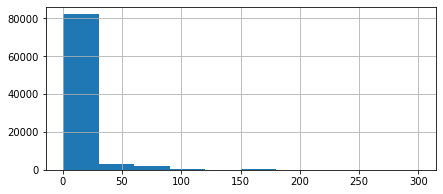

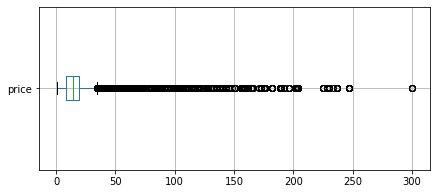

--------------------
Quarter =  2
moy:
 17.078485743043473
med:
 13.79
mod:
 0    15.99
dtype: float64
var:
 309.3195357523418
ect:
 17.58748235968815
MOST product bought in quarter  2 :
 0    1_369
dtype: object
MOST client PURCHASED:
 0    c_1609
dtype: object
MOST sex:
 0    m
dtype: object
MOST month:
 0    September
Name: month, dtype: category
Categories (12, object): ['March' < 'April' < 'May' < 'June' ... 'November' < 'December' < 'January' <
                          'February']
MOST day:
 0    16
dtype: int64


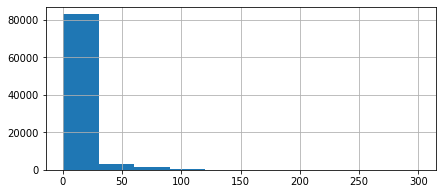

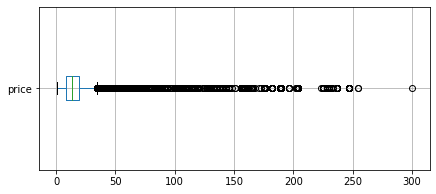

--------------------
Quarter =  3
moy:
 17.200397791053994
med:
 13.79
mod:
 0    15.99
dtype: float64
var:
 315.27344940008084
ect:
 17.755941242301994
MOST product bought in quarter  3 :
 0    1_414
dtype: object
MOST client PURCHASED:
 0    c_1609
dtype: object
MOST sex:
 0    m
dtype: object
MOST month:
 0    September
Name: month, dtype: category
Categories (12, object): ['March' < 'April' < 'May' < 'June' ... 'November' < 'December' < 'January' <
                          'February']
MOST day:
 0    23
dtype: int64


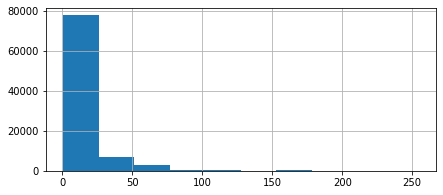

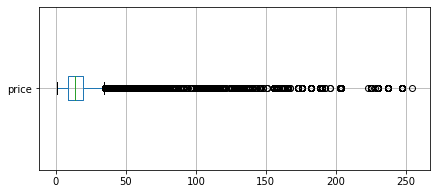

--------------------
Quarter =  4
moy:
 17.29545443252474
med:
 13.99
mod:
 0    15.99
dtype: float64
var:
 323.0173602357641
ect:
 17.972683723800518
MOST product bought in quarter  4 :
 0    1_414
dtype: object
MOST client PURCHASED:
 0    c_1609
dtype: object
MOST sex:
 0    m
dtype: object
MOST month:
 0    December
Name: month, dtype: category
Categories (12, object): ['March' < 'April' < 'May' < 'June' ... 'November' < 'December' < 'January' <
                          'February']
MOST day:
 0    28
dtype: int64


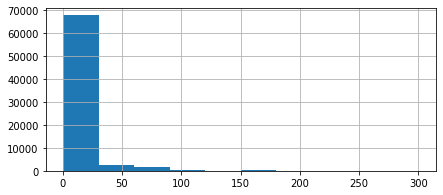

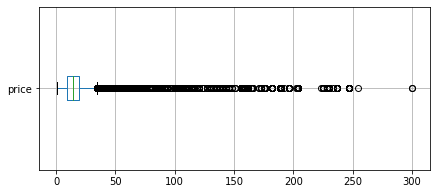

In [ ]:
for q in tpc["quarterly"].unique():
    subset = tpc[tpc.quarterly == q]       # Création du sous-échantillon
    print("-"*20)
    print("Quarter = ", q)
    # For each category,
    # we create a subset (sub sample)
    # which contains only the operations of the current category
    print("moy:\n",subset["price"].mean())
    print("med:\n",subset["price"].median())
    print("mod:\n",subset["price"].mode())
    print("var:\n",subset["price"].var(ddof=0))
    print("ect:\n",subset["price"].std(ddof=0))
    print("MOST product bought in quarter ", q, ":\n",subset["id_prod"].mode())
    print("MOST client PURCHASED:\n",subset["client_id"].mode())
    print("MOST sex:\n",subset["sex"].mode())
    print("MOST month:\n",subset["month"].mode())
    print("MOST day:\n",subset["day"].mode())

    subset["price"].hist(figsize=(7,3)) # Crée l'histogramme
    plt.show()                          # Affiche l'histogramme
    subset.boxplot(column="price", vert=False, figsize=(7,3))
    plt.show()

## Analyse de concentration (Lorenz & Gini)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


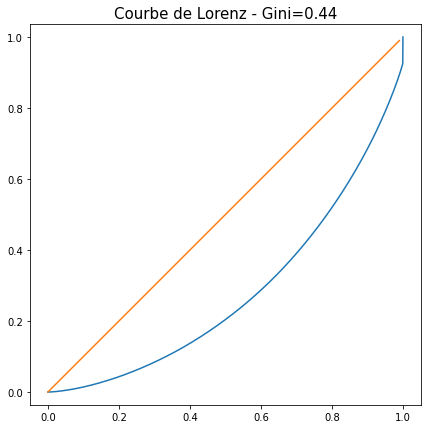

L'indice de Gini est égal à 0.44
On observe alors sur la courbe de Lorenz, avec un indice de Gini proche de 0,5 que la répartition du CA par client n'est pas égalitaire.


In [ ]:
plt.figure(figsize=(7,7))
# Courbe de Lorenz sur la variables prix
clients=pd.DataFrame(tpc.groupby("client_id").sum()["price"]).sort_values("price")
depenses = clients.price.values
n = len(depenses)

# On place les observations dans une variable
lorenz = np.append([0], np.cumsum(depenses)/sum(depenses))
gini=2*(0.5-lorenz.sum()/n)

plt.plot(np.linspace(0-1/n, 1+1/n, n+1), lorenz)
plt.axes().axis("equal")
plt.title("Courbe de Lorenz - Gini=%s" %(round(gini, 2)), fontsize=15)

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Lorenz and Gini.png")
X = np.arange(0,1,0.01)
Y=X
plt.plot(X, Y)
plt.show()

print(f"L'indice de Gini est égal à {gini:.2f}")
print("On observe alors sur la courbe de Lorenz, avec un indice de Gini proche de 0,5 que la répartition du CA par client n'est pas égalitaire.")

In [ ]:
# plt.figure(figsize=(15,7))
# # Courbe de Lorenz sur la variables prix
# prix = tpc['price'].values

# # On place les observations dans une variable
# lorenz_price = np.cumsum(np.sort(prix)) / prix.sum()

# plt.plot(np.linspace(0,1,len(lorenz_price)), lorenz_price, label='Lorenz')
# plt.fill_between(np.linspace(0,1,len(lorenz_price)) ,lorenz_price)
# plt.plot([0, 1], [0, 1],   label='Distribution égalitaire')

# # plt.vlines(x=.65, ymin=0, ymax=.39,color='r' , linestyle='--', linewidth=1, label='Medial')
# # plt.hlines(xmin=.65, xmax=0, y=.39,color='r' , linestyle='--', linewidth=1)

# plt.legend(loc="best")

# plt.title("Courbe de Lorenz des prix")
# plt.xlabel("Distribution des prix")
# plt.ylabel("Cumul de prix ")

# # plt.savefig("Data/courbe_lorenz_age.png")
# plt.show()

In [ ]:
# #### Aire sous la courbe de Lorenz
# AUC = lorenz_price[:-1].sum()/len(lorenz_price)

# #Aire entre la 1e bissectrice et la courbe de Lorenz
# S = 0.5 - AUC 
# gini = round(2*S, 2)

# print("L'indice de Gini est égal à {}".format(gini))
# print("On observe alors sur la courbe de Lorenz, avec un indice de Gini proche de 0,5 que la répartition du CA par client n'est pas égalitaire.")

## Univariate analysis

### Clients

#### Key figures

In [ ]:
# number of total clients
num_cl = len(cl["client_id"].unique())
print("There are", {num_cl}, "registered clients in total")

# counting total male and female clients
genre = set(cl["sex"].unique())
print("client genres:", genre)
print("there are", {len(genre)}, "different genres in total :\n")
# other option: cl.sex.count()

sf = (cl.loc[cl["sex"] == "f"])["sex"].count()
sm = (cl.loc[cl["sex"] == "m"])["sex"].count()
total_genre = sf + sm
print(f"Female = {sf} clients\nMale = {sm} clients\n--------------------------\nTOTAL of {total_genre} clients\n")

cl.groupby("sex", as_index=False)[["client_id"]].count().rename(columns={"client_id":" client count"})

There are {8621} registered clients in total
client genres: {'m', 'f'}
there are {2} different genres in total :

Female = 4490 clients
Male = 4131 clients
--------------------------
TOTAL of 8621 clients



sex   client count
0   f           4490
1   m           4131

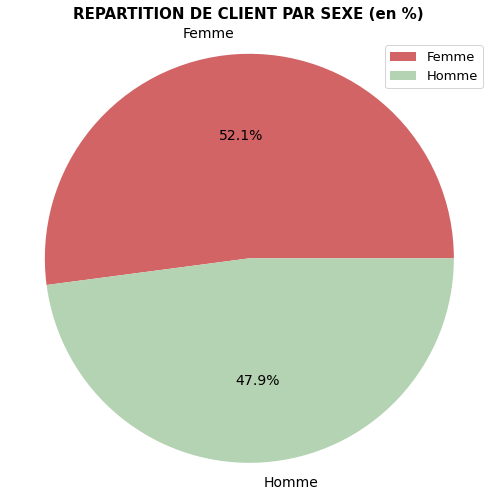

In [ ]:
# male vs female
plt.figure(figsize=(7,7))

sizes= cl["sex"].value_counts(normalize=True)
plt.pie(sizes, labels=sex_label, colors=sex_color, startangle=0, autopct="%1.1f%%", textprops={"fontsize": 14})

plt.title("REPARTITION DE CLIENT PAR SEXE (en %)", fontsize=15, fontweight="bold", pad=20)
plt.axis("equal")
plt.legend(fontsize=13, loc=1)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Repartition client par sex.png")
plt.show()

#### Age distribution

In [ ]:
cl

client_id sex  age
0       c_4410   f   55
1       c_7839   f   47
2       c_1699   f   38
3       c_5961   f   60
4       c_5320   m   79
...        ...  ..  ...
8618    c_7920   m   66
8619    c_7403   f   52
8620    c_5119   m   48
8621    c_5643   f   54
8622      c_84   f   40

[8621 rows x 3 columns]

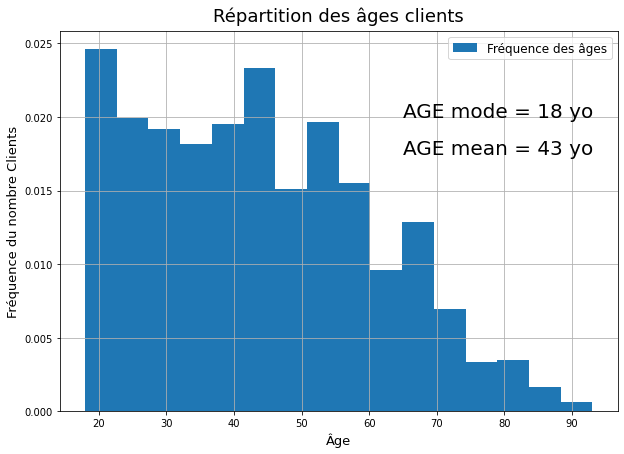

In [ ]:
plt.figure(figsize=(10,7))

# Histogramme de la variable âge des clients
repartition_age = cl['age'].hist(density = True, grid=True, bins=16)

# Titre
plt.title("Répartition des âges clients",loc="center",pad=10,color='black',fontsize=18,fontweight='normal')

# Titre des axes
plt.xlabel('Âge', color='black', fontsize=13)
plt.ylabel('Fréquence du nombre Clients', color='black', fontsize=13)

# Graduation des axes
plt.xticks(color='black', rotation='horizontal')
plt.yticks(color='black')

# Légende
plt.legend(["Fréquence des âges"], loc="upper right", fontsize=12)

# Text
plt.text(65, .0175, "AGE mean = " + str(math.floor(cl["age"].mean())) + " yo", fontsize=20)
plt.text(65, .02, "AGE mode = " + str(math.floor(cl["age"].mode())) + " yo", fontsize=20)

# Affichage
plt.show()

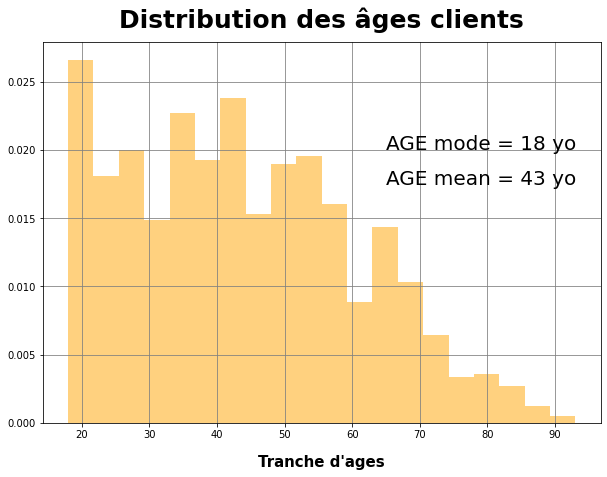

In [ ]:
plt.figure(figsize=(10,7))

# Visualisation (Histogramme)de la distribution de l'âge des clients
cl['age'].hist(density=True, alpha=0.5, bins=20, color="orange")

# settings
plt.xlabel("Tranche d'ages", fontsize=15, fontweight="bold", labelpad=15)
plt.title('Distribution des âges clients', fontsize=25, fontweight="bold", pad=15)
plt.grid(color="gray")

# Text
plt.text(65, .0175, "AGE mean = " + str(math.floor(cl["age"].mean())) + " yo", fontsize=20)
plt.text(65, .02, "AGE mode = " + str(math.floor(cl["age"].mode())) + " yo", fontsize=20)

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Repartition client par age (table Customers).png")
plt.show()

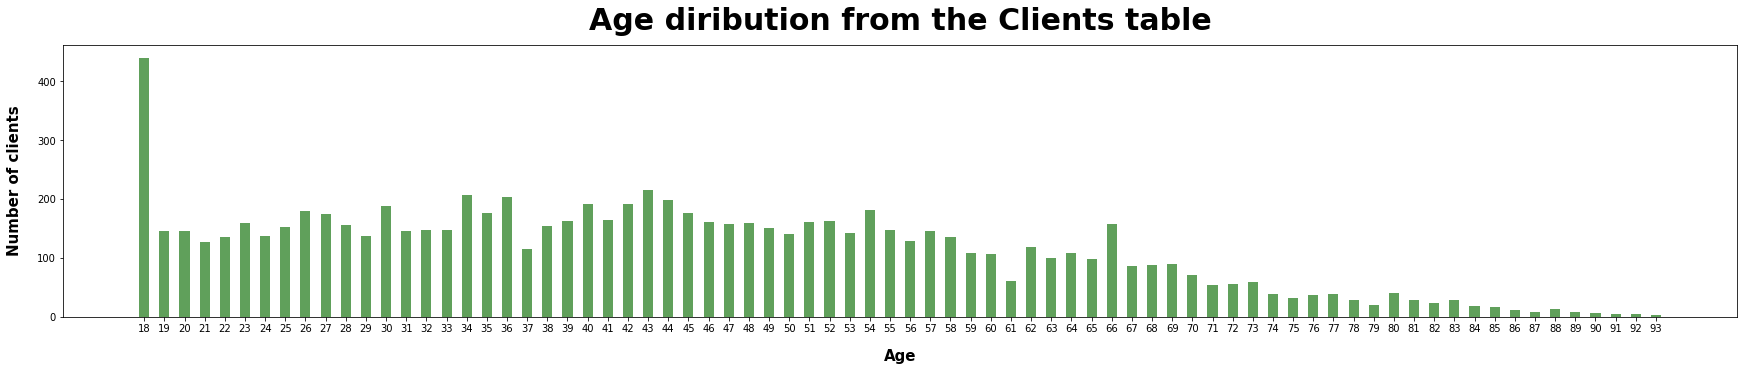

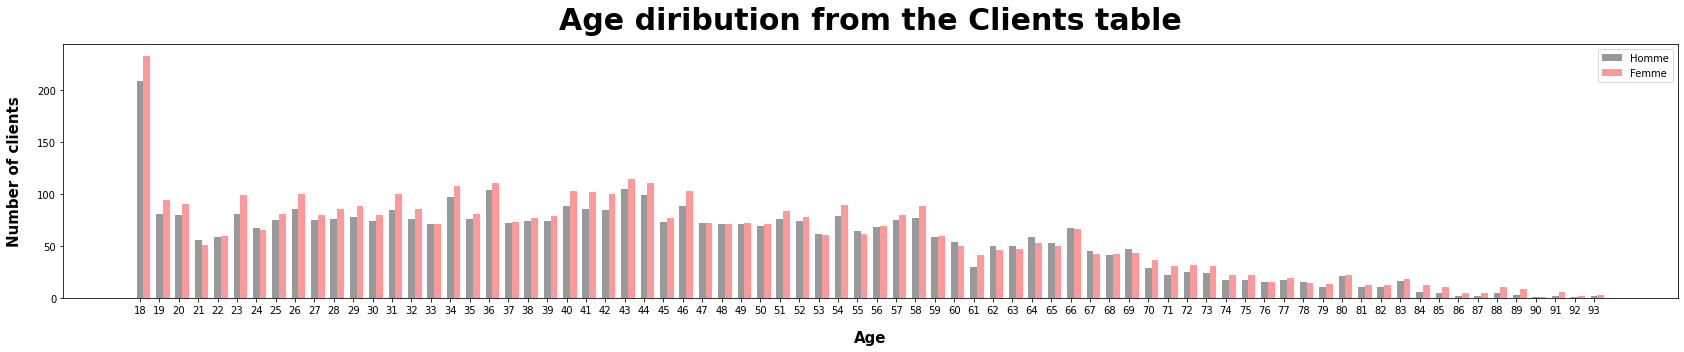

In [ ]:
homme_df = cl[cl["sex"] == "m"].copy()
femme_df = cl[cl["sex"] == "f"].copy()

#Visualisation de la distribtion des clients par age
#Visualisation de la comparaison entre les hommes et les femmes par rapport a leur age
effectifs = cl["age"].value_counts()
modalites = effectifs.index # l'index de effectifs contient les modalités

plt.figure(figsize=(30, 5))
# gs = gridspec.GridSpec(1, 2, width_ratios=[.5, 5]) 
# ax1 = plt.subplot(gs[0])
# ax1.pie([homme_df["age"].count(), femme_df["age"].count()], labels = ['Homme', 'Femme'], autopct='%1.1f%%')
# ax2 = plt.subplot(gs[1])
# ax2.axis('off')
# plt.xticks(rotation=90)
xticks = effectifs.index
ticklabels = effectifs.index
plt.xticks(xticks, ticklabels)
plt.xlabel("Age", fontsize=15, fontweight="bold", labelpad=15)
plt.ylabel("Number of clients", fontsize=15, fontweight="bold", labelpad=15)
plt.title("Age diribution from the Clients table", fontsize=30, fontweight="bold", pad=15)
plt.bar(effectifs.index, effectifs, 0.5, color="#60A05B" )
plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Distribution age clients.png")

effectifs_femme = femme_df["age"].value_counts()
modalites_femme = effectifs_femme.index # l'index de effectifs contient les modalités
effectifs_homme = homme_df["age"].value_counts()
modalites_homme = effectifs_homme.index # l'index de effectifs contient les modalités

fig = plt.figure(2, figsize=(23.5, 5))
bar_width = 0.35
opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(modalites_homme, effectifs_homme, bar_width, alpha=opacity, color="black", error_kw=error_config, label='Homme')
rects2 = plt.bar(modalites_homme + bar_width, effectifs_femme, bar_width, alpha=opacity, color="red", error_kw=error_config, label='Femme')

plt.xlabel("Age", fontsize=15, fontweight="bold", labelpad=15)
plt.ylabel("Number of clients", fontsize=15, fontweight="bold", labelpad=15)
plt.title("Age diribution from the Clients table", fontsize=30, fontweight="bold", pad=15)
xticks = effectifs.index
ticklabels = effectifs.index
plt.xticks(xticks, ticklabels)

plt.legend()
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Distribution age clients par sex.png")

plt.show()

La fréquence d'âge la plus forte chez nos clients est 18 ans. Les retraités se sentent de moins en moins concernés par nos produits. 50% de nos clients ont entre 30 et 55 ans. 25% ont moins de 30 ans et 25% ont plus de 55 ans.

#### Inactive clients

In [ ]:
## inactive clients
# getting distinct CLIENTS from Transaction data set
list_cl = set(tr["client_id"].unique())
list_cl = sorted(list_cl)
#print(f"There are {list_prod["id_prod"].value_counts()} products sold")

# preparing a list of INACTIVE clients
inactive = cl[~cl["client_id"].isin(list_cl)]

# detecting INACTIVE clients
print("There are", {inactive["client_id"].count()}, "inactive clients :\n")
print(inactive.count(), "\n")

cl_inactive = sorted(set(inactive["client_id"]))
print(f"Complete list of INACTIVE clients :\n{cl_inactive}\n")

# autre methode
# vérifions s'il existe des clients présent dans "clients" mais absent dans "transactions".
is_absent = set(cl[cl.client_id.isin(tr.client_id)==False]["client_id"].unique())
print(f'AUTRE METHODE\nnombre de clients non présent dans "transactions" = {len(is_absent)}')
is_absent

There are {21} inactive clients :

client_id    21
sex          21
age          21
dtype: int64 

Complete list of INACTIVE clients :
['c_1223', 'c_2706', 'c_3017', 'c_3443', 'c_3526', 'c_3789', 'c_4086', 'c_4358', 'c_4406', 'c_4447', 'c_5223', 'c_5245', 'c_587', 'c_6735', 'c_6862', 'c_6930', 'c_7584', 'c_8253', 'c_8381', 'c_862', 'c_90']

AUTRE METHODE
nombre de clients non présent dans "transactions" = 21


{'c_1223',
 'c_2706',
 'c_3017',
 'c_3443',
 'c_3526',
 'c_3789',
 'c_4086',
 'c_4358',
 'c_4406',
 'c_4447',
 'c_5223',
 'c_5245',
 'c_587',
 'c_6735',
 'c_6862',
 'c_6930',
 'c_7584',
 'c_8253',
 'c_8381',
 'c_862',
 'c_90'}

#### Active clients

In [ ]:
# detecting ACTIVE clients
cl_active = cl[~cl["client_id"].isin(cl_inactive)]

print("There are", {cl_active.client_id.count()}, "active clients :\n")
print(cl_active.count(), "\n")
print(f"[TOTAL clients] {len(cl_active.client_id) + len(cl_inactive)} = [active] {len(cl_active.client_id)} + [inactive] {len(cl_inactive)}")

# autre methode
# vérifions le nombre des clients dans "clients" présent dans "transactions"
is_present = cl[cl.client_id.isin(tr.client_id)==True]["client_id"].unique()
print(f'\nAUTRE METHODE\nnombre de clients présent dans "transactions" = {len(is_present)}')

There are {8600} active clients :

client_id    8600
sex          8600
age          8600
dtype: int64 

[TOTAL clients] 8621 = [active] 8600 + [inactive] 21

AUTRE METHODE
nombre de clients présent dans "transactions" = 8600


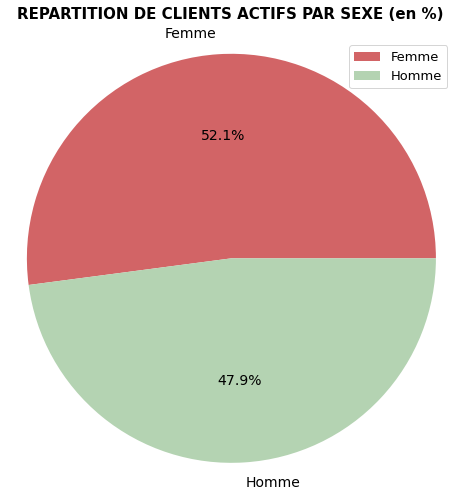

In [ ]:
# male active clientS vc female active clients
df_active = pd.DataFrame(cl_active.groupby("sex")[["client_id"]].count()).copy()
df_active.reset_index(inplace=True)

plt.figure(figsize=(7,7))

sizes= df_active["client_id"]
plt.pie(sizes, labels=sex_label, colors=sex_color, startangle=0, autopct="%1.1f%%", textprops={"fontsize": 14})

plt.title("REPARTITION DE CLIENTS ACTIFS PAR SEXE (en %)", fontsize=15, fontweight="bold", pad=20)
plt.axis("equal")
plt.legend(fontsize=13, loc=1)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Repartition clients actifs par sex.png")
plt.show()

#### Active vs Inactive

In [ ]:
# preparing a list of active clients
list_active = cl_active["client_id"].unique()

# creating a bolean column to identify ACTIVE from INACTIVE clients
cl["is_active"] = cl["client_id"].isin(list_active)

# verification
ac = cl.loc[cl["is_active"] == True].count()
ac = ac["is_active"]

ic = cl.loc[cl["is_active"] == False].count()
ic = ic["is_active"]

total_cl = ac + ic

print(f"To verify once more,\n\nThere are indeed {ic} INACTIVE clients and {ac} ACTIVE clients.\nMaking a total number of {total_cl} like the Clients data set confirms:\n\nclient_id COUNT = {cl.client_id.count()}")

To verify once more,

There are indeed 21 INACTIVE clients and 8600 ACTIVE clients.
Making a total number of 8621 like the Clients data set confirms:

client_id COUNT = 8621


There are {8621} registered clients in total
RAPPEL
--------------------------------------------
clients in Client = 8621 TOTAL
clients in Client = 21 INACTIVE
clients in Client = 2 DROPPED (ct_0 and ct_1)
--------------------------------------------
Clients in TPC = 8598





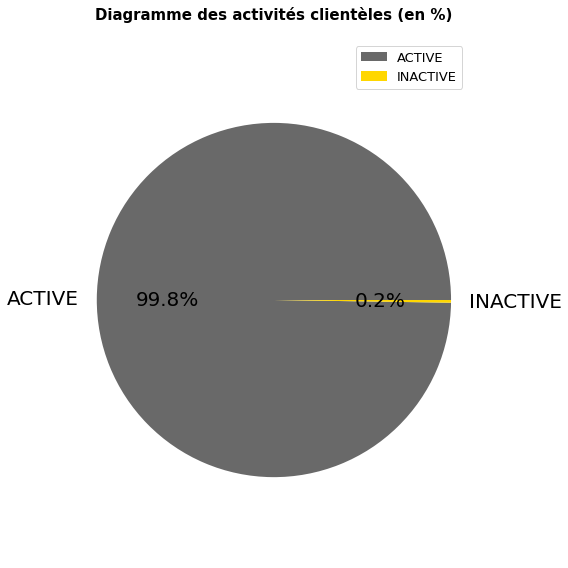

In [ ]:
print("There are", {num_cl}, "registered clients in total")
print(f"RAPPEL\n--------------------------------------------")
print(f"clients in Client = {len(cl.client_id.unique())} TOTAL\nclients in Client = {len(inactive)} INACTIVE\nclients in Client = 2 DROPPED (ct_0 and ct_1)")
print(f"--------------------------------------------\nClients in TPC = {len(cl.client_id.unique()) - len(inactive) - 2}\n\n\n")

plt.figure(figsize=(8,8))

labels= ["ACTIVE", "INACTIVE"]
color = ["dimgray","gold"]
sizes= cl["is_active"].value_counts(normalize=True)
plt.pie(sizes, labels=labels, colors=color, startangle=0, autopct="%1.1f%%", textprops={"fontsize": 20}, radius=2)

plt.title("Diagramme des activités clientèles (en %)", fontsize=15, fontweight="bold", pad=20)
plt.axis("equal")
plt.legend(fontsize=13, loc=1)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Repartition clients actifs et inactifs.png")
plt.show()

Donc un peu moins d'un client sur 400 s'enregistre mais n'effectue aucun achat.

#### Purchase amount per client

In [ ]:
tpc.groupby("client_id", as_index=False)[["price"]].sum().rename(columns={"client_id":"Client", "price":"TOTAL PURCHASE"})

Client  TOTAL PURCHASE
0        c_1          300.65
1       c_10          586.18
2      c_100          222.87
3     c_1000          980.02
4     c_1001         1102.45
...      ...             ...
8595   c_995          119.08
8596   c_996          739.60
8597   c_997          572.89
8598   c_998         1527.69
8599   c_999          305.00

[8600 rows x 2 columns]

#### Client annual purchase behavior

In [ ]:
# cl_bhv = annual expense + check out items

clients = pd.DataFrame(tpc.groupby(["client_id", "sex", "age", "client_type"]).sum()["price"]).reset_index()
clients.rename(columns={"price": "annual_expense"}, inplace=True)
nb_items = pd.DataFrame(tpc["client_id"].value_counts()).reset_index()
nb_items.columns=["client_id", "nb_checkout_items"]
cl_bhv = pd.merge(clients, nb_items)
cl_bhv

client_id sex  age client_type  annual_expense  nb_checkout_items
0          c_1   m   67      senior          300.65                 20
1         c_10   m   66      senior          586.18                 28
2        c_100   m   30     student          222.87                  6
3       c_1000   f   56      senior          980.02                 56
4       c_1001   m   40      active         1102.45                 58
...        ...  ..  ...         ...             ...                ...
8595     c_995   m   67      senior          119.08                  8
8596     c_996   f   52      senior          739.60                 42
8597     c_997   f   28     student          572.89                 23
8598     c_998   m   21     student         1527.69                 28
8599     c_999   m   58      senior          305.00                 22

[8600 rows x 6 columns]

In [ ]:
# un tableau nous donnant chaque identifiant de client avec son âge et la taille moyenne de ses paniers pour l'ensemble de ses achats

basket = pd.DataFrame(tpc.groupby(["client_id", "age", "client_type"]).mean()["basket_size"]).reset_index()
basket.rename(columns={"basket_size": "basket_mean"}, inplace=True)
basket["basket_mean"] = basket["basket_mean"].round(2)
basket

client_id  age client_type  basket_mean
0          c_1   67      senior         2.10
1         c_10   66      senior         2.50
2        c_100   30     student         2.33
3       c_1000   56      senior         1.96
4       c_1001   40      active         3.24
...        ...  ...         ...          ...
8595     c_995   67      senior         1.75
8596     c_996   52      senior         1.29
8597     c_997   28     student         3.00
8598     c_998   21     student         4.14
8599     c_999   58      senior         1.09

[8600 rows x 4 columns]

In [ ]:
monthly_basket_mean = tpc.pivot_table(index=["client_id", "age", "client_type"],
                          columns=["_monthnum"],
                          values=["basket_size"],
                          aggfunc=sum)

monthly_basket_mean = monthly_basket_mean.fillna(0)

monthly_basket_mean["monthly_basket_av"] = monthly_basket_mean.mean(axis=1)
monthly_basket_mean["monthly_basket_av"] = monthly_basket_mean.monthly_basket_av.round(2)
monthly_basket_mean = monthly_basket_mean.reset_index()
monthly_basket_mean.columns = ["client_id", "age", "client_type", "x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9", "x10", "x11", "x12", "monthly_basket_av"]
monthly_basket_mean.drop(columns=["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9", "x10", "x11", "x12"], inplace=True)
monthly_basket_mean

client_id  age client_type  monthly_basket_av
0          c_1   67      senior               3.50
1         c_10   66      senior               5.83
2        c_100   30     student               1.17
3       c_1000   56      senior               9.17
4       c_1001   40      active              15.67
...        ...  ...         ...                ...
8595     c_995   67      senior               1.17
8596     c_996   52      senior               4.50
8597     c_997   28     student               5.75
8598     c_998   21     student               9.67
8599     c_999   58      senior               2.00

[8600 rows x 4 columns]

#### B2B clients

In [ ]:
tpc.groupby(["client_id", "sex", "age", "client_type"], as_index=False)[["price"]].sum().rename(columns={"client_id":"client", "price":"TOTAL PURCHASE"}).sort_values(by="TOTAL PURCHASE", ascending=False).head()

client sex  age client_type  TOTAL PURCHASE
677   c_1609   m   42      active       162007.34
4388  c_4958   m   23     student       144257.21
6337  c_6714   f   54      senior        73218.98
2724  c_3454   m   53      senior        54464.56
7715  c_7959   f   48      active         2564.25

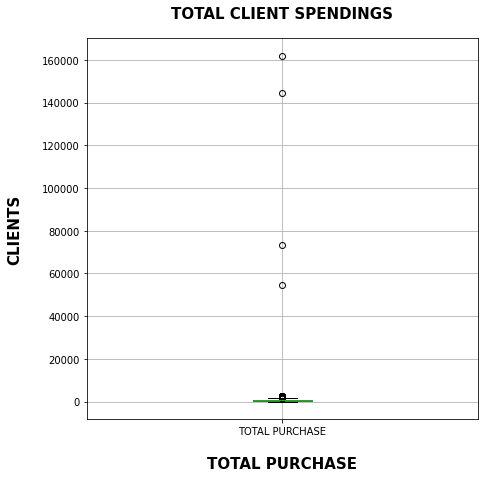

In [ ]:
# detecting 4 biggest clients via total spending amount
client_plot = tpc.groupby("client_id", as_index=False)[["price"]].sum().rename(columns={"client_id":"client", "price":"TOTAL PURCHASE"})

# visualizing via boxplot with outliers to show B2B clients
plt.figure(figsize=(7,7))
plt.xlabel("TOTAL PURCHASE", fontsize=15, fontweight="bold", labelpad=20)
plt.ylabel("CLIENTS", fontsize=15, fontweight="bold", labelpad=20)
plt.title("TOTAL CLIENT SPENDINGS", fontsize=15, fontweight="bold", pad=20)
client_plot.boxplot(vert=True)
plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Distribution depenses totales des clients.png")
plt.show()

#### B2C clients data set preparation

In [ ]:
# creating a list of supposedly B2B clients
btob_list = ["c_1609", "c_4958", "c_6714", "c_3454"]

# isolating B2C clients for analysis
btoc = tpc.copy()
btoc = btoc[~btoc["client_id"].isin(btob_list)]

# replacing TPC by only B2C clients
tpc = btoc.copy()

In [ ]:
# cl_bhv = annual expense + check out items

clients = pd.DataFrame(tpc.groupby(["client_id", "sex", "age", "client_type"]).sum()["price"]).reset_index()
clients.rename(columns={"price": "annual_expense"}, inplace=True)
nb_items = pd.DataFrame(tpc["client_id"].value_counts()).reset_index()
nb_items.columns=["client_id", "nb_checkout_items"]
cl_bhv = pd.merge(clients, nb_items)
cl_bhv

client_id sex  age client_type  annual_expense  nb_checkout_items
0          c_1   m   67      senior          300.65                 20
1         c_10   m   66      senior          586.18                 28
2        c_100   m   30     student          222.87                  6
3       c_1000   f   56      senior          980.02                 56
4       c_1001   m   40      active         1102.45                 58
...        ...  ..  ...         ...             ...                ...
8591     c_995   m   67      senior          119.08                  8
8592     c_996   f   52      senior          739.60                 42
8593     c_997   f   28     student          572.89                 23
8594     c_998   m   21     student         1527.69                 28
8595     c_999   m   58      senior          305.00                 22

[8596 rows x 6 columns]

In [ ]:
# un tableau nous donnant chaque identifiant de client avec son âge et la taille moyenne de ses paniers pour l'ensemble de ses achats

basket = pd.DataFrame(tpc.groupby(["client_id", "age", "client_type"]).mean()["basket_size"]).reset_index()
basket.rename(columns={"basket_size": "basket_mean"}, inplace=True)
basket["basket_mean"] = basket["basket_mean"].round(2)
basket

client_id  age client_type  basket_mean
0          c_1   67      senior         2.10
1         c_10   66      senior         2.50
2        c_100   30     student         2.33
3       c_1000   56      senior         1.96
4       c_1001   40      active         3.24
...        ...  ...         ...          ...
8591     c_995   67      senior         1.75
8592     c_996   52      senior         1.29
8593     c_997   28     student         3.00
8594     c_998   21     student         4.14
8595     c_999   58      senior         1.09

[8596 rows x 4 columns]

In [ ]:
monthly_basket_mean = tpc.pivot_table(index=["client_id", "age", "client_type"],
                          columns=["_monthnum"],
                          values=["basket_size"],
                          aggfunc=sum)

monthly_basket_mean = monthly_basket_mean.fillna(0)

monthly_basket_mean["monthly_basket_av"] = monthly_basket_mean.mean(axis=1)
monthly_basket_mean["monthly_basket_av"] = monthly_basket_mean.monthly_basket_av.round(2)
monthly_basket_mean = monthly_basket_mean.reset_index()
monthly_basket_mean.columns = ["client_id", "age", "client_type", "x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9", "x10", "x11", "x12", "monthly_basket_av"]
monthly_basket_mean.drop(columns=["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9", "x10", "x11", "x12"], inplace=True)
monthly_basket_mean

client_id  age client_type  monthly_basket_av
0          c_1   67      senior               3.50
1         c_10   66      senior               5.83
2        c_100   30     student               1.17
3       c_1000   56      senior               9.17
4       c_1001   40      active              15.67
...        ...  ...         ...                ...
8591     c_995   67      senior               1.17
8592     c_996   52      senior               4.50
8593     c_997   28     student               5.75
8594     c_998   21     student               9.67
8595     c_999   58      senior               2.00

[8596 rows x 4 columns]

### Products

#### Key figures

In [ ]:
# number of registered products
num_pr = len(pr["id_prod"].unique())
print("There are", {num_pr}, "registered products in total,")

# categories
cat_pr = set(pr["categ"].unique())
print("in", {len(cat_pr)}, "different categories:\n")
print("product categories:", cat_pr, "\n")

cat0_pr = (pr.loc[pr["categ"] == 0])["categ"].count()
cat1_pr = (pr.loc[pr["categ"] == 1])["categ"].count()
cat2_pr = (pr.loc[pr["categ"] == 2])["categ"].count()
total_cat_pr = cat0_pr + cat1_pr + cat2_pr
print(f"CATEGORY 0 = {cat0_pr} products\nCATEGORY 1 = {cat1_pr} products\nCATEGORY 2 = {cat2_pr} products\n--------------------------\nTOTAL of {total_cat_pr} products\n")


# visual
pr.groupby("categ", as_index=False)[["id_prod"]].count().rename(columns={"id_prod":"product count"})

There are {3286} registered products in total,
in {3} different categories:

product categories: {0, 1, 2} 

CATEGORY 0 = 2308 products
CATEGORY 1 = 739 products
CATEGORY 2 = 239 products
--------------------------
TOTAL of 3286 products



categ  product count
0      0           2308
1      1            739
2      2            239

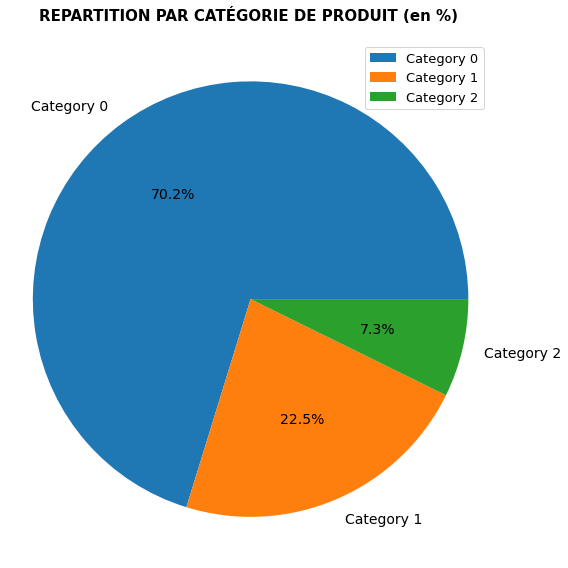

In [ ]:
# category distribution
plt.figure(figsize=(8,8))

labels= ["Category 0", "Category 1", "Category 2"]
sizes= pr["categ"].value_counts(normalize=True)
plt.pie(sizes, labels=labels, startangle=0, autopct="%1.1f%%", textprops={"fontsize": 14})

plt.title("REPARTITION PAR CATÉGORIE DE PRODUIT (en %)", fontsize=15, fontweight="bold", pad=20)
plt.axis("equal")
plt.legend(fontsize=13, loc=1)
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Repartition par categorie de produit (en %).png")
plt.show()

#### Unsold products

In [ ]:
# getting distinct PRODUCTS from Transaction data set
list_prod = set(tr["id_prod"].unique())
list_prod = sorted(list_prod)
#print(f"There are {list_prod["id_prod"].value_counts()} products sold")

# preparing a list of UNSOLD products
unsold = pr[~pr["id_prod"].isin(list_prod)]

# detecting UNSOLD products
print("There are", {unsold["id_prod"].count()}, "unsold products :\n")
print(unsold.count(), "\n")

# categories
cat_unsold = set(unsold["categ"].unique())
cat0_unsold = (unsold.loc[unsold["categ"] == 0])["categ"].count()
cat1_unsold = (unsold.loc[unsold["categ"] == 1])["categ"].count()
cat2_unsold = (unsold.loc[unsold["categ"] == 2])["categ"].count()
total_cat_unsold = cat0_unsold + cat1_unsold + cat2_unsold
print(f"CATEGORY 0 = {cat0_unsold} products\nCATEGORY 1 = {cat1_unsold} products\nCATEGORY 2 = {cat2_unsold} products\n--------------------------\nTOTAL of {total_cat_unsold} products\n")
# list of unsold products
print(f"Complete list of UNSOLD products :\n")
pr_unsold = sorted(set(unsold["id_prod"]))
pr_unsold

There are {22} unsold products :

id_prod    22
price      22
categ      22
dtype: int64 

CATEGORY 0 = 17 products
CATEGORY 1 = 2 products
CATEGORY 2 = 3 products
--------------------------
TOTAL of 22 products

Complete list of UNSOLD products :



['0_1014',
 '0_1016',
 '0_1025',
 '0_1062',
 '0_1119',
 '0_1318',
 '0_1620',
 '0_1624',
 '0_1645',
 '0_1780',
 '0_1800',
 '0_2308',
 '0_299',
 '0_310',
 '0_322',
 '0_510',
 '0_525',
 '1_0',
 '1_394',
 '2_72',
 '2_86',
 '2_87']

In [ ]:
# number of sold products per category
unsold.groupby("categ", as_index=False)[["id_prod"]].count().rename(columns={"id_prod":"product count"})

categ  product count
0      0             17
1      1              2
2      2              3

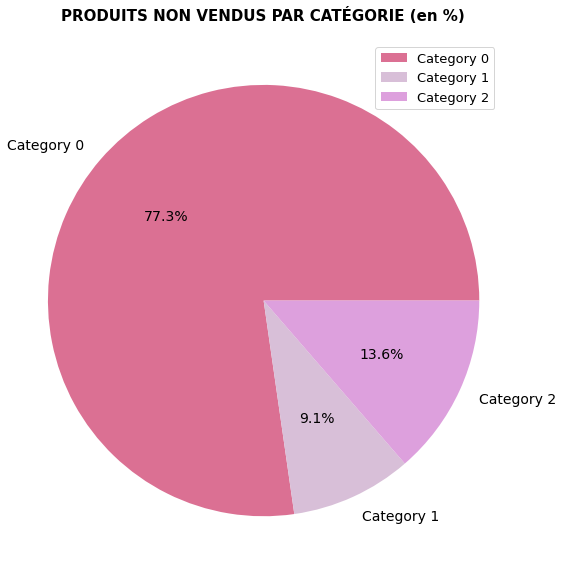

In [ ]:
df_unsold = pd.DataFrame(unsold.groupby("categ")[["id_prod"]].count()).copy()
df_unsold.reset_index(inplace=True)
df_unsold

plt.figure(figsize=(8,8))

labels= ["Category 0", "Category 1", "Category 2"]
color= ["palevioletred","thistle","plum"]
sizes= df_unsold["id_prod"]
plt.pie(sizes, labels=labels, colors=color, startangle=0, autopct="%1.1f%%", textprops={"fontsize": 14})

plt.title("PRODUITS NON VENDUS PAR CATÉGORIE (en %)", fontsize=15, fontweight="bold", pad=20)
plt.axis("equal")
plt.legend(fontsize=13, loc=1)
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Repartition par categorie de produit NON-vendus (en %).png")
plt.show()

#### Sold products

In [ ]:
# detecting SOLD products
sold = pr[~pr["id_prod"].isin(pr_unsold)]

print("There are", {sold.id_prod.count()}, "sold products :\n")
print(sold.count(), "\n")
print(f"TOTAL of {len(sold.id_prod) + len(unsold)} = {len(sold.id_prod)} + {len(unsold)} \n")

# categories
cat_sold = set(sold["categ"].unique())
cat0_sold = (sold.loc[sold["categ"] == 0])["categ"].count()
cat1_sold = (sold.loc[sold["categ"] == 1])["categ"].count()
cat2_sold = (sold.loc[sold["categ"] == 2])["categ"].count()
total_cat_sold = cat0_sold + cat1_sold + cat2_sold
print(f"CATEGORY 0 = {cat0_sold} products\nCATEGORY 1 = {cat1_sold} products\nCATEGORY 2 = {cat2_sold} products\n--------------------------\nTOTAL of {total_cat_sold} products\n")

There are {3264} sold products :

id_prod    3264
price      3264
categ      3264
dtype: int64 

TOTAL of 3286 = 3264 + 22 

CATEGORY 0 = 2291 products
CATEGORY 1 = 737 products
CATEGORY 2 = 236 products
--------------------------
TOTAL of 3264 products



In [ ]:
sold.groupby("categ", as_index=False)[["id_prod"]].count().rename(columns={"id_prod":"product count"})

categ  product count
0      0           2291
1      1            737
2      2            236

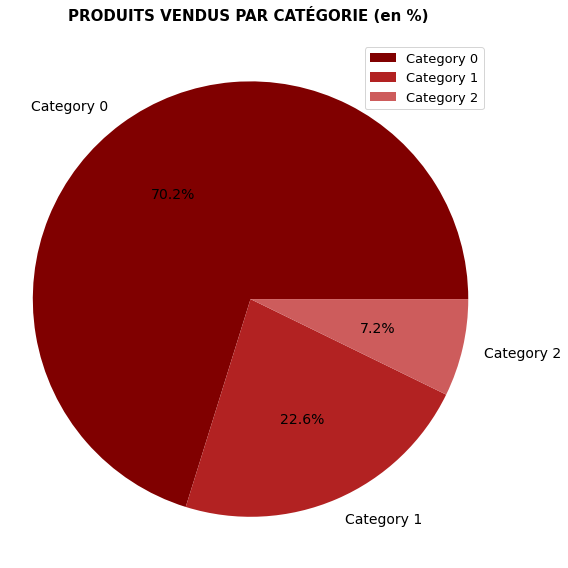

In [ ]:
df_sold = pd.DataFrame(sold.groupby("categ")[["id_prod"]].count()).copy()
df_sold.reset_index(inplace=True)
df_sold

plt.figure(figsize=(8,8))

labels= ["Category 0", "Category 1", "Category 2"]
color= ["maroon","firebrick","indianred"]
sizes= df_sold["id_prod"]
plt.pie(sizes, labels=labels, colors=color, startangle=0, autopct="%1.1f%%", textprops={"fontsize": 14})

plt.title("PRODUITS VENDUS PAR CATÉGORIE (en %)", fontsize=15, fontweight="bold", pad=20)
plt.axis("equal")
plt.legend(fontsize=13, loc=1)
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Repartition par categorie de produit vendus (en %).png")
plt.show()

#### Sold vs Unsold

In [ ]:
# preparing a list of sold products
list_sold = sold["id_prod"].unique()

# creating a bolean column to identify SOLD from UNSOLD products
pr["is_sold"] = pr["id_prod"].isin(list_sold)

# verification
sp = pr.loc[pr["is_sold"] == True].count()
sp = sp["id_prod"]

up = pr.loc[pr["is_sold"] == False].count()
up = up["id_prod"]

total_prod = sp + up

print(f"To verify once more,\n\nThere are indeed {up} UNSOLD products and {sp} SOLD products.\nMaking a total number of {total_prod} like the Products data set confirms:\n\nid_prod COUNT = {pr.id_prod.count()}")

To verify once more,

There are indeed 22 UNSOLD products and 3264 SOLD products.
Making a total number of 3286 like the Products data set confirms:

id_prod COUNT = 3286


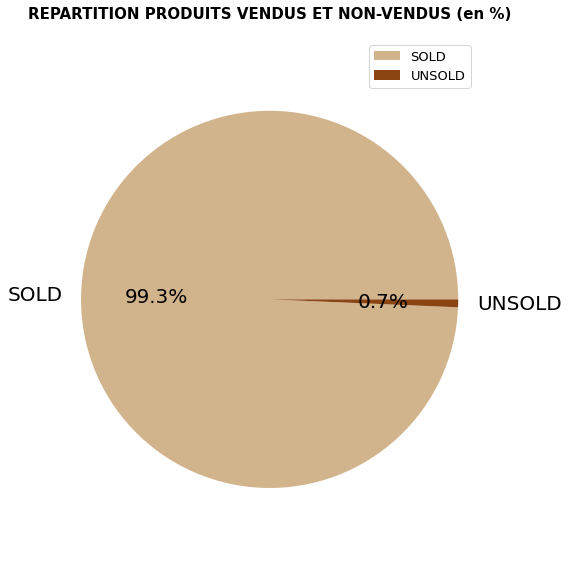

In [ ]:
plt.figure(figsize=(8,8))

labels= ["SOLD", "UNSOLD"]
color= ["tan","saddlebrown"]
sizes= pr["is_sold"].value_counts(normalize=True)
plt.pie(sizes, labels=labels, colors=color, startangle=0, autopct="%1.1f%%", textprops={"fontsize": 20})

plt.title("REPARTITION PRODUITS VENDUS ET NON-VENDUS (en %)", fontsize=15, fontweight="bold", pad=20)
plt.axis("equal")
plt.legend(fontsize=13, loc=1)
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Repartition category produit vendus et NON-vendus (en %).png")
plt.show()

Donc nous avons plus d'un livre sur 200 qui ne se vend pas.

### Transactions

#### Key figures

In [ ]:
# number of total clients
cl_tpc = len(tpc["client_id"].unique())
num_cl_tpc = len(tpc["client_id"])
print("There are", {cl_tpc}, "registered clients in total, and", {num_cl_tpc}, "recorded in transactions")

# counting total male and female clients
genre_tpc = set(tpc["sex"].unique())
print(f"in {len(genre_tpc)} different genres : {genre_tpc} \n")
# other option: cl.sex.count()

sf_tpc = (tpc.loc[tpc["sex"] == "f"])["sex"].count()
sm_tpc = (tpc.loc[tpc["sex"] == "m"])["sex"].count()
total_genre_tpc = sf_tpc + sm_tpc
print(f"Female = {sf_tpc} clients\nMale = {sm_tpc} clients\n--------------------------\nTOTAL of {total_genre_tpc} clients\n")

tpc.groupby("sex", as_index=False)[["client_id"]].count().rename(columns={"client_id":"transaction count"})

There are {8596} registered clients in total, and {313651} recorded in transactions
in 2 different genres : {'m', 'f'} 

Female = 163102 clients
Male = 150549 clients
--------------------------
TOTAL of 313651 clients



sex  transaction count
0   f             163102
1   m             150549

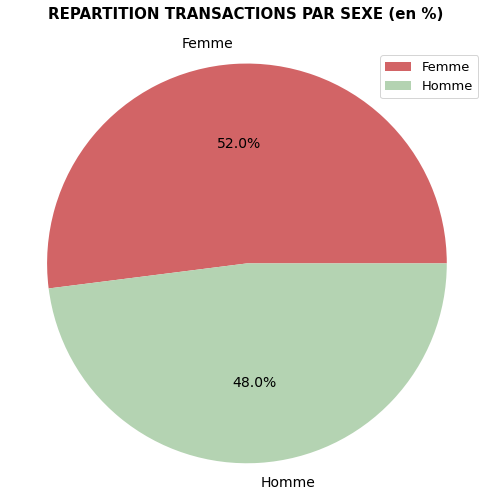

In [ ]:
# male vs female
plt.figure(figsize=(7,7))

labels= ["Femme", "Homme"]
sizes= tpc["sex"].value_counts(normalize=True)
plt.pie(sizes, labels=labels, colors=sex_color, startangle=0, autopct="%1.1f%%", textprops={"fontsize": 14})

plt.title("REPARTITION TRANSACTIONS PAR SEXE (en %)", fontsize=15, fontweight="bold", pad=30)
plt.axis("equal")
plt.legend(fontsize=13, loc=1)
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Repartition transactions par sex.png")
plt.show()

In [ ]:
# number of registered products
pr_tpc = len(tpc["id_prod"].unique())
num_pr_tpc = len(tpc["id_prod"])
print("There are", {pr_tpc}, "registered products in total and", {num_pr_tpc}, "recorded in transactions")

# categories
cat_tpc = set(tpc["categ"].unique())
print("in", {len(cat_tpc)}, "different categories:\n")
print("product categories:", cat_tpc, "\n")

cat0_tpc = (tpc.loc[tpc["categ"] == 0])["categ"].count()
cat1_tpc = (tpc.loc[tpc["categ"] == 1])["categ"].count()
cat2_tpc = (tpc.loc[tpc["categ"] == 2])["categ"].count()
total_cat_tpc = cat0_tpc + cat1_tpc + cat2_tpc
print(f"CATEGORY 0 = {cat0_tpc} products\nCATEGORY 1 = {cat1_tpc} products\nCATEGORY 2 = {cat2_tpc} products\n--------------------------\nTOTAL of {total_cat_tpc} products\n")

# visual
tpc.groupby("categ", as_index=False)[["id_prod"]].count().rename(columns={"id_prod":"transaction count"})

There are {3262} registered products in total and {313651} recorded in transactions
in {3} different categories:

product categories: {0, 1, 2} 

CATEGORY 0 = 195270 products
CATEGORY 1 = 102625 products
CATEGORY 2 = 15756 products
--------------------------
TOTAL of 313651 products



categ  transaction count
0      0             195270
1      1             102625
2      2              15756

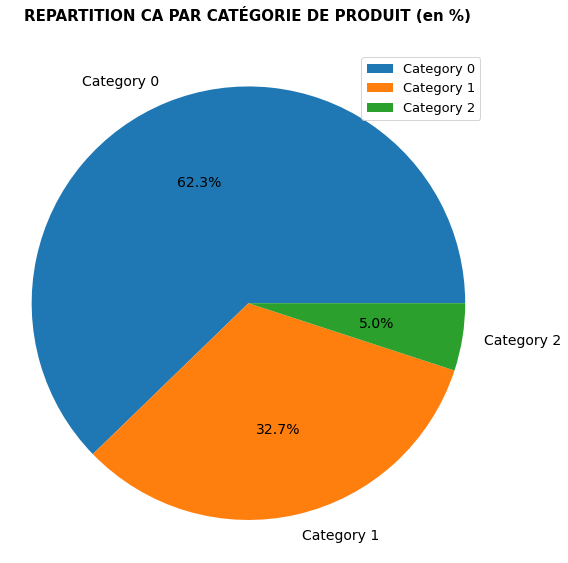

In [ ]:
# category distribution
plt.figure(figsize=(8,8))

labels= ["Category 0", "Category 1", "Category 2"]
sizes= tpc["categ"].value_counts(normalize=True)
plt.pie(sizes,labels=labels, startangle=0, autopct="%1.1f%%", textprops={"fontsize": 14})

plt.title("REPARTITION CA PAR CATÉGORIE DE PRODUIT (en %)", fontsize=15, fontweight="bold", pad=30)
plt.axis("equal")
plt.legend(fontsize=13, loc=1)
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Repartition transactions par categorie.png")
plt.show()

#### Age distribution

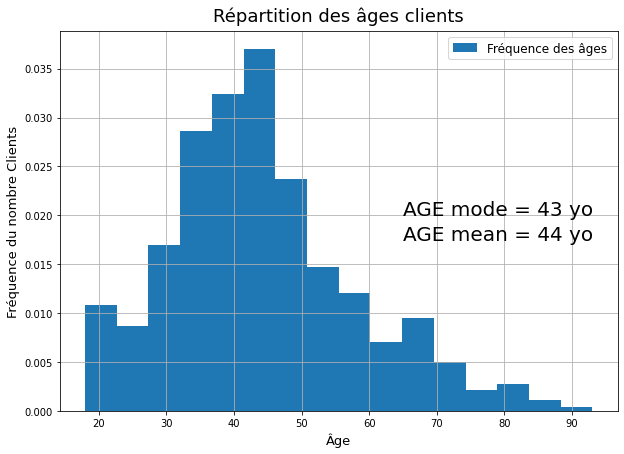

In [ ]:
plt.figure(figsize=(10,7))

# Histogramme de la variable âge des clients
repartition_age_tpc = tpc['age'].hist(density = True, grid=True, bins=16)

# Titre
plt.title("Répartition des âges clients",loc="center",pad=10,color='black',fontsize=18,fontweight='normal')

# Titre des axes
plt.xlabel('Âge', color='black', fontsize=13)
plt.ylabel('Fréquence du nombre Clients', color='black', fontsize=13)

# Graduation des axes
plt.xticks(color='black', rotation='horizontal')
plt.yticks(color='black')

# Légende
plt.legend(["Fréquence des âges"], loc="upper right", fontsize=12)

# Text
plt.text(65, .0175, "AGE mean = " + str(math.floor(tpc["age"].mean())) + " yo", fontsize=20)
plt.text(65, .02, "AGE mode = " + str(math.floor(tpc["age"].mode())) + " yo", fontsize=20)

# Sauvegarde graphique
# plt.savefig("img/ageClients.png")

#Affichage
plt.show()

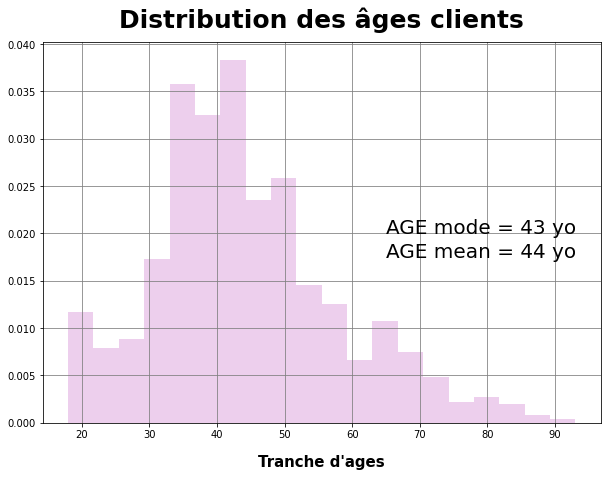

In [ ]:
plt.figure(figsize=(10,7))

# Visualisation (Histogramme)de la distribution de l'âge des clients
tpc['age'].hist(density=True, alpha=0.5, bins=20, color="plum")

# settings
plt.xlabel("Tranche d'ages", fontsize=15, fontweight="bold", labelpad=15)
plt.title('Distribution des âges clients', fontsize=25, fontweight="bold", pad=15)
plt.grid(color="gray")

# Text
plt.text(65, .0175, "AGE mean = " + str(math.floor(tpc["age"].mean())) + " yo", fontsize=20)
plt.text(65, .02, "AGE mode = " + str(math.floor(tpc["age"].mode())) + " yo", fontsize=20)

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Repartition age clients actifs (table TR).png")
plt.show()

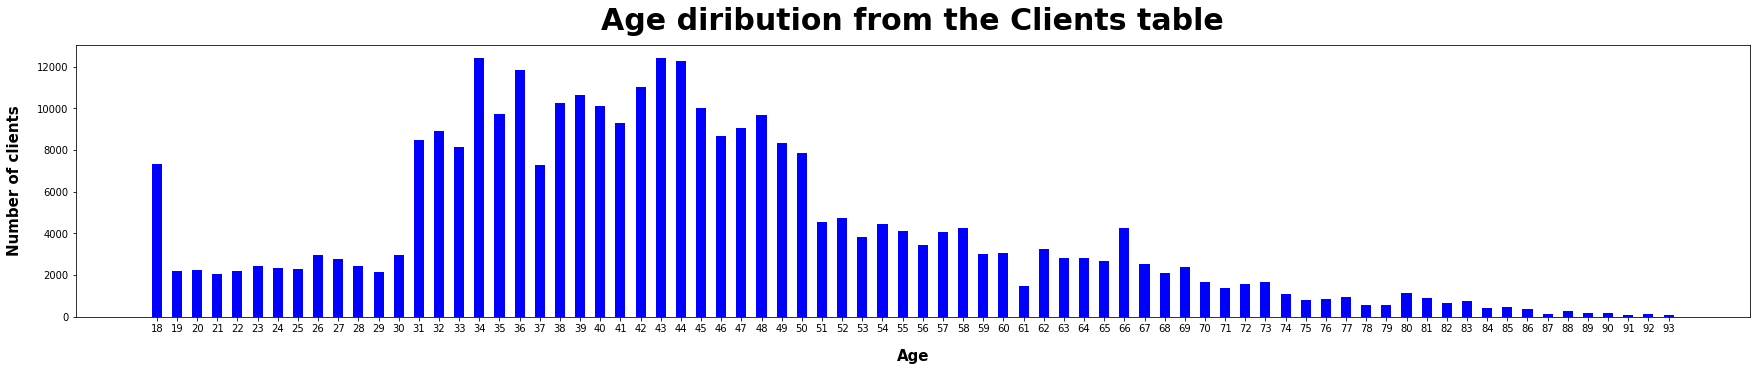

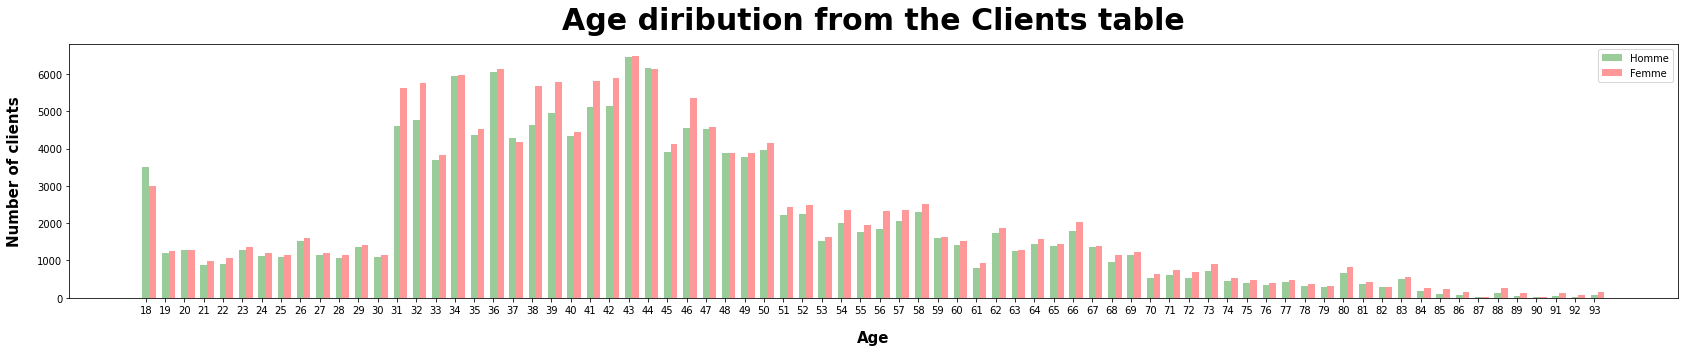

In [ ]:
homme_df_tpc = tpc[tpc["sex"] == "m"].copy()
femme_df_tpc = tpc[tpc["sex"] == "f"].copy()

#Visualisation de la distribtion des clients par age
#Visualisation de la comparaison entre les hommes et les femmes par rapport a leur age
effectifs_tpc = tpc["age"].value_counts()
modalites_tpc = effectifs_tpc.index # l'index de effectifs contient les modalités

plt.figure(figsize=(30, 5))
# gs = gridspec.GridSpec(1, 2, width_ratios=[.5, 5]) 
# ax1 = plt.subplot(gs[0])
# ax1.pie([homme_df["age"].count(), femme_df["age"].count()], labels = ['Homme', 'Femme'], autopct='%1.1f%%')
# ax2 = plt.subplot(gs[1])
# ax2.axis('off')
# plt.xticks(rotation=90)
xticks = effectifs_tpc.index
ticklabels = effectifs_tpc.index
plt.xticks(xticks, ticklabels)
plt.xlabel("Age", fontsize=15, fontweight="bold", labelpad=15)
plt.ylabel("Number of clients", fontsize=15, fontweight="bold", labelpad=15)
plt.title("Age diribution from the Clients table", fontsize=30, fontweight="bold", pad=15)
plt.bar(effectifs_tpc.index, effectifs_tpc, 0.5, color='b' )
plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Distribution age clients actifs (table TR).png")

effectifs_femme_tpc = femme_df_tpc["age"].value_counts()
modalites_femme_tpc = effectifs_femme_tpc.index # l'index de effectifs contient les modalités
effectifs_homme_tpc = homme_df_tpc["age"].value_counts()
modalites_homme_tpc = effectifs_homme_tpc.index # l'index de effectifs contient les modalités

fig = plt.figure(2, figsize=(23.5, 5))
bar_width = 0.35
opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(modalites_homme_tpc, effectifs_homme_tpc, bar_width, alpha=opacity, color='g', error_kw=error_config, label='Homme')
rects2 = plt.bar(modalites_homme_tpc + bar_width, effectifs_femme_tpc, bar_width, alpha=opacity, color='r', error_kw=error_config, label='Femme')

plt.xlabel("Age", fontsize=15, fontweight="bold", labelpad=15)
plt.ylabel("Number of clients", fontsize=15, fontweight="bold", labelpad=15)
plt.title("Age diribution from the Clients table", fontsize=30, fontweight="bold", pad=15)
xticks = effectifs_tpc.index
ticklabels = effectifs_tpc.index
plt.xticks(xticks, ticklabels)
plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Distribution age clients actifs par sex (table TR).png")

plt.legend()
plt.tight_layout()

plt.show()

## Bivariate analysis

### Évolution du CA dans le temps

In [ ]:
tpc.groupby("month", as_index=False)[["price"]].sum().rename(columns={"price":"CA"})

month         CA
0       March  443036.49
1       April  436328.29
2         May  451398.50
3        June  444932.39
4        July  445699.69
5      August  443269.06
6   September  466880.20
7     October  295314.29
8    November  475220.68
9    December  484819.54
10    January  486629.48
11   February  490215.53

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


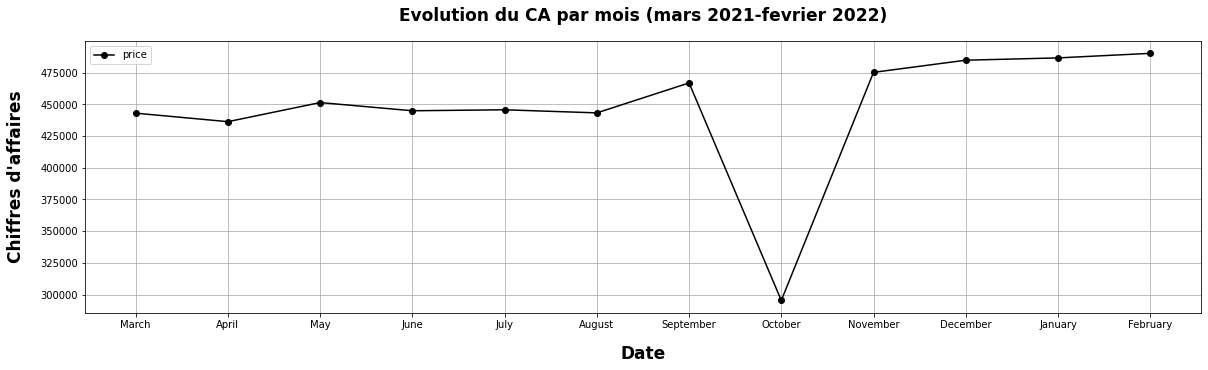

In [ ]:
tpc.groupby("month")[["price"]].sum().plot(rot=0, figsize=(20,5), marker='o', color="black")
plt.title("Evolution du CA par mois (mars 2021-fevrier 2022)", fontsize=17, fontweight="bold", pad=20)
plt.xlabel("Date", labelpad=15, fontsize=17, fontweight="bold")
plt.ylabel("Chiffres d'affaires", labelpad=15, fontsize=17, fontweight="bold")
ax1 = plt.subplot()
ax1.set_xticks(np.arange(len(tpc.month.unique())))
ax1.set_xticklabels(tpc.month.unique())
plt.grid(True)

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Evolution CA (mars 2021 - fevrier 2022).png")
plt.show();

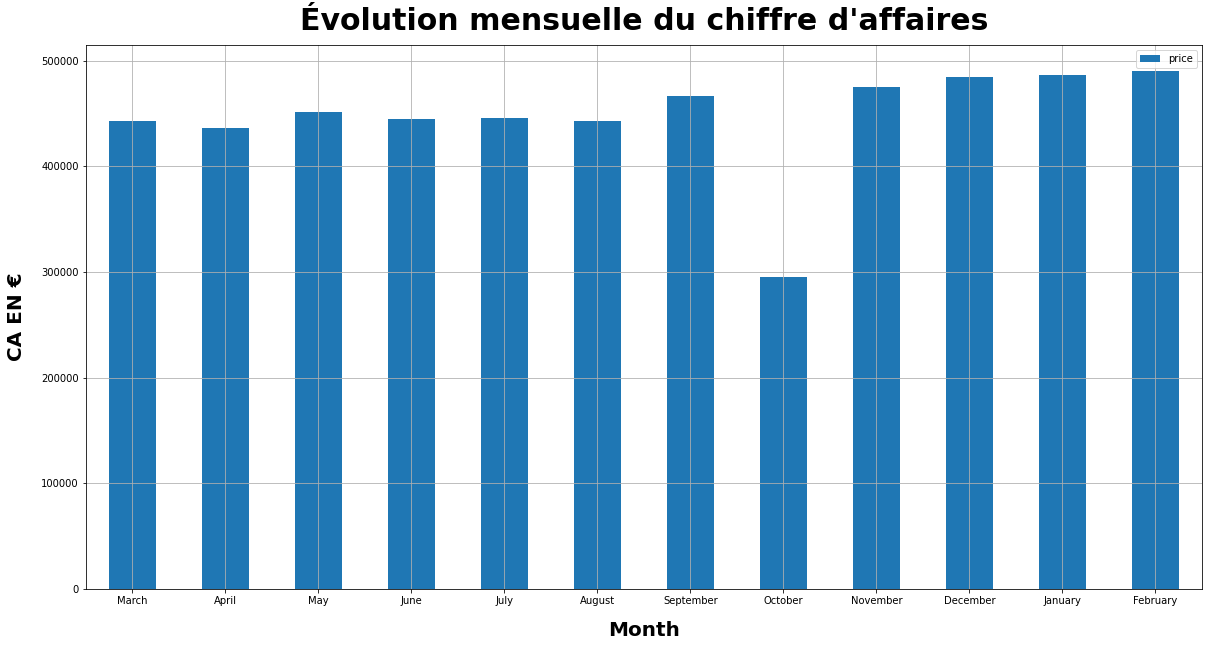

In [ ]:
# histogramme to show
ca = tpc.groupby(["month"])[["price"]].sum()

ca.plot(kind="bar", figsize=(20, 10), rot=0)

# histogramme settings
plt.title("Évolution mensuelle du chiffre d'affaires", fontsize=30, fontweight="bold", pad=15)
plt.xlabel("Month", fontsize=20, fontweight="bold", labelpad=15)
plt.ylabel("CA EN €", fontsize=20, fontweight="bold", labelpad=15)
plt.grid(True)

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Evolution mensuelle CA.png")
plt.show()

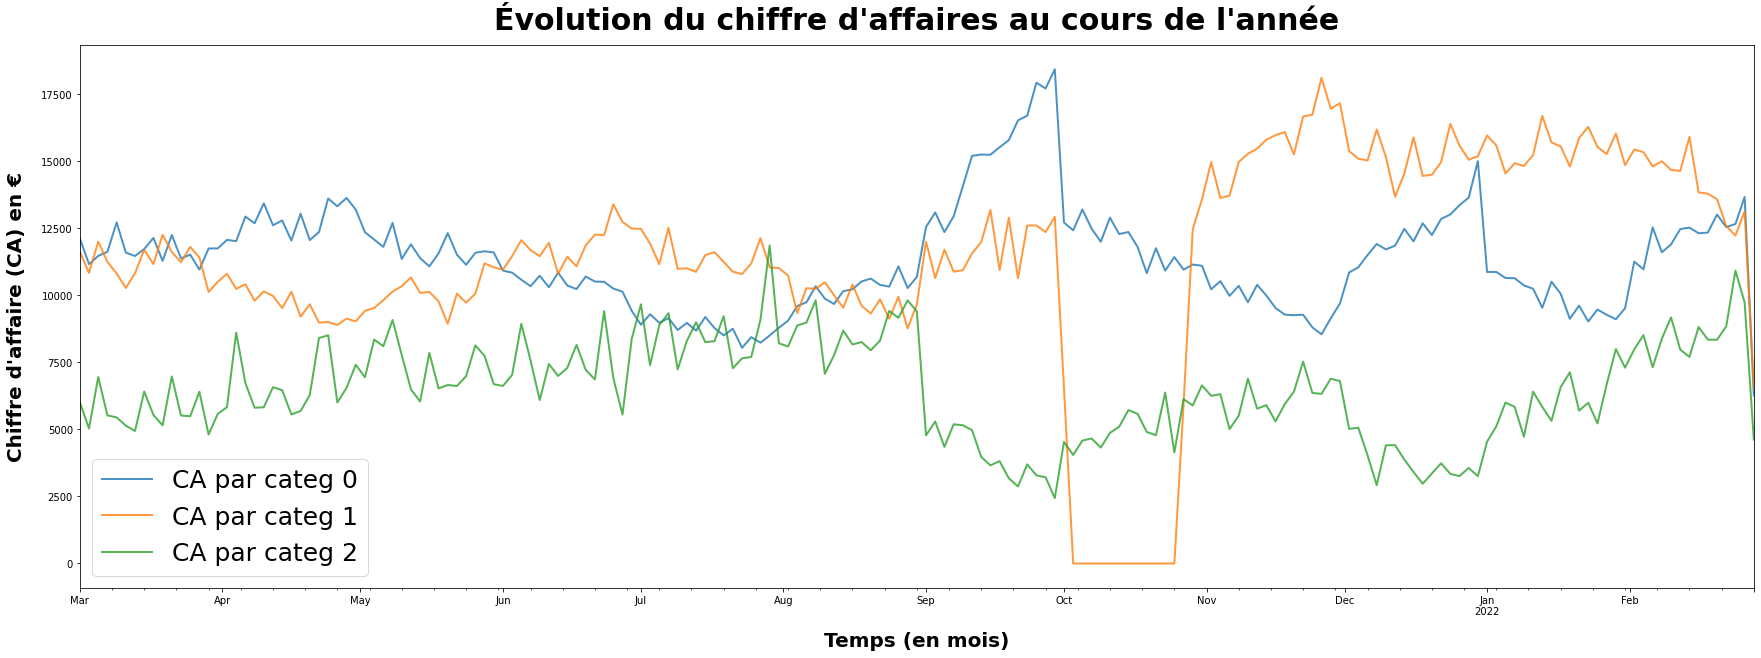

In [ ]:
tpc['sales_date'] = pd.to_datetime(tpc['date'], errors='coerce')

tpcdex = tpc.copy()

tpcdex.set_index('sales_date', inplace=True)

# Trier sur la colonne date 
tpc_date = tpcdex.sort_index()

# Regardant le CA par catégorie (moyenne 2 jours)
cat_0 = tpc_date[tpc_date['categ'] == 0]
cat_1 = tpc_date[tpc_date['categ'] == 1]
cat_2 = tpc_date[tpc_date['categ'] == 2]

# plot 
plt.figure(figsize=(30,10))

cat_0["2021":"2022"]['price'].resample('2d').sum().plot(label="CA par categ 0", lw=2, ls='-', alpha=0.8)
cat_1["2021":"2022"]['price'].resample('2d').sum().plot(label="CA par categ 1", lw=2, ls='-', alpha=0.8)
cat_2["2021":"2022"]['price'].resample('2d').sum().plot(label="CA par categ 2", lw=2, ls='-', alpha=0.8)

# graph settings
plt.title("Évolution du chiffre d'affaires au cours de l'année", fontsize=30, fontweight="bold", pad=15)
plt.xlabel("Temps (en mois)", fontsize=20, fontweight="bold", labelpad=15)
plt.ylabel("Chiffre d'affaire (CA) en €", fontsize=20, fontweight="bold", labelpad=15)
plt.legend(fontsize=25, loc="lower left")

# save plots
plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Evolution CA au cours de l'annéee.png")
plt.show()

### Zoom sur le CA du mois d'octobre

In [ ]:
octobre = tpc[tpc.month=="October"].pivot_table(index=["date"], columns=["categ"], values=["price"], aggfunc=sum).reset_index().fillna(0)
octobre.columns=["date", "categorie 0", "categorie 1", "categorie 2"]; octobre

date  categorie 0  categorie 1  categorie 2
0  2021-10-01      6258.12      6530.99      2752.09
1  2021-10-02      6450.52         0.00      1781.00
2  2021-10-03      6231.86         0.00      1827.13
3  2021-10-04      6187.96         0.00      2217.94
4  2021-10-05      6181.62         0.00      2920.56
5  2021-10-06      7014.93         0.00      1660.50
6  2021-10-07      5932.98         0.00      1715.08
7  2021-10-08      6552.44         0.00      2946.05
8  2021-10-09      6080.92         0.00      2268.30
9  2021-10-10      5911.37         0.00      2053.54
10 2021-10-11      6570.66         0.00      2932.21
11 2021-10-12      6321.25         0.00      1937.27
12 2021-10-13      6242.93         0.00      2579.83
13 2021-10-14      6036.47         0.00      2517.68
14 2021-10-15      6133.32         0.00      2512.41
15 2021-10-16      6222.32         0.00      3206.01
16 2021-10-17      6007.65         0.00      3015.77
17 2021-10-18      5795.06         0.00      2562.99
18 2021-10-19      5397.71         0.00      2020.38
19 2021-10-20      5425.49         0.00      2883.13
20 2021-10-21      6104.47         0.00      2941.01
21 2021-10-22      5646.98         0.00      1841.49
22 2021-10-23      5299.03         0.00      2731.85
23 2021-10-24      5618.87         0.00      3640.57
24 2021-10-25      5464.06         0.00      2200.23
25 2021-10-26      5957.17         0.00      1938.98
26 2021-10-27      5484.20         0.00      3845.90
27 2021-10-28      5470.22      5934.03      2280.37
28 2021-10-29      5768.92      6061.82      3504.56
29 2021-10-30      5375.39      6406.92      2386.54
30 2021-10-31      5706.80      6958.25      2949.22

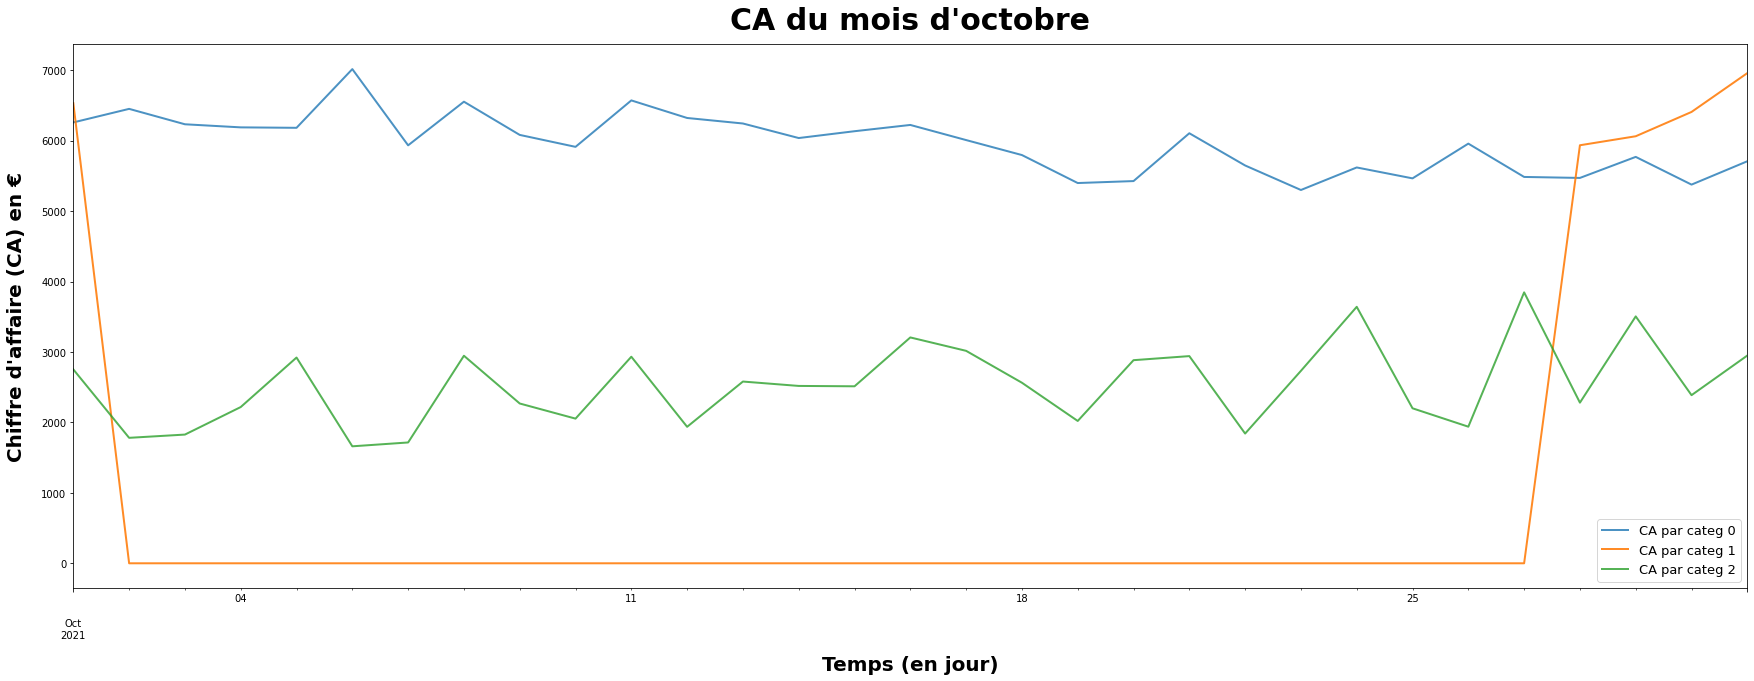

In [ ]:
plt.figure(figsize=(30,10))

# Focus sur le mois d'octobre: par categorie
cat_0.loc["2021-10"]['price'].resample('d').sum().plot(label="CA par categ 0", lw=2, ls='-', alpha=0.8)
cat_1.loc["2021-10"]['price'].resample('d').sum().plot(label="CA par categ 1", lw=2, ls='-', alpha=0.9)
cat_2.loc["2021-10"]['price'].resample('d').sum().plot(label="CA par categ 2", lw=2, ls='-', alpha=0.8)

# graph settings
plt.title("CA du mois d'octobre", fontsize=30, fontweight="bold", pad=15)
plt.xlabel("Temps (en jour)", fontsize=20, fontweight="bold", labelpad=15)
plt.ylabel("Chiffre d'affaire (CA) en €", fontsize=20, fontweight="bold", labelpad=15)
plt.legend(fontsize=13, loc='lower right')

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/CA mois octobre.png")
plt.show()

### Analyse CA par jour

In [ ]:
tpc.groupby(["day_name"], as_index=False)[["price"]].sum().rename(columns={"price":"CA"})

day_name         CA
0     Monday  778723.48
1    Tuesday  761800.18
2  Wednesday  755194.53
3   Thursday  769540.44
4     Friday  778399.66
5   Saturday  759559.30
6     Sunday  760526.55

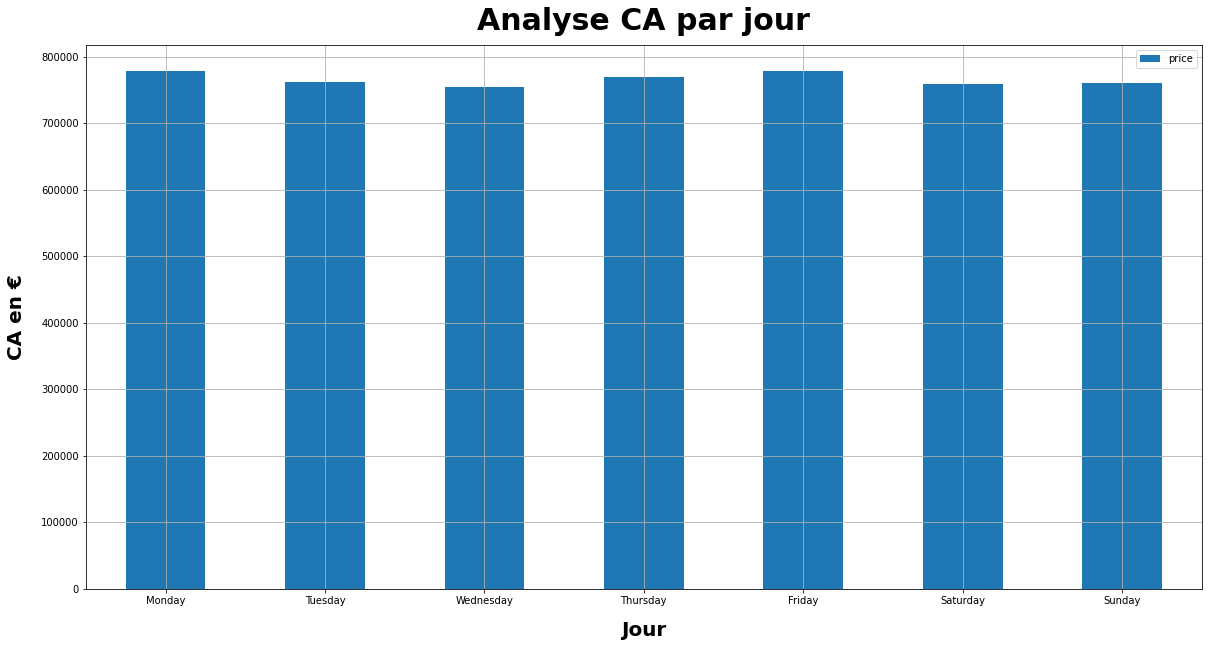

In [ ]:
# histogramme to show
ca = tpc.groupby(["day_name"])[["price"]].sum()

ca.plot(kind="bar", figsize=(20, 10), rot=0)

# histogramme settings
plt.title("Analyse CA par jour", fontsize=30, fontweight="bold", pad=15)
plt.xlabel("Jour", fontsize=20, fontweight="bold", labelpad=15)
plt.ylabel("CA en €", fontsize=20, fontweight="bold", labelpad=15)
plt.grid(True)

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Analyse CA par jour.png")
plt.show()

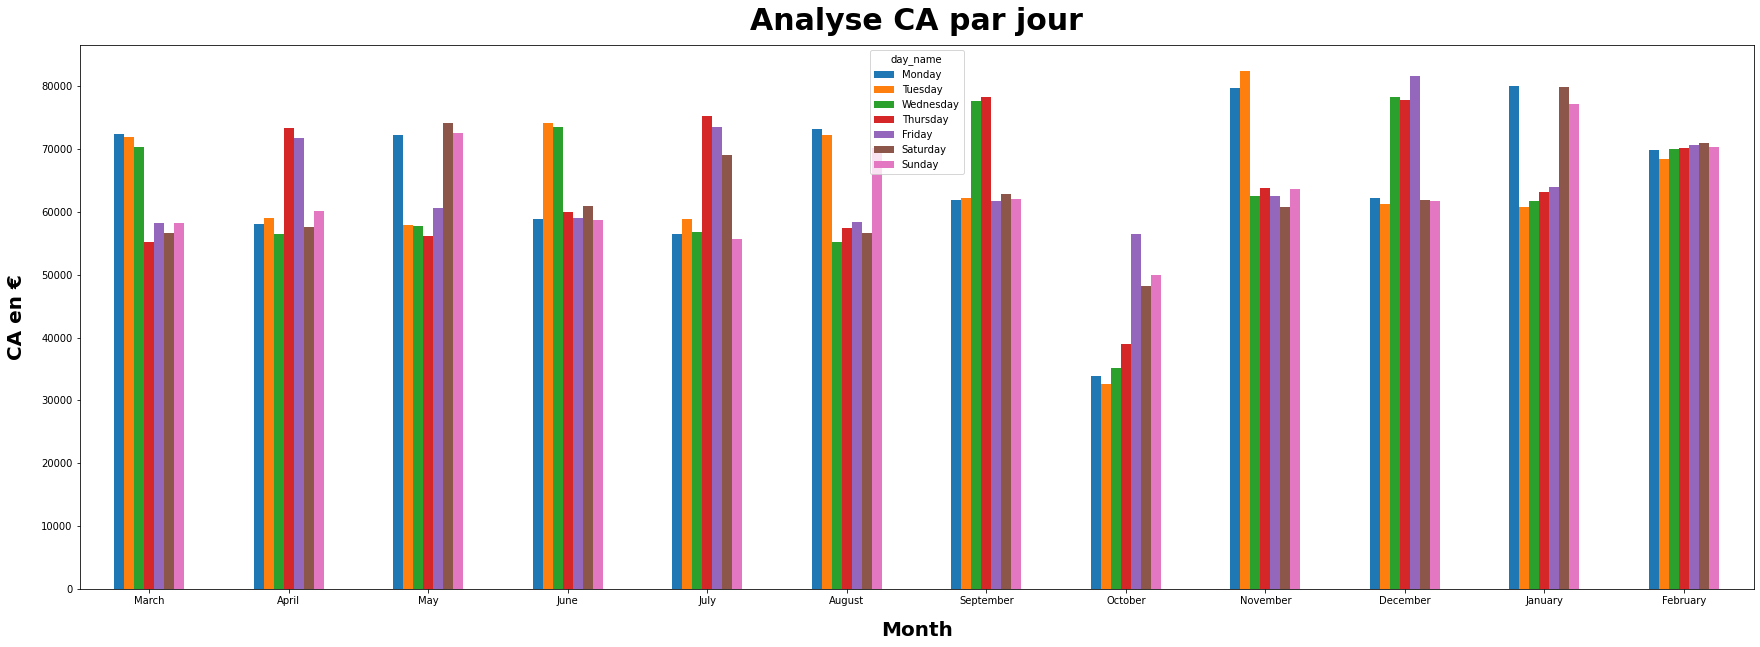

In [ ]:
# bar chart to show
tpc.groupby(["month", "day_name"]).sum().unstack().plot(kind="bar",y="price", rot=0, figsize=(30,10))

# bar chart settings
plt.title("Analyse CA par jour", fontsize=30, fontweight="bold", pad=15)
plt.xlabel("Month", fontsize=20, fontweight="bold", labelpad=15)
plt.ylabel("CA en €", fontsize=20, fontweight="bold", labelpad=15)

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Analyse CA par semaine au cours de l'année.png")
plt.show()

### Evolution du CA dans le temps par catergorie de produit

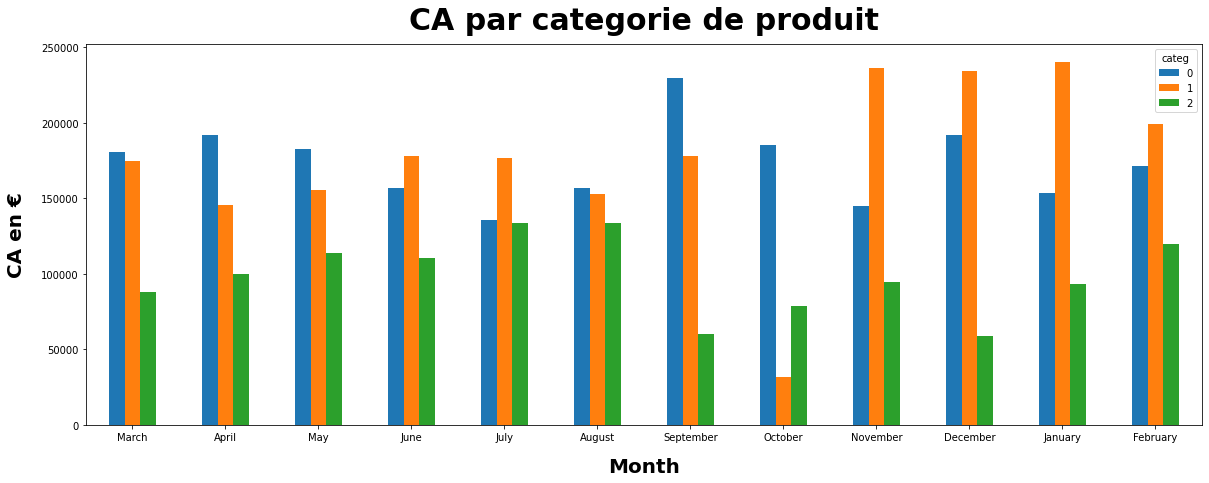

In [ ]:
# bar chart to show
tpc.groupby(["month","categ"]).sum().unstack().plot(kind="bar",y="price", rot=0, figsize=(20,7))

# bar chart settings
plt.title("CA par categorie de produit", fontsize=30, fontweight="bold", pad=15)
plt.xlabel("Month", fontsize=20, fontweight="bold", labelpad=15)
plt.ylabel("CA en €", fontsize=20, fontweight="bold", labelpad=15)

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Aperçu CA par categorie de produit au cours de l'année.png")
plt.show()

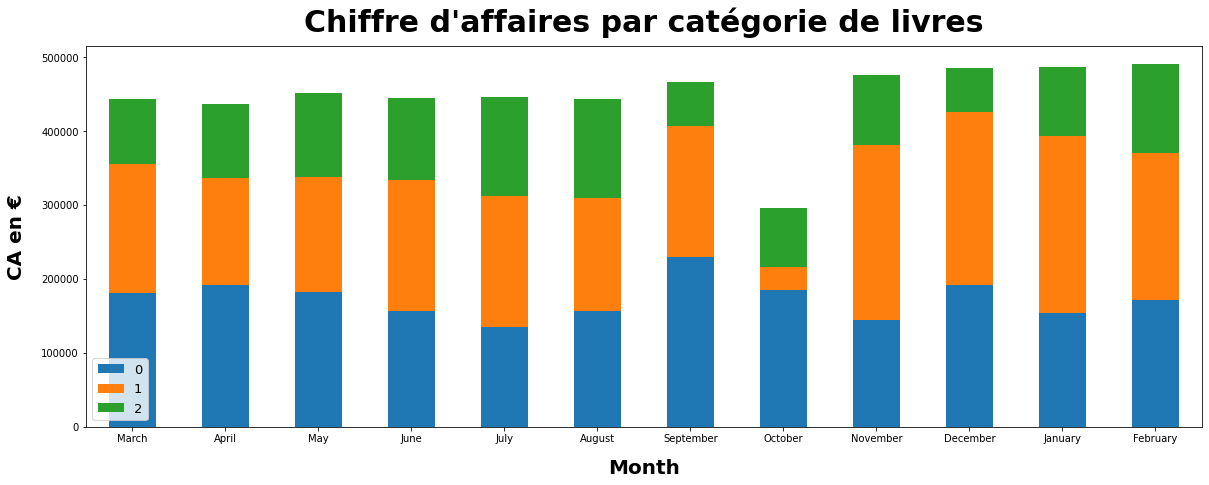

In [ ]:
# bar chart to show
tpc.groupby(["month","categ"]).sum().unstack().plot(kind="bar",y="price", rot=0, figsize=(20,7), stacked=True)

# bar chart settings
plt.title("Chiffre d'affaires par catégorie de livres", fontsize=30, fontweight="bold", pad=15)
plt.xlabel("Month", fontsize=20, fontweight="bold", labelpad=15)
plt.ylabel("CA en €", fontsize=20, fontweight="bold", labelpad=15)
plt.legend(loc="lower left", fontsize=13)

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/CA par categorie de produit au cours de l'année.png")
plt.show()

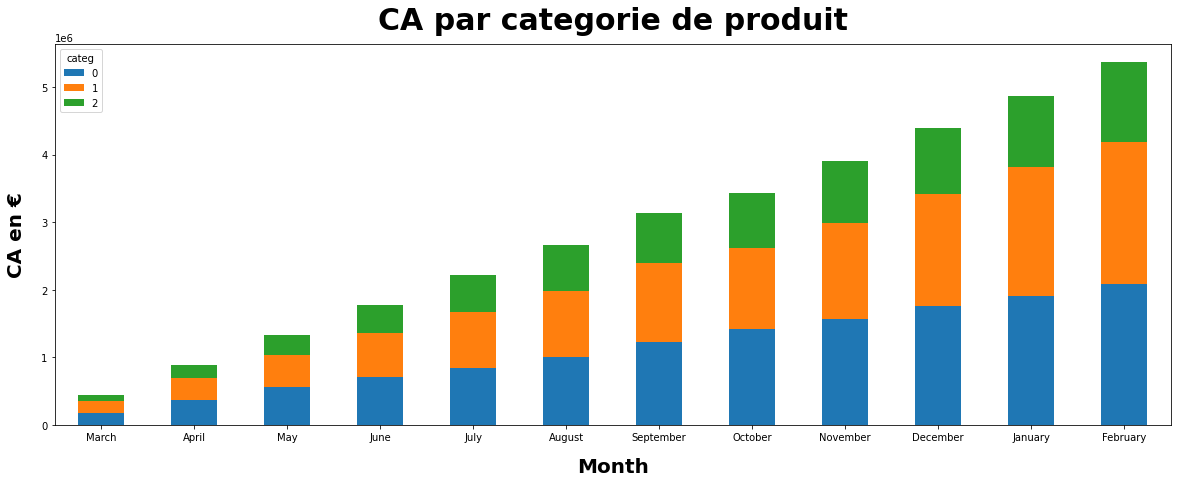

In [ ]:
# bar chart to show
tpc.groupby(["month","categ"]).sum().groupby(level=[1]).cumsum().unstack().plot(kind="bar",y="price", rot=0, figsize=(20,7), stacked=True)

# bar chart settings
plt.title("CA par categorie de produit", fontsize=30, fontweight="bold", pad=15)
plt.xlabel("Month", fontsize=20, fontweight="bold", labelpad=15)
plt.ylabel("CA en €", fontsize=20, fontweight="bold", labelpad=15)
plt.show()

### Parts du chiffre d'affaires et ventes par catégorie de livres

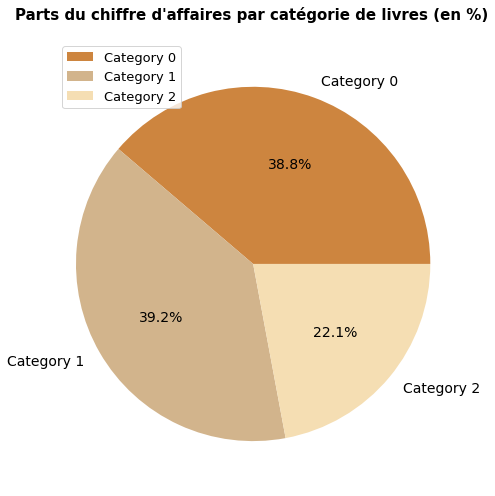

In [ ]:
# CA
cat_ca = pd.DataFrame(tpc.groupby("categ")[["price"]].sum()).copy()
cat_ca.reset_index(inplace=True)
cat_ca

plt.figure(figsize=(7,7))

labels= ["Category 0", "Category 1", "Category 2"]
color= ["peru", "tan", "wheat"]
sizes= cat_ca["price"]
plt.pie(sizes, labels=labels, colors=color, startangle=0, autopct="%1.1f%%", textprops={"fontsize": 14})

plt.title("Parts du chiffre d'affaires par catégorie de livres (en %)", fontsize=15, fontweight="bold", pad=20)
plt.axis("equal")
plt.legend(fontsize=13, loc="upper left")
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Repartition CA par categorie (en %).png")
plt.show()

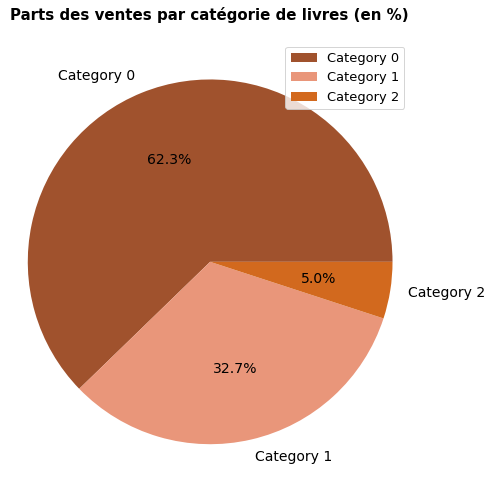

In [ ]:
# ventes
cat_ventes = pd.DataFrame(tpc.groupby("categ")[["price"]].count()).copy()
cat_ventes.reset_index(inplace=True)
cat_ventes

plt.figure(figsize=(7,7))

labels= ["Category 0", "Category 1", "Category 2"]
color = ["sienna", "darksalmon", "chocolate"]
sizes= cat_ventes["price"]
plt.pie(sizes, labels=labels, colors=color, startangle=0, autopct="%1.1f%%", textprops={"fontsize": 14})

plt.title("Parts des ventes par catégorie de livres (en %)", fontsize=15, fontweight="bold", pad=20)
plt.axis("equal")
plt.legend(fontsize=13, loc="upper right")
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Repartition ventes par categorie (en %).png")
plt.show()

Comparaisons des deux diagrammes circulaires:

Les livres de la catégorie 0 sont ceux qui se vendent en plus grandes quantités mais ne représentent pas la plus grande part du chiffre d'affaires.
Les livres de la catégorie 1 font la majeure partie du chiffre d'affaires, mais se vendent moins que la catégorie 0.
Les livres de la catégorie 2 sont ceux qui se vendent le moins et participent le moins au chiffre d'affaires. Néanmoins, la comparaison entre le taux de ventes et la participation au chiffre d'affaires laisse supposer que ce sont globalement les livres les plus chers dans notre inventaire.

### Panier moyen au cours de l'année

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


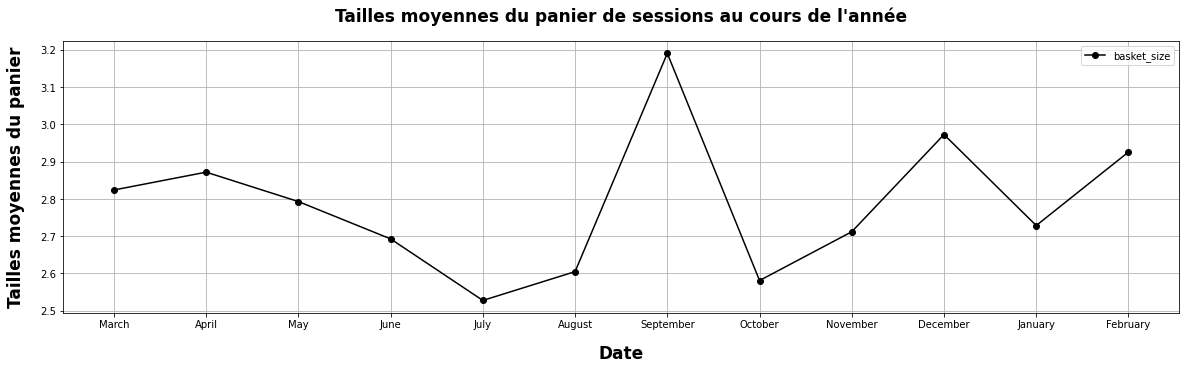

In [ ]:
tpc.groupby("month")[["basket_size"]].mean().plot(rot=0, figsize=(20,5), marker='o', color="black")
plt.title("Tailles moyennes du panier de sessions au cours de l'année", fontsize=17, fontweight="bold", pad=20)
plt.xlabel("Date", labelpad=15, fontsize=17, fontweight="bold")
plt.ylabel("Tailles moyennes du panier", labelpad=15, fontsize=17, fontweight="bold")
ax1 = plt.subplot()
ax1.set_xticks(np.arange(len(tpc.month.unique())))
ax1.set_xticklabels(tpc.month.unique())
plt.grid(True)

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Analyse panier moyen au cours de l'année.png")
plt.show();

Il est intéressant de noter que tout au long de l'année, la taille moyenne du panier des clients atteint son maximum journalier fin septembre, juste avant la chute drastique du chiffre d'affaires au mois d'octobre. Analysons-le maintenant l'évolution de la taille moyenne du panier par mois.

In [ ]:
tpc.basket_size.mean()

2.8025958788589866

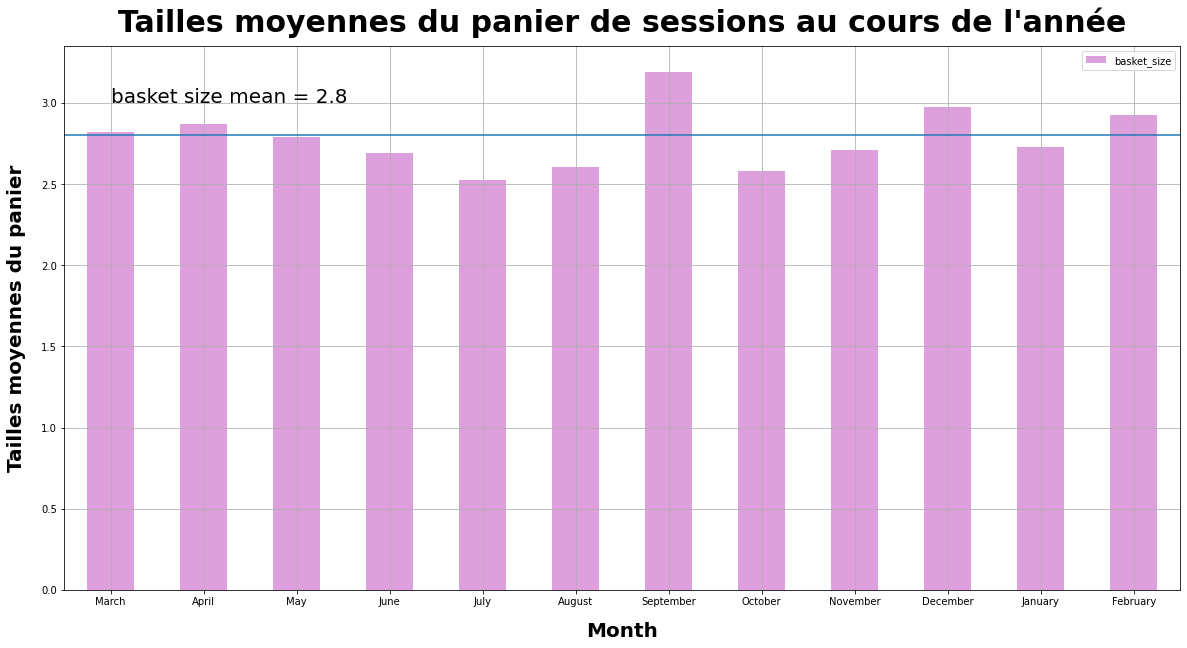

In [ ]:
# histogramme to show
basket_set = tpc.groupby("month")[["basket_size"]].mean()

basket_set.plot(kind="bar", figsize=(20, 10), rot=0, color="plum")

# histogramme settings
plt.title("Tailles moyennes du panier de sessions au cours de l'année", fontsize=30, fontweight="bold", pad=15)
plt.xlabel("Month", fontsize=20, fontweight="bold", labelpad=15)
plt.ylabel("Tailles moyennes du panier", fontsize=20, fontweight="bold", labelpad=15)
plt.axhline(2.80) # basket_size mean
plt.grid(True)

# Text
plt.text(0, 3, "basket size mean = " + str(round(tpc["basket_size"].mean(), 2)), fontsize=20)

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Aperçu panier moyen au cours de l'année.png")
plt.show()


Nous pouvons constater que le panier moyen est constant tous les mois, à peu de choses près. Le mois de septembre voit son panier moyen plus élevé que les autres, sans doute en vertu de la rentrée scolaire.

### Distribution des prix par categorie de produit

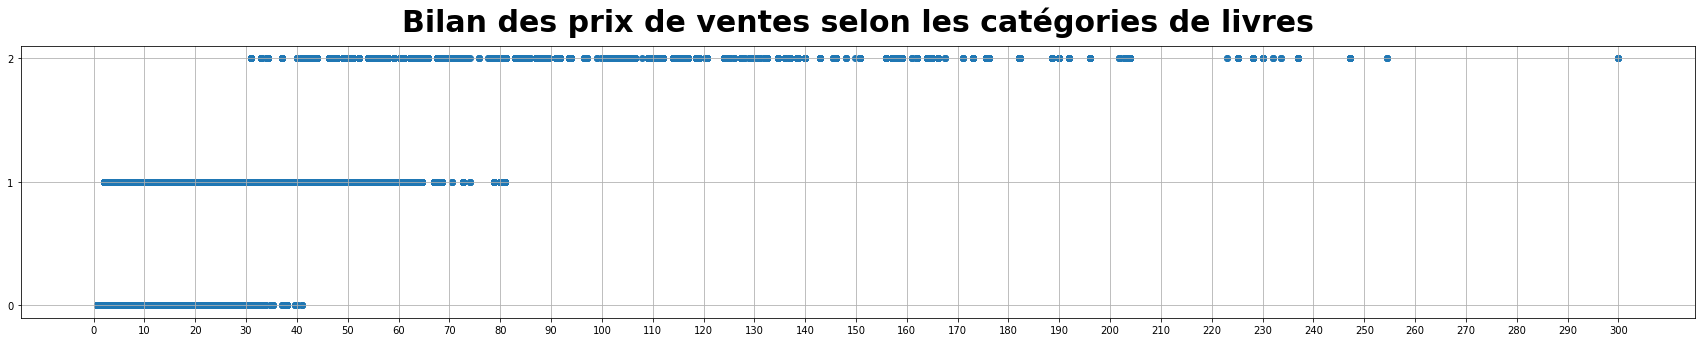

In [ ]:
plt.figure(figsize=(30,5))

# Nuage à point des prix par catégorie
plt.scatter(tpc['price'],tpc['categ'])

# Titre 
plt.title("Bilan des prix de ventes selon les catégories de livres", fontsize=30, fontweight="bold", pad=15)
plt.yticks(np.arange(min(tpc['categ']), max(tpc['categ'])+1, 1.0))
plt.xticks([0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300])

# Sauvegarde graphique
# plt.savefig("img/Prix_Categ.png")

# Affichage et grille
plt.grid()
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


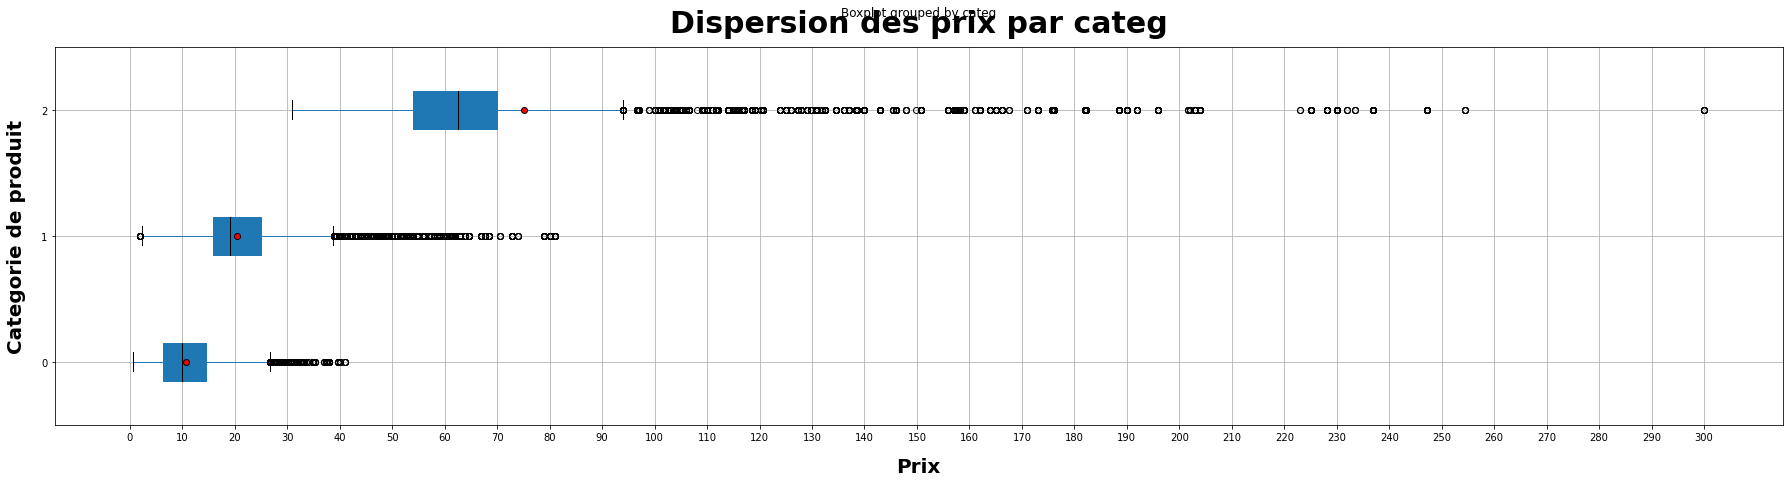

In [ ]:
# Paramètres de la boîte à moustache
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'red'}

# boxplot to show
tpc.boxplot(column='price', by='categ', showmeans=True, figsize=(30,7), vert=False, showfliers=True, patch_artist=True, medianprops=medianprops, meanprops=meanprops)

# boxplot settings
plt.title('Dispersion des prix par categ', fontsize=30, fontweight="bold", pad=15)
plt.xlabel("Prix", fontsize=20, fontweight="bold", labelpad=15)
plt.ylabel("Categorie de produit", fontsize=20, fontweight="bold", labelpad=15)

plt.xticks([0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300])

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Dispersion prix par categorie (avec outliers).png")
plt.show()

- CATÉGORIE 0: Les prix varient entre 0,62 et 40,99 euros. En moyenne, ces livres coûtent environ 11,50 euros et la plupart d'entre eux se vendent à 4,99 euros. D'après le graphique ci-dessus, il s'agit de la catégorie "la moins chère".

- CATÉGORIE 1: Les prix varient entre 2 et 80,99 euros. En moyenne, ces livres coûtent environ 25,50 euros et la plupart d'entre eux se vendent à 22,99 euros. Cette catégorie semble s'adresser à tout poids de portefeuille.

- CATÉGORIE 2: Les prix varient entre 30,99 euros, et valent en moyenne environ 108,35 euros. La plupart d'entre eux coûtent 50,99 euros et d'après le graphique, il s'agit de la catégorie "la plus chère". Il s'agit également de la catégorie de livres proposant le choix le plus large au niveau des prix.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


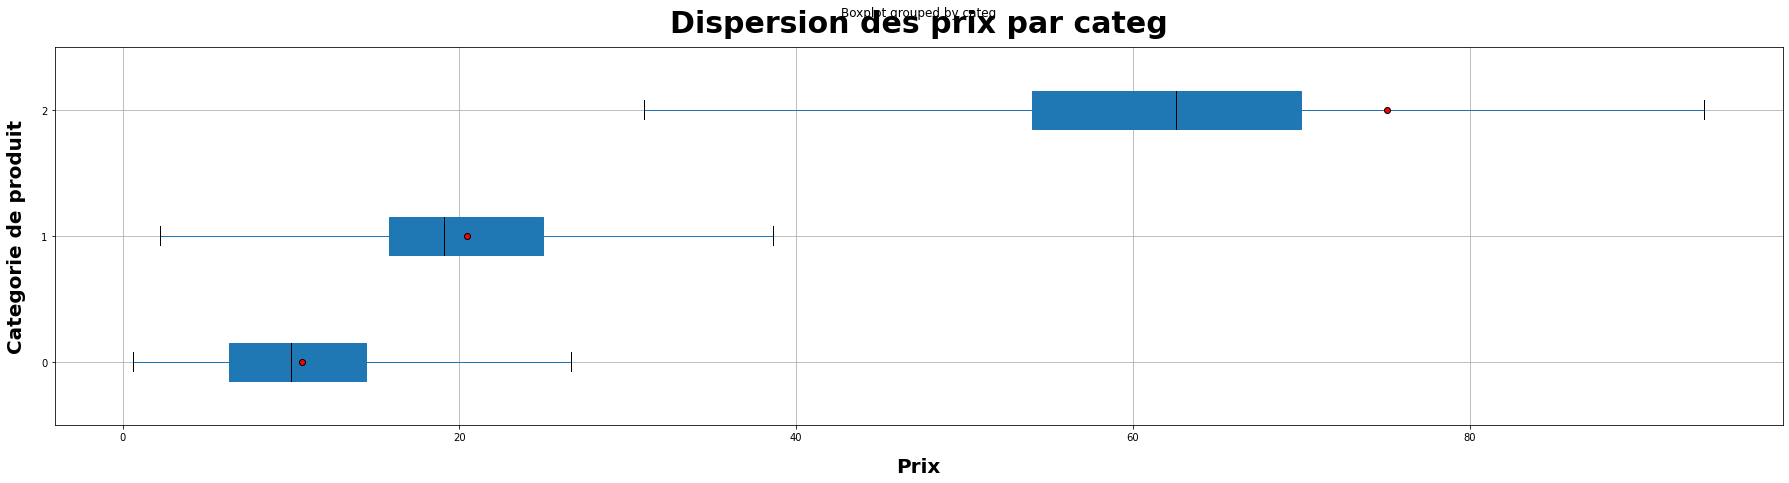

In [ ]:
# SANS OUTLIERS

# Paramètres de la boîte à moustache
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'red'}

# boxplot to show
tpc.boxplot(column='price', by='categ', showmeans=True, figsize=(30,7), vert=False, showfliers=False, patch_artist=True, medianprops=medianprops, meanprops=meanprops)

# boxplot settings
plt.title('Dispersion des prix par categ', fontsize=30, fontweight="bold", pad=15)
plt.xlabel("Prix", fontsize=20, fontweight="bold", labelpad=15)
plt.ylabel("Categorie de produit", fontsize=20, fontweight="bold", labelpad=15)

#plt.xticks([0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300])

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Dispersion prix par categorie (sans outliers).png")
plt.show()

On constate alors que les prix sont beaucoup plus élevés pour les livres de la catégorie 2. La catégorie 1 propose également des prix plus importants que ceux de la catégorie 0. Il semblerait qu'il y ait une corrélation entre les prix et les catégories de livres.

### Distribution des montant d'achats par clients

In [ ]:
ca_client = tpc.groupby("client_id", as_index=False)[["price"]].sum().rename(columns={"client_id":"Client", "price":"TOTAL PURCHASE"})
ca_client = pd.DataFrame(ca_client)
ca_client

Client  TOTAL PURCHASE
0        c_1          300.65
1       c_10          586.18
2      c_100          222.87
3     c_1000          980.02
4     c_1001         1102.45
...      ...             ...
8591   c_995          119.08
8592   c_996          739.60
8593   c_997          572.89
8594   c_998         1527.69
8595   c_999          305.00

[8596 rows x 2 columns]

### Répartition sexe clients (selon achat) par catégorie de produit

In [ ]:
tpc.groupby(["categ","sex"], as_index=False)[["price"]].sum().rename(columns={"price":"Purchase Amount"})

categ sex  Purchase Amount
0      0   f       1075875.04
1      0   m       1002801.15
2      1   f       1103137.64
3      1   m        998447.70
4      2   f        607539.31
5      2   m        575943.30

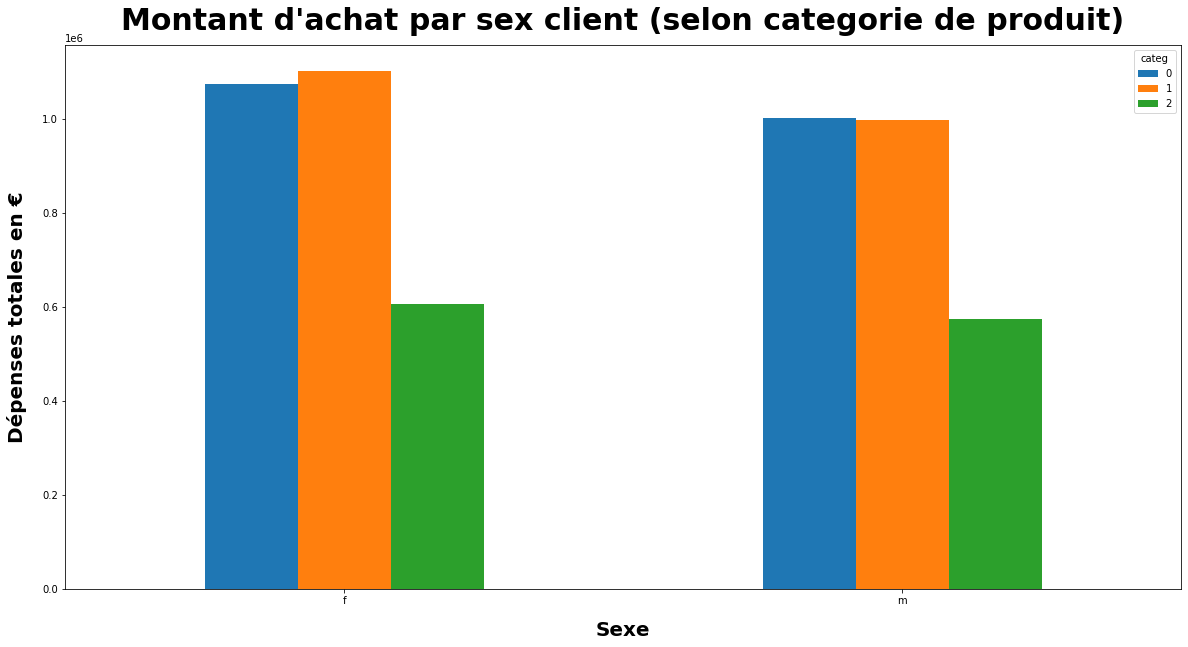

In [ ]:
# bar chart to show
tpc.groupby(["sex","categ"])[["price"]].sum().unstack().plot(kind="bar",y="price", rot=0, figsize=(20,10))

# bar chart settings
plt.title("Montant d'achat par sex client (selon categorie de produit)", fontsize=30, fontweight="bold", pad=15)
plt.xlabel("Sexe", fontsize=20, fontweight="bold", labelpad=15)
plt.ylabel("Dépenses totales en €", fontsize=20, fontweight="bold", labelpad=15)

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Analyse depenses sex clients par categorie.png")
plt.show()

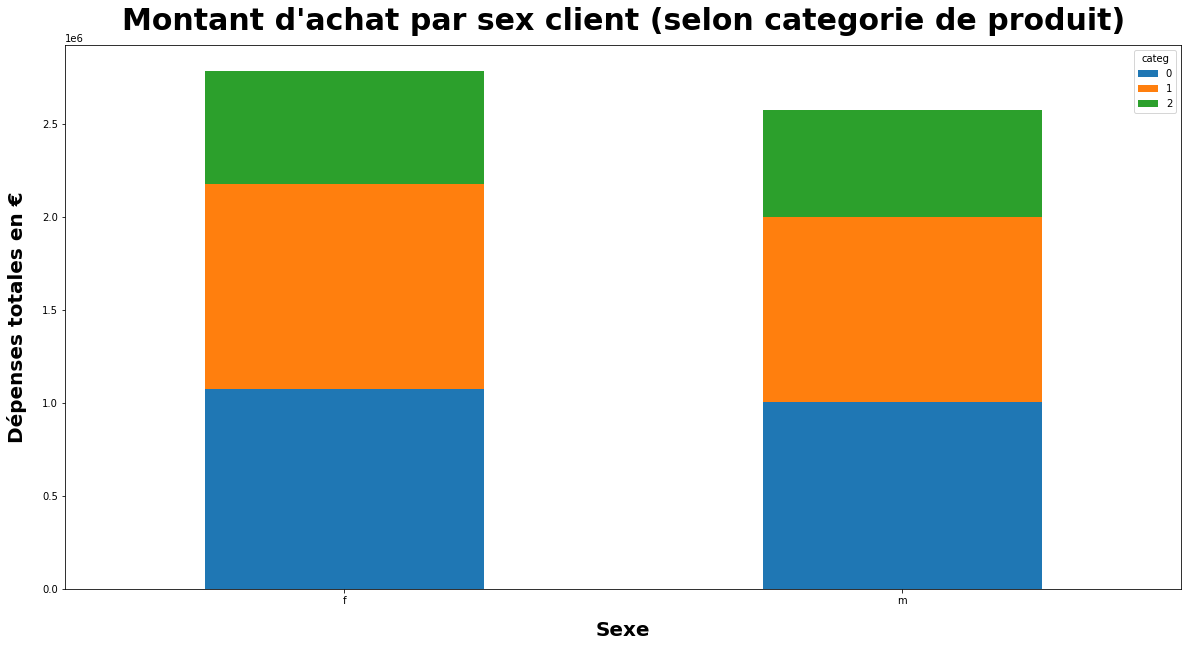

In [ ]:
# bar chart to show
tpc.groupby(["sex","categ"])[["price"]].sum().unstack().plot(kind="bar",y="price", rot=0, figsize=(20,10), stacked=True)

# bar chart settings
plt.title("Montant d'achat par sex client (selon categorie de produit)", fontsize=30, fontweight="bold", pad=15)
plt.xlabel("Sexe", fontsize=20, fontweight="bold", labelpad=15)
plt.ylabel("Dépenses totales en €", fontsize=20, fontweight="bold", labelpad=15)

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Aperçu depenses sex clients par categorie.png")
plt.show()

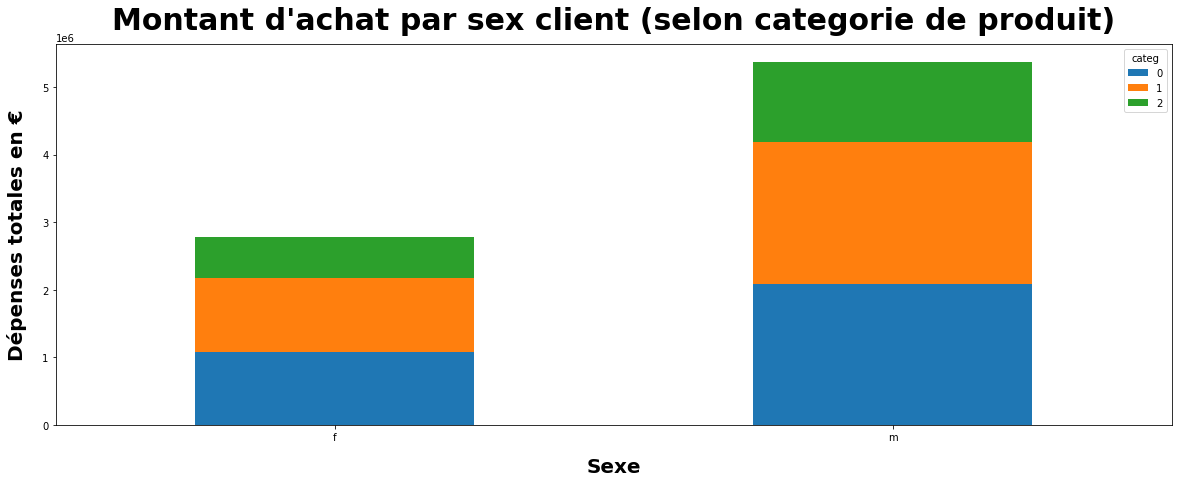

In [ ]:
# bar chart to show
tpc.groupby(["sex","categ"])[["price"]].sum().groupby(level=[1]).cumsum().unstack().plot(kind="bar",y="price", rot=0, figsize=(20,7), stacked=True)

# bar chart settings
plt.title("Montant d'achat par sex client (selon categorie de produit)", fontsize=30, fontweight="bold", pad=15)
plt.xlabel("Sexe", fontsize=20, fontweight="bold", labelpad=15)
plt.ylabel("Dépenses totales en €", fontsize=20, fontweight="bold", labelpad=15)
plt.show()

### Frequence d'achat selon le genre

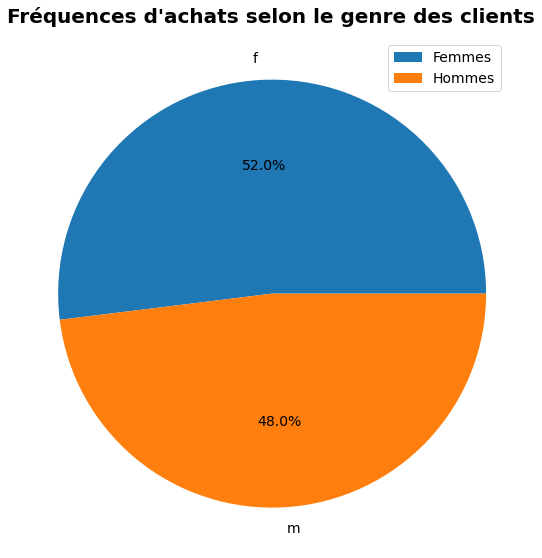

In [ ]:
freqsex_label = tpc["sex"].unique()
freqsex_sizes = tpc.groupby(["sex"])["price"].sum()

plt.figure(figsize=(8,8))

plt.pie(freqsex_sizes, labels=freqsex_label, autopct="%1.1f%%", startangle=0, textprops={"fontsize": 14})
plt.title("Fréquences d'achats selon le genre des clients", fontsize=20, fontweight="bold", pad=15)
plt.legend(fontsize=13, loc="best")

plt.axis("equal")
plt.tight_layout()
plt.legend(["Femmes", "Hommes"], loc="best", fontsize=14)

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Frequence d'achat (en %) par sex.png")
plt.show()

### Âge distribution

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  del sys.path[0]


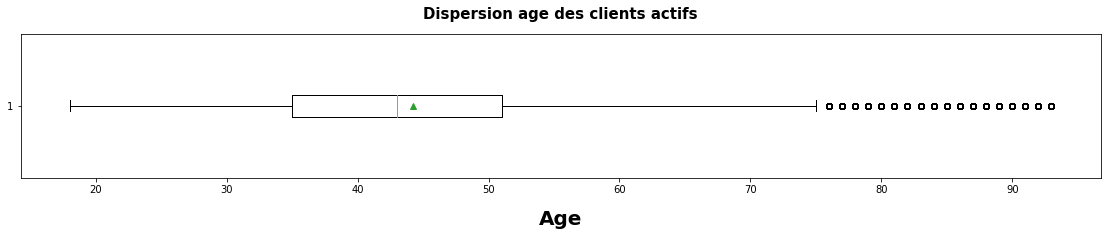

In [ ]:
fig = plt.figure(figsize =(15, 2))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(tpc["age"], showmeans=True, vert=False)

# boxplot settings
plt.title("Dispersion age des clients actifs", fontsize=15, fontweight="bold", pad=15)
plt.xlabel("Age", fontsize=20, fontweight="bold", labelpad=15)
plt.ylabel("", fontsize=20, fontweight="bold", labelpad=15)
plt.tight_layout()
 
# show plot
plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Dispersion age clients actifs.png")
plt.show()

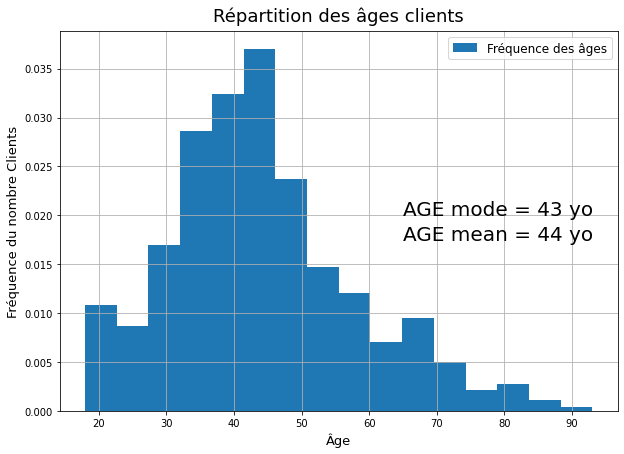

In [ ]:
plt.figure(figsize=(10,7))

# Histogramme de la variable âge des clients
repartition_age = tpc['age'].hist(density = True, grid=True, bins=16)

# Titre
plt.title("Répartition des âges clients",loc="center",pad=10,color='black',fontsize=18,fontweight='normal')

# Titre des axes
plt.xlabel('Âge', color='black', fontsize=13)
plt.ylabel('Fréquence du nombre Clients', color='black', fontsize=13)

# Graduation des axes
plt.xticks(color='black', rotation='horizontal')
plt.yticks(color='black')

# Légende
plt.legend(["Fréquence des âges"], loc="upper right", fontsize=12)

# Text
plt.text(65, .0175, "AGE mean = " + str(math.floor(tpc["age"].mean())) + " yo", fontsize=20)
plt.text(65, .02, "AGE mode = " + str(math.floor(tpc["age"].mode())) + " yo", fontsize=20)

# Sauvegarde graphique
# plt.savefig("img/ageClients.png")

# Affichage
plt.show()

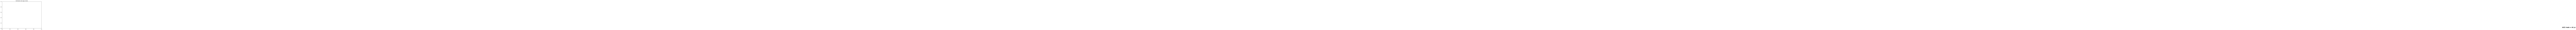

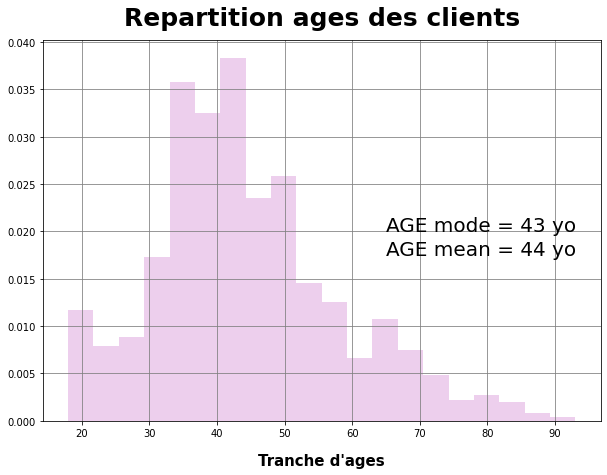

In [ ]:
plt.figure(figsize=(10,7))

# Visualisation (Histogramme)de la distribution de l'âge des clients

plt.xlabel("")
plt.title('Distribution des âges clients')
# Text
plt.text(65, .0175, "AGE mean = " + str(math.floor(tpc["age"].mean())) + " yo", fontsize=20)
plt.text(65, .02, "AGE mode = " + str(math.floor(tpc["age"].mode())) + " yo", fontsize=20)
#plt.savefig("Data/histo_graphe_ages_clients.png")
plt.show()


plt.figure(figsize=(10,7))

# Visualisation (Histogramme)de la distribution de l'âge des clients
tpc['age'].hist(density=True, alpha=0.5, bins=20, color="plum")

# settings
plt.xlabel("Tranche d'ages", fontsize=15, fontweight="bold", labelpad=15)
plt.title('Repartition ages des clients', fontsize=25, fontweight="bold", pad=15)
plt.grid(color="gray")

# Text
plt.text(65, .0175, "AGE mean = " + str(math.floor(tpc["age"].mean())) + " yo", fontsize=20)
plt.text(65, .02, "AGE mode = " + str(math.floor(tpc["age"].mode())) + " yo", fontsize=20)

plt.show()

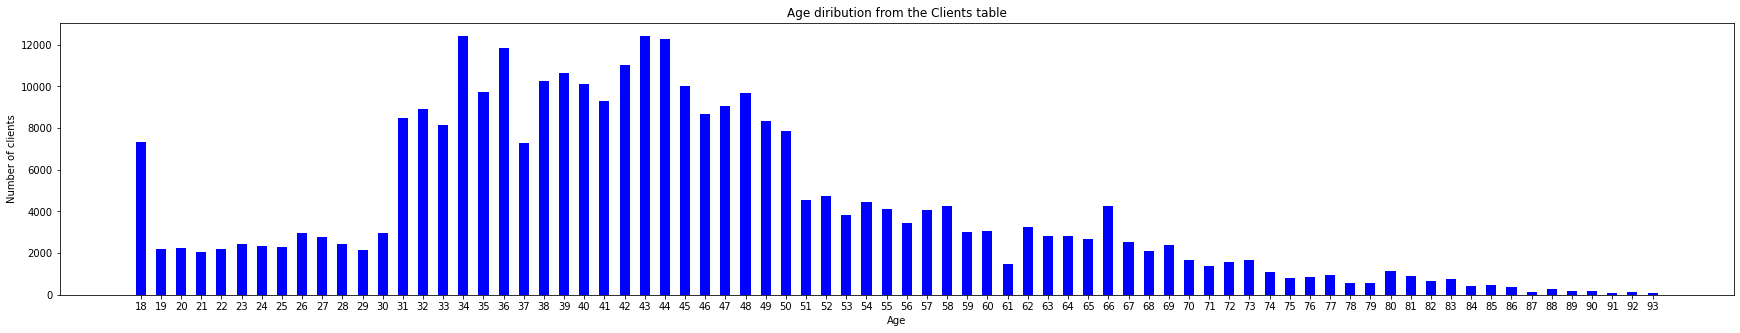

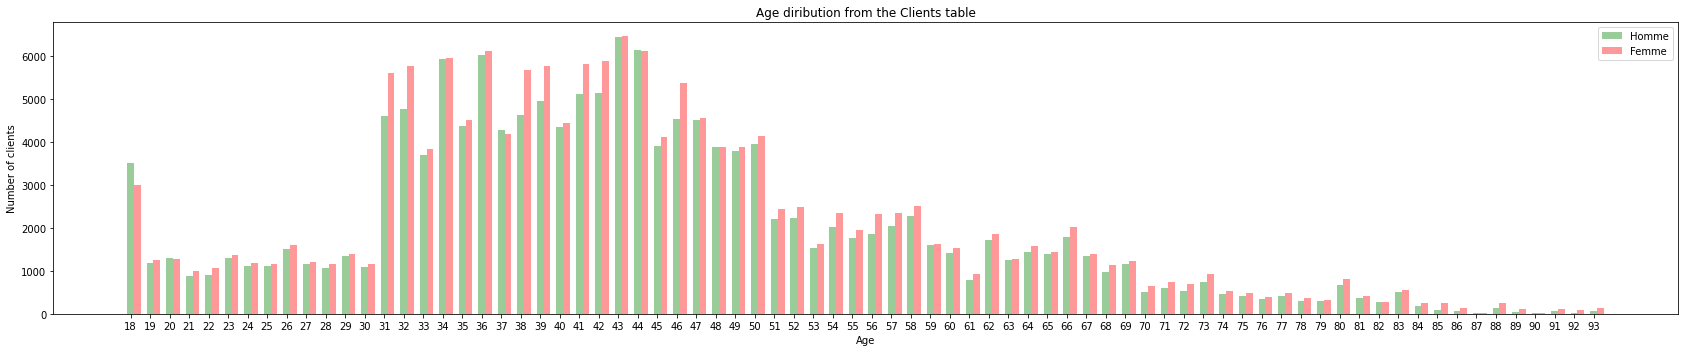

In [ ]:
homme_df = tpc[tpc["sex"] == "m"].copy()
femme_df = tpc[tpc["sex"] == "f"].copy()

#Visualisation de la distribtion des clients par age
#Visualisation de la comparaison entre les hommes et les femmes par rapport a leur age
effectifs = tpc["age"].value_counts()
modalites = effectifs.index # l'index de effectifs contient les modalités

plt.figure(figsize=(30, 5))
# gs = gridspec.GridSpec(1, 2, width_ratios=[.5, 5]) 
# ax1 = plt.subplot(gs[0])
# ax1.pie([homme_df["age"].count(), femme_df["age"].count()], labels = ['Homme', 'Femme'], autopct='%1.1f%%')
# ax2 = plt.subplot(gs[1])
# ax2.axis('off')
# plt.xticks(rotation=90)
xticks = effectifs.index
ticklabels = effectifs.index
plt.xticks(xticks, ticklabels)
plt.xlabel("Age")
plt.ylabel("Number of clients")
plt.title("Age diribution from the Clients table")
plt.bar(effectifs.index, effectifs, 0.5, color='b' )
#plt.savefig("Data/bar_age_client.png")

effectifs_femme = femme_df["age"].value_counts()
modalites_femme = effectifs_femme.index # l'index de effectifs contient les modalités
effectifs_homme = homme_df["age"].value_counts()
modalites_homme = effectifs_homme.index # l'index de effectifs contient les modalités

fig = plt.figure(2, figsize=(23.5, 5))
bar_width = 0.35
opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(modalites_homme, effectifs_homme, bar_width, alpha=opacity, color='g', error_kw=error_config, label='Homme')
rects2 = plt.bar(modalites_homme + bar_width, effectifs_femme, bar_width, alpha=opacity, color='r', error_kw=error_config, label='Femme')

plt.xlabel("Age")
plt.ylabel("Number of clients")
plt.title("Age diribution from the Clients table")

xticks = effectifs.index
ticklabels = effectifs.index
plt.xticks(xticks, ticklabels)

plt.legend()
plt.tight_layout()
#plt.savefig("Data/bar_homme_femme.png")
plt.show()

### Âge distribution by category

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


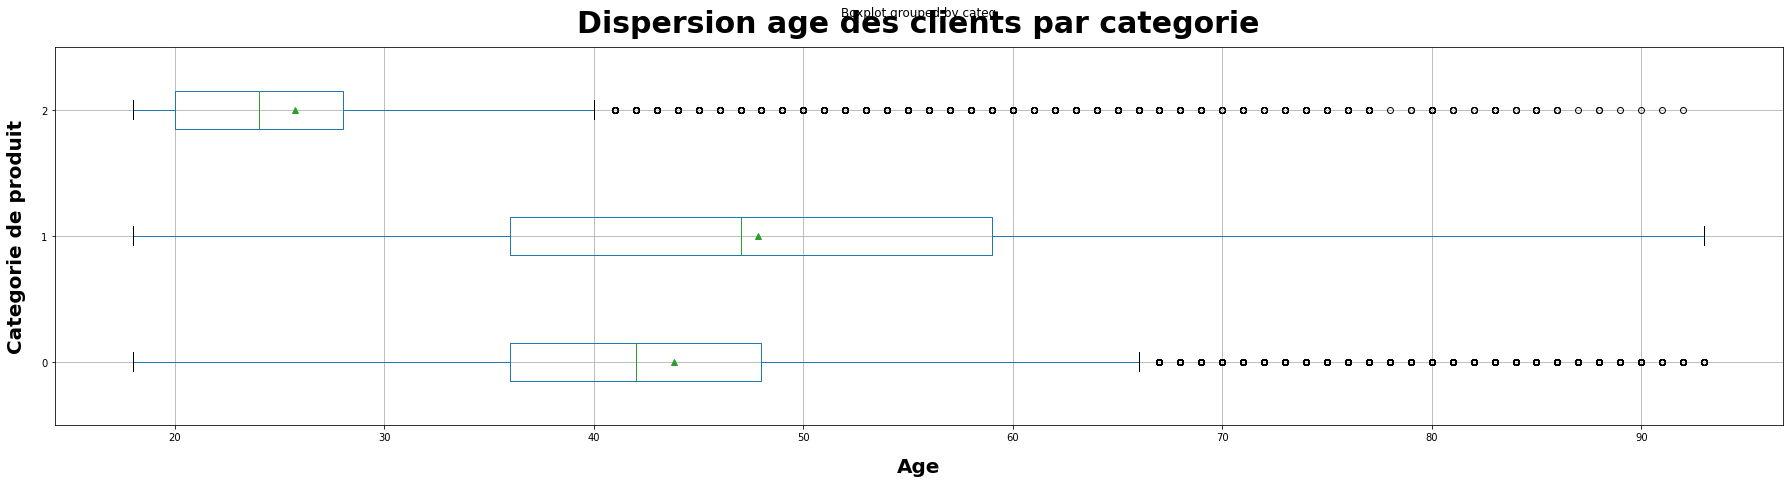

In [ ]:
# boxplot to show
tpc.boxplot(column='age', by='categ', showmeans=True, figsize=(30,7), vert=False)

# boxplot settings
plt.title('Dispersion age des clients par categorie', fontsize=30, fontweight="bold", pad=15)
plt.xlabel("Age", fontsize=20, fontweight="bold", labelpad=15)
plt.ylabel("Categorie de produit", fontsize=20, fontweight="bold", labelpad=15)

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Dispersion age clients actifs par categorie.png")
plt.show()

# Part 4 -- Correlation

## Overview

In [ ]:
# if coeff correlation = 1 : means strong correlation (straight line UP)
# if coeff correlation = -1 : means still strong correlation (straight line DOWN)
# id coeff correlation tends around 0 : means no relationship

tpc.corr().style.background_gradient()

In [ ]:
tpc.corr(method='spearman', min_periods=1).style.background_gradient()

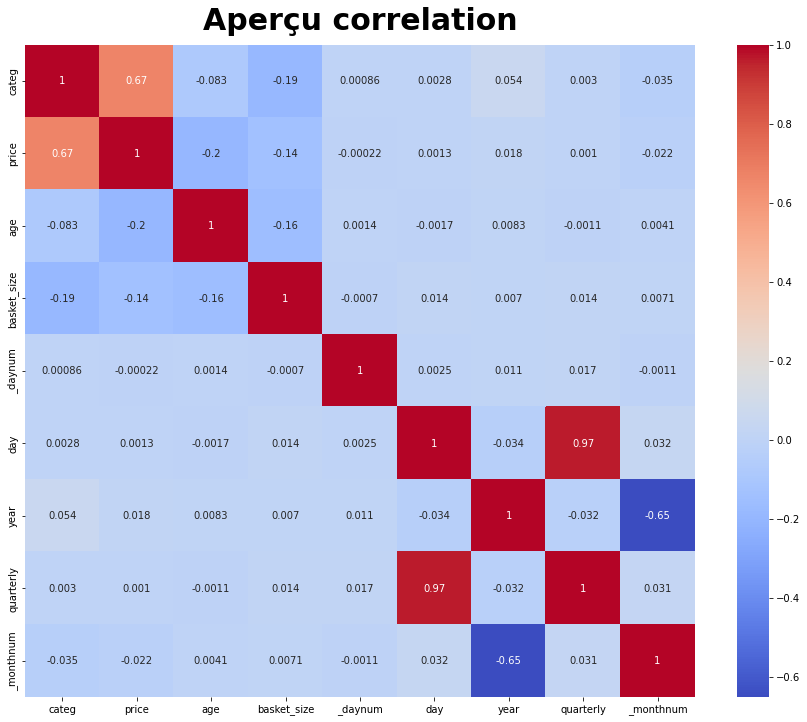

In [ ]:
plt.figure(figsize=(15,12))
sns.heatmap(tpc.corr(), annot=True, cmap="coolwarm")

# chart settings
plt.title("Aperçu correlation", fontsize=30, fontweight="bold", pad=15)
plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Aperçu correlation (table TPC).png")

plt.show()

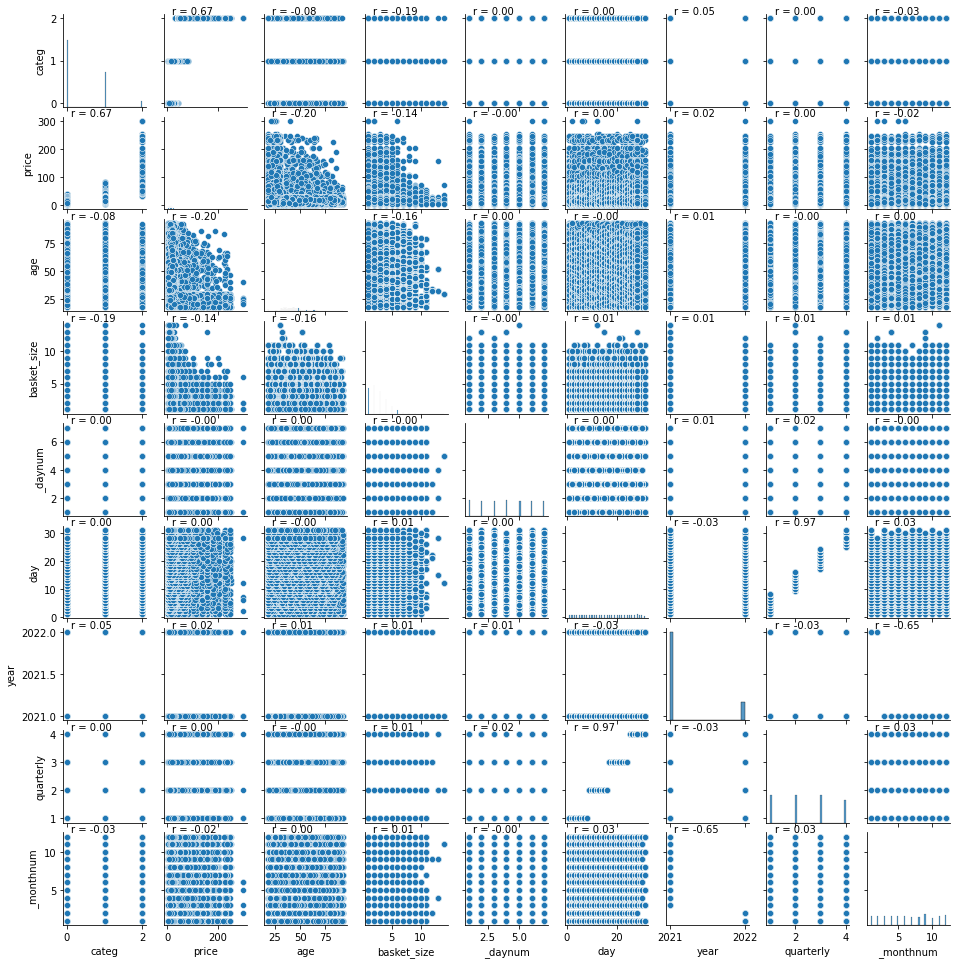

In [ ]:
def corrfunc(x, y, **kws):
  r, _ = stats.pearsonr(x, y)
  ax = plt.gca()
  ax.annotate("r = {:.2f}".format(r), xy=(0.1, 1.0), xycoords=ax.transAxes)

# compare pairplot and heatmap positive and negative correlations
sns.color_palette("Spectral", as_cmap=True)
tpc_pairplot = tpc.dropna()
tpc_pairplot = sns.pairplot(tpc_pairplot, height=1.5)
tpc_pairplot.map_lower(corrfunc)
tpc_pairplot.map_upper(corrfunc)
# plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Aperçu correlation pairplot (table TPC).png")

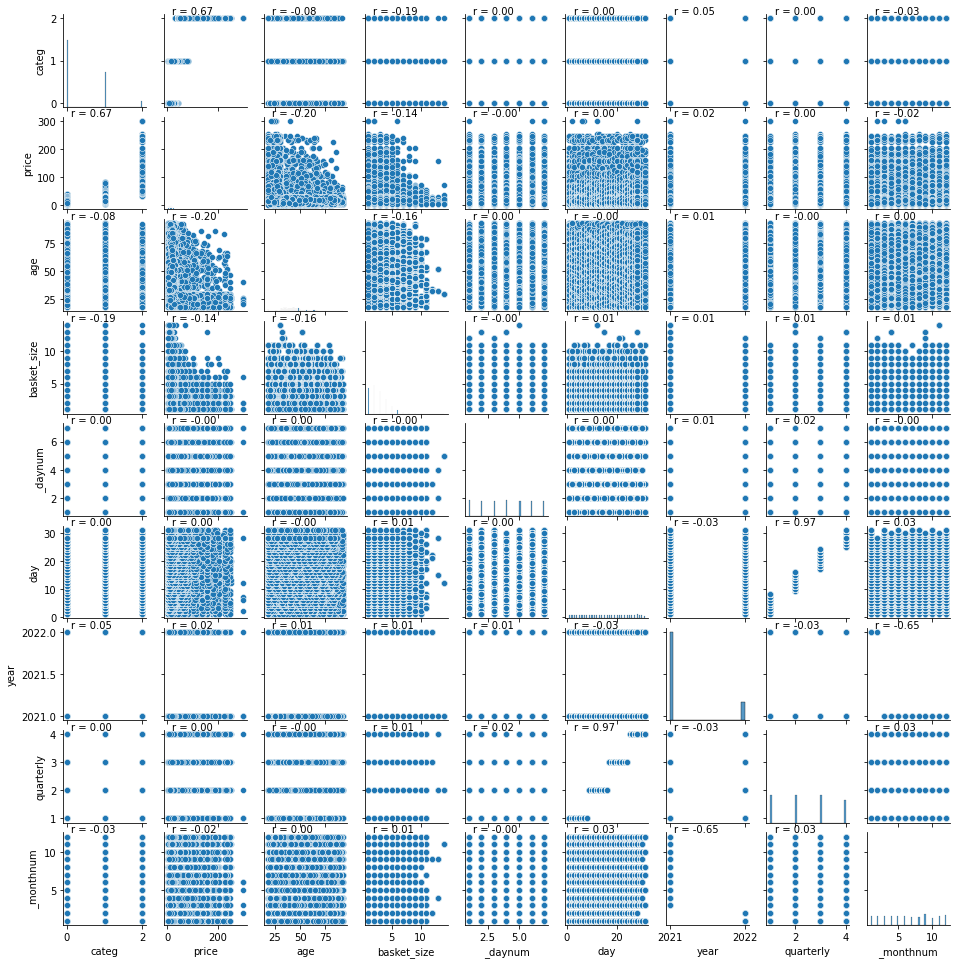

In [ ]:
def corrfunc(x, y, **kws):
  r, _ = stats.pearsonr(x, y)
  ax = plt.gca()
  ax.annotate("r = {:.2f}".format(r), xy=(0.1, 1.0), xycoords=ax.transAxes)

# compare pairplot and heatmap positive and negative correlations
sns.color_palette("Spectral", as_cmap=True)
tpc_pairplot = tpc.dropna()
tpc_pairplot = sns.pairplot(tpc_pairplot, height=1.5)
tpc_pairplot.map_lower(corrfunc)
tpc_pairplot.map_upper(corrfunc)
plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Aperçu correlation pairplot (table TPC).png")

## Corrélation entre le sexe des clients et les catégories de produits achetés

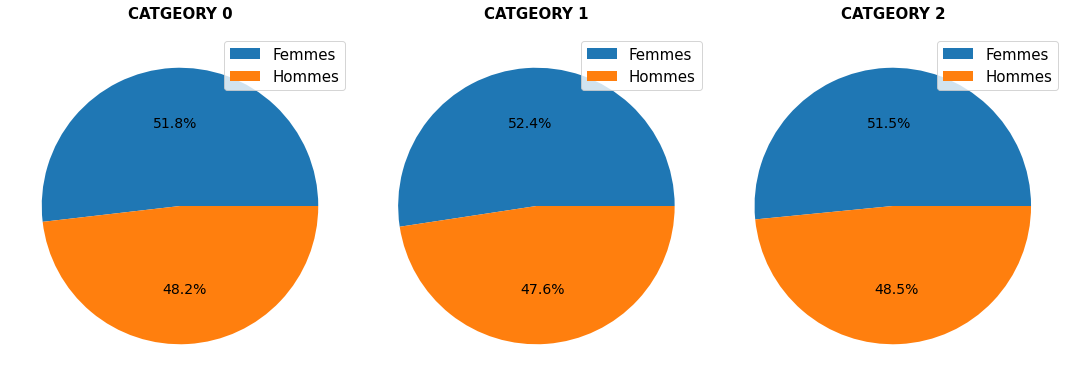

In [ ]:
cat0 = tpc[tpc["categ"]==0]
cat1 = tpc[tpc["categ"]==1]
cat2 = tpc[tpc["categ"]==2]

cat0_label = cat0["sex"].unique()
cat1_label = cat1["sex"].unique()
cat2_label = cat2["sex"].unique()

cat0_sizes = cat0["sex"].value_counts(normalize=True)
cat1_sizes = cat1["sex"].value_counts(normalize=True)
cat2_sizes = cat2["sex"].value_counts(normalize=True)

plt.figure(figsize=(15,15))

plt.subplot(1,3,1)
plt.pie(cat0_sizes, autopct="%1.1f%%", startangle=0, textprops={"fontsize": 14})
plt.title("CATGEORY 0", fontsize=15, fontweight="bold", pad=15)
plt.legend(["Femmes", "Hommes"], fontsize=15, loc="best")

plt.subplot(1,3,2)
plt.pie(cat1_sizes, autopct="%1.1f%%", startangle=0, textprops={"fontsize": 14})
plt.title("CATGEORY 1", fontsize=15, fontweight="bold", pad=15)
plt.legend(["Femmes", "Hommes"], fontsize=15, loc="best")

plt.subplot(1,3,3)
plt.pie(cat2_sizes, autopct="%1.1f%%", startangle=0, textprops={"fontsize": 14})
plt.title("CATGEORY 2", fontsize=15, fontweight="bold", pad=15)
plt.legend(["Femmes", "Hommes"], fontsize=15, loc="best")

#plt.axis("equal")
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Repartition sex clients par categorie de produits achetés.png")
plt.show()

On peut admettre a priori que le genre du client ne conditionne pas la catégorie de livres à laquelle il/elle va s'intéresser. Mais allons plus loin..

In [ ]:
X = "sex"
Y = "categ"

cont = tpc[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
cont
# si chiffre similaire alors independant

categ       0       1      2   Total
sex                                 
f      101206   53774   8122  163102
m       94064   48851   7634  150549
Total  195270  102625  15756  313651

In [ ]:
sexcat = tpc[["categ", "sex"]]
sexcat_tab = pd.crosstab(sexcat["sex"], sexcat["categ"])
sexcat_tab

categ       0      1     2
sex                       
f      101206  53774  8122
m       94064  48851  7634

In [ ]:
sexcat_pct = pd.crosstab(sexcat["sex"], sexcat["categ"], normalize="index")
sexcat_pct

# If we want the percentages by column, then we should write normalize=’columns’
# and if we want the total percentage then we should write normalize=’all’

categ         0         1         2
sex                                
f      0.620507  0.329696  0.049797
m      0.624807  0.324486  0.050708

In [ ]:
sexcat.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)

# if coeff correlation = 1 : means strong correlation (straight line UP)
# if coeff correlation = -1 : means still strong correlation (straight line DOWN)
# id coeff correlation tends around 0 : means no relationship

categ       sex
categ  1.000000 -0.002881
sex   -0.002881  1.000000

In [ ]:
# tableau de contingence reel
c = tpc[["categ", "sex"]].pivot_table(index="categ", columns="sex", aggfunc=len)
cont =  c.copy()

tx = tpc["categ"].value_counts()
ty = tpc["sex"].value_counts()

cont.loc[:, "Total"], cont.loc["total", :] = tx, ty
cont.loc["total", "Total"] = len(tpc) ; cont

sex           f         m     Total
categ                              
0      101206.0   94064.0  195270.0
1       53774.0   48851.0  102625.0
2        8122.0    7634.0   15756.0
total  163102.0  150549.0  313651.0

Pour le moment, nous ne semblons pas distinguer de corrélations significatives. Mais la construction du tableau de contingence théorique en vue du tableau de contingence coloré peut contredire cette supposition.

In [ ]:
# tableau de contingence theorique
tx, ty = pd.DataFrame({"foo": tx}) , pd.DataFrame({"foo": ty})
indep = tx.dot(ty.T)/len(tpc) ; indep

f             m
0  101542.566547  93727.433453
1   53366.138638  49258.861362
2    8193.294815   7562.705185

In [ ]:
# Chi-2, le degré de liberté, p_value
mesure = (c-indep)**2/indep

xi_n = mesure.sum().sum()
ddl = (len(c)-1)*(len(c.columns)-1)
pvalue = st.chi2_contingency(c)[1]

pd.DataFrame({"": [str(ddl), round(pvalue, 20), xi_n]}, index=["Dégré de liberté", "pvalue", "Chi-2"])

Dégré de liberté           2
pvalue            0.00637461
Chi-2                10.1109

In [ ]:
# Chi-square test of independence
c, p, dof, expected = chi2_contingency(sexcat_tab)

# Print the p-value
print(f"p-value of correlation between sex and category is {p}")

stat, p, dof, expected = chi2_contingency(sexcat_tab)

# interpret p-value
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

p-value of correlation between sex and category is 0.006374607510181767
Dependent (reject H0)


On s'aperçoit que la p_value est très proche de 0. Ce qui nous permet de rejeter l'hypothèse qu'il n'y a aucune indépendance entre le genre du client et les catégories de produits. On en déduit donc qu'il y a bien une corrélation entre le sexe des clients et les catégories de produits achetés.

Analysons maintenant cette corrélation pour chacune des 3 catégories de livre avec un tableau de contingence coloré.

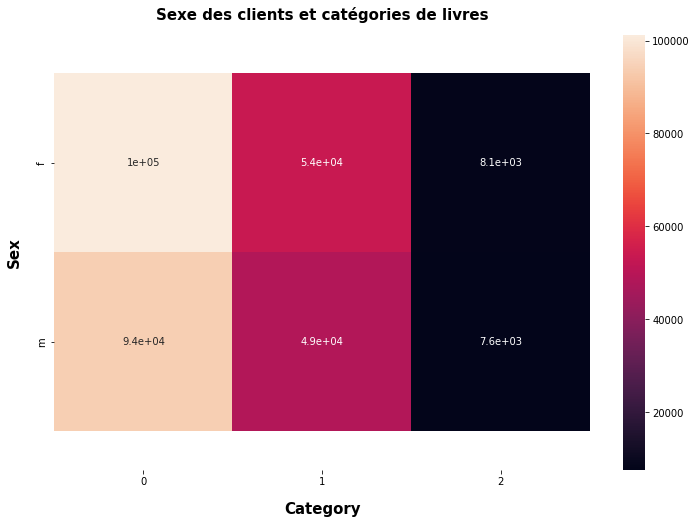

In [ ]:
plt.figure(figsize=(12,8)) 
sns.heatmap(sexcat_tab, annot=True)
plt.title("Sexe des clients et catégories de livres", fontsize=15, fontweight="bold", pad=15)
plt.xlabel("Category", fontsize=15, fontweight="bold", labelpad=15)
plt.ylabel("Sex", fontsize=15, fontweight="bold", labelpad=15)
plt.axis("equal")

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Table contingence sex clients par categorie de produits achetés.png")
plt.show()

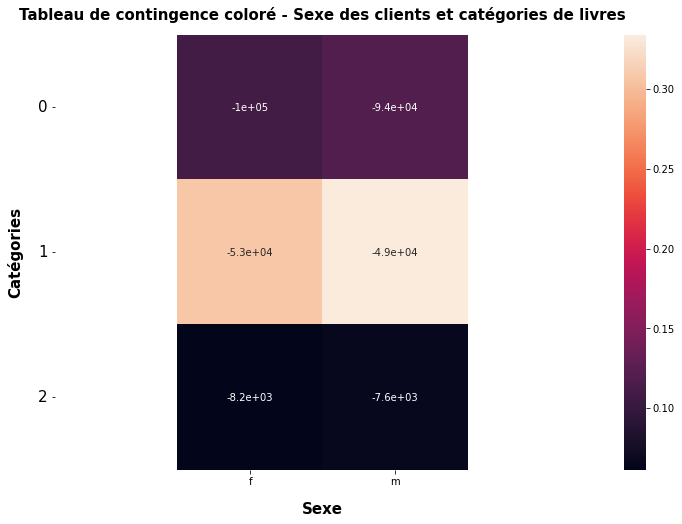

In [ ]:
plt.figure(figsize=(12,8)) 
sns.heatmap(mesure/xi_n, annot=c-indep)
plt.title("Tableau de contingence coloré - Sexe des clients et catégories de livres", fontsize=15, fontweight="bold", pad=15)
plt.xlabel("Sexe", fontsize=15, fontweight="bold", labelpad=15) ; plt.ylabel("Catégories", fontsize=15, fontweight="bold", labelpad=15) ; plt.yticks(fontsize=15, rotation=0)
plt.axis("equal") ; plt.show()

Conclusion:

- Catégorie 0: Il y a une légère corrélation, en effet, les hommes semblent s'intéresser plus à cette catégorie de livres que les femmes.
- Catégorie 1: Il y a corrélatation entre cette catégorie de livres et le genre du client. On voit ici que cette catégorie intéresse beaucoup plus les femmes que les hommes.
- Catégorie 2: Le genre du client importe peu. Les femmes s'intéressent aussi fréquemment à cette catégorie de livres que les hommes.

In [ ]:
# for correlation, a p-value tells the probability if 2 data sets will result in a relationship
# the smaller the p-value, the more confidence we have in the predictions we make with the line
# if p-value tends to 1 = little confidence in the trend, very little data (0.8) 
# if p-value tends to 0 = moderate confidence, bit more data (0.08)
# if p-value tends to super 0 = lot of confidence, more data (0.008)

# in other words, juste because there's a lot of data and
# p-value tends to super small (strong confidence)
# if the correlation value is small, guess will still be bad


alpha = 0.05 # seuil de 5% pour determiner si alpha inferieur au PVALUE, on rejete pas hypothese null H0

chi2, pvalue, degrees, expected = chi2_contingency(sexcat_tab) # afficher le p-value
print('chi2=%.3f, pvalue=%.6f, degrees=%.3f' % (chi2, pvalue, degrees))
if pvalue < alpha:
    print('il existe donc un lien entre le sexe des clients et les catégories produits.')
else:
    print(0)

chi2=10.111, pvalue=0.006375, degrees=2.000
il existe donc un lien entre le sexe des clients et les catégories produits.


## Corrélation entre l'âge des clients et le montant total des achats

In [ ]:
agebuy = tpc.groupby(pd.Grouper(key='age')).sum().reset_index()
agebuy[['age','price','categ']].head()

age      price  categ
0   55   68926.58   2356
1   62   53450.79   1758
2   34  162037.42   2878
3   33  106830.53   1863
4   66   71364.45   2455

In [ ]:
cl_bhv[["client_id", "age", "annual_expense"]]

client_id  age  annual_expense
0          c_1   67          300.65
1         c_10   66          586.18
2        c_100   30          222.87
3       c_1000   56          980.02
4       c_1001   40         1102.45
...        ...  ...             ...
8591     c_995   67          119.08
8592     c_996   52          739.60
8593     c_997   28          572.89
8594     c_998   21         1527.69
8595     c_999   58          305.00

[8596 rows x 3 columns]

Déterminons maintenant le diagramme de dispersion entre l'âge des clients et le montant total des achats, la droite de régression linéaire de ce diagramme, ainsi que le coefficient de corrélation de Pearson afin d'évaluer s'il y a bien corrélation entre ces deux variables quantitatives.

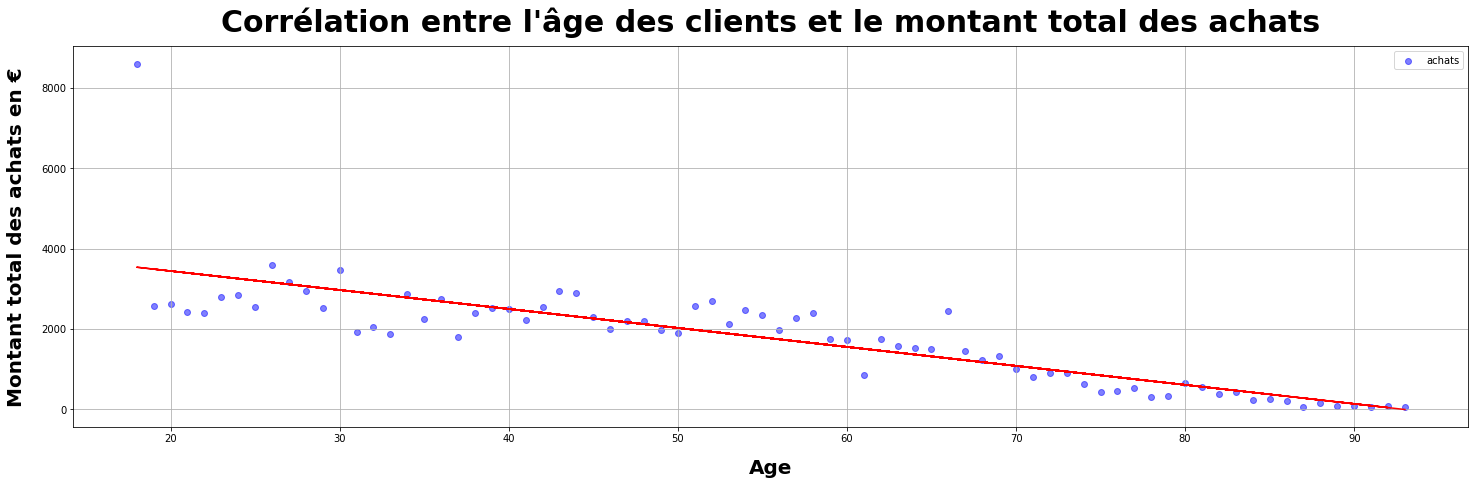

Coefficient de corrélation de Pearson: -0.19036575228394817
Sa p_value est de: 5.8879491247678e-71


In [ ]:
plt.figure(figsize=(25,7))
# Visualisation de l'évolution des achats des prix  selon l'age avec un scatter
X =  agebuy.iloc[:,0] #selection de la variable  age
Y =  agebuy.iloc[:,1] #selection de la variable  prix


pente, intercept, r_value, p_value, std_err = st.linregress(X, Y)
                                                
pente, intercept

def predict(x):
    return pente * x + intercept

axes = plt.axes()
axes.grid()
plt.scatter(X,Y,label="achats", color='b',alpha=0.5)
fitLine = predict(X)
plt.plot(X, fitLine, c='r')
plt.legend()
plt.xlabel("Age", fontsize=20, fontweight="bold", labelpad=15)
plt.ylabel("Montant total des achats en €", fontsize=20, fontweight="bold", labelpad=15)
plt.title("Corrélation entre l'âge des clients et le montant total des achats", fontsize=30, fontweight="bold", pad=15)

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Age clients et leurs montants achats total.png")
plt.show()

# p_value + coefficient de corrélation de Pearson
pears(clients, "age", "annual_expense")

# si coef pearson = 0 : pas correlation
# si coef pearson -1 et 1 : correlation

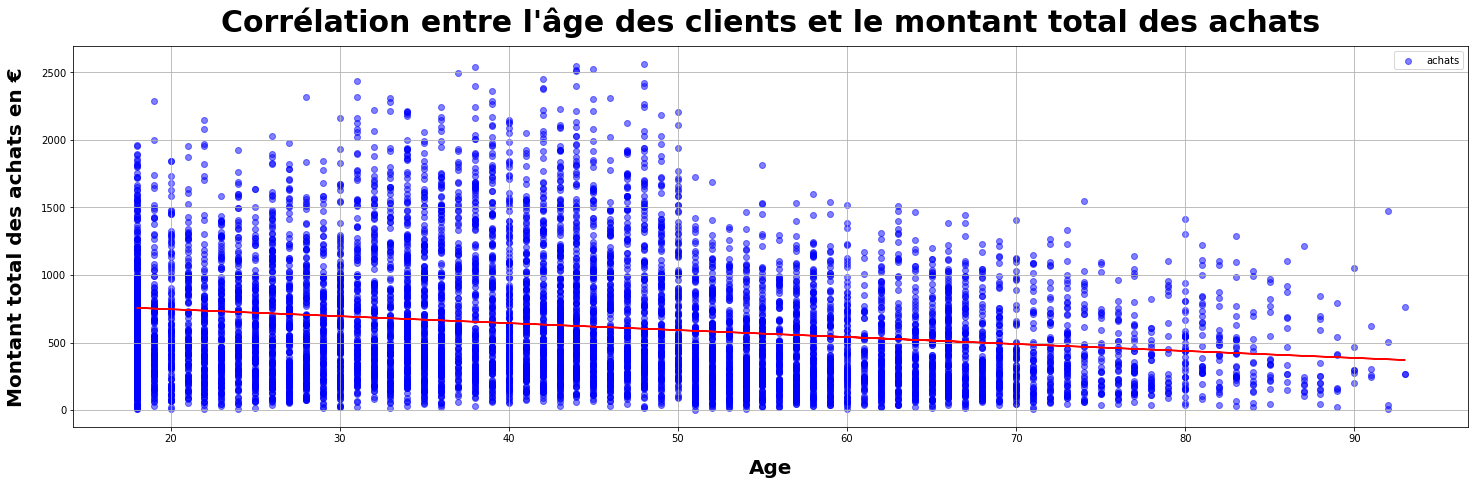

Coefficient de corrélation de Pearson: -0.19036575228394817
Sa p_value est de: 5.8879491247678e-71


In [ ]:
plt.figure(figsize=(25,7))
# Visualisation de l'évolution des achats des prix  selon l'age avec un scatter
X =  cl_bhv["age"]
Y =  cl_bhv["annual_expense"]


pente, intercept, r_value, p_value, std_err = st.linregress(X, Y)
                                                
pente, intercept

def predict(x):
    return pente * x + intercept

axes = plt.axes()
axes.grid()
plt.scatter(X,Y,label="achats", color='b',alpha=0.5)
fitLine = predict(X)
plt.plot(X, fitLine, c='r')
plt.legend()
plt.xlabel("Age", fontsize=20, fontweight="bold", labelpad=15)
plt.ylabel("Montant total des achats en €", fontsize=20, fontweight="bold", labelpad=15)
plt.title("Corrélation entre l'âge des clients et le montant total des achats", fontsize=30, fontweight="bold", pad=15)

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Plot Age clients et leurs montants achats total.png")
plt.show()

# p_value + coefficient de corrélation de Pearson
pears(clients, "age", "annual_expense")

# si coef pearson = 0 : pas correlation
# si coef pearson -1 et 1 : correlation

On peut noter ici que les jeunes clients dépensent plus.

Ce nuage de points nous laisse supposer, qu'il existe une corrélation négative entre l'âge des clients et le montant total des dépenses.

À la vue de la "pente" de la droite de régression linéaire (coefficient directeur négatif) et par le calcul d'un coefficient de corrélation de Pearson proche de -0,2, on en conclue que l'on peut supposer une corrélation négative faible entre l'âge des clients et le montant total des achats: Plus un client est âgé, moins il dépense chez nous en un an.

Cependant, aucune fonction affine à coefficient directeur négatif ne se dégage vraiment de ce nuage de points si l'on analyse le graphique sans le traçage de la droite de régression linéaire.

On observe d'ailleurs que les clients âgés d'entre 31 et 50 ans semblent dépenser plus que les moins de 30 ans, alors qu'on avait supposé une corrélation négative. Il serait donc plus judicieux d'étudier la corrélation entre les trois tranches d'âges des clients prédéfinies en introduction et le montant total des achats.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


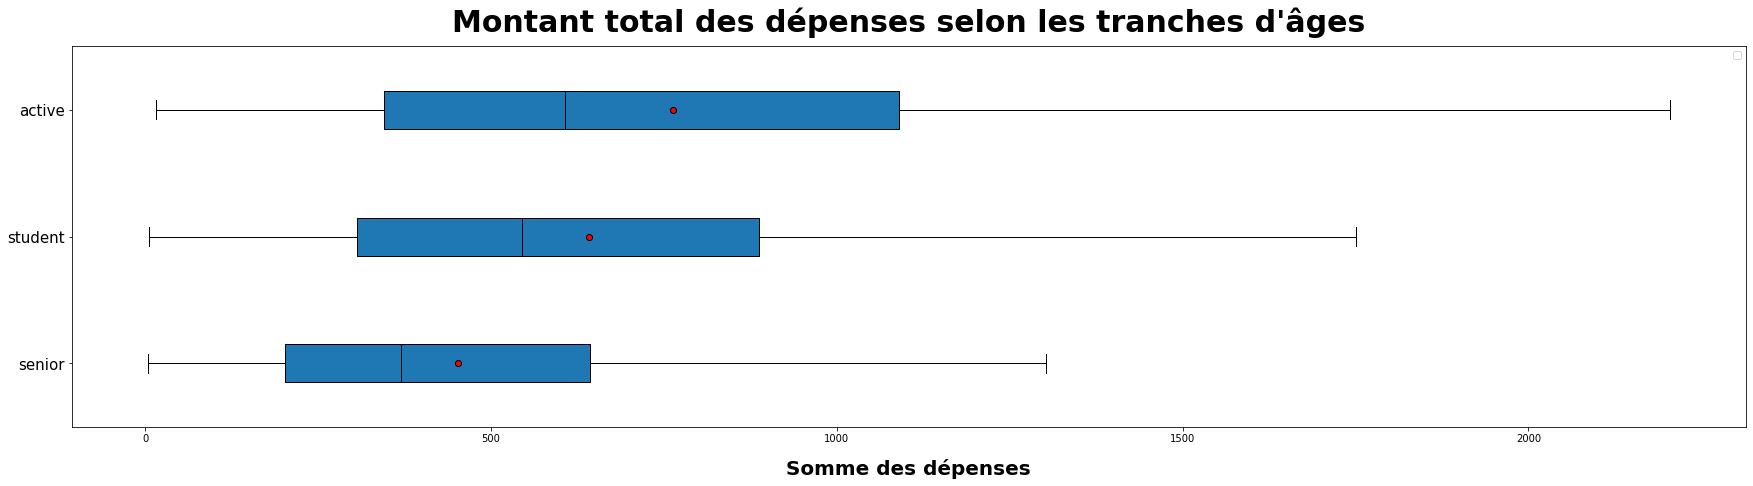

Rapport de corrélation: 8.5


In [ ]:
# PLOTTING
X = "client_type" # qualitative
Y = "annual_expense" # quantitative

# On ne garde que les dépenses
subs = cl_bhv[cl_bhv["annual_expense"] > 0].copy()

modalites = subs[X].unique()
groupes = []
for m in modalites:
    groupes.append(subs[subs[X]==m][Y])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'red'}

# Boîte à moustache
plt.figure(figsize=(30,7))
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, vert=False, patch_artist=True,
            showmeans=True, meanprops=meanprops)

# Titre
plt.title("Montant total des dépenses selon les tranches d'âges", fontsize=30, fontweight="bold", pad=15)

# Titre des axes
plt.xlabel("Somme des dépenses", fontsize=20, fontweight="bold", labelpad=15)
plt.ylabel("")

# Ticks
plt.yticks(fontsize=15)

# Légende
plt.legend()

# Sauvegarde graphique
plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Boxplot types clients et montants achat totals.png")

# Affichage
plt.show()

print("Rapport de corrélation:", 100*round(eta_carre(cl_bhv["client_type"], cl_bhv["annual_expense"]), 3))

Les moyennes de ces trois bloxplots semblent presque homogène. Avec un rapport de corrélation d'environ 8,5%, on peut en déduire une corrélation moyenne entre les tranches d'âges et le montant total des dépenses: Les "actifs" semblent dépenser légèrement plus que les étudiants qui, eux, dépensent plus que les seniors.

## Corrélation entre l'âge des clients et la fréquence d’achat (ie. nombre d'achats par mois par exemple)

In [ ]:
agefreq = tpc.groupby(["age"], as_index=False).count().copy()
agefreq = agefreq[["age", "session_id"]]

agefreq["f"] = agefreq["session_id"] / sum(agefreq["session_id"])
agefreq.sort_values(by="session_id", ascending=False).head()

age  session_id         f
25   43       12424  0.039611
16   34       12408  0.039560
26   44       12279  0.039149
18   36       11824  0.037698
24   42       11025  0.035151

No handles with labels found to put in legend.


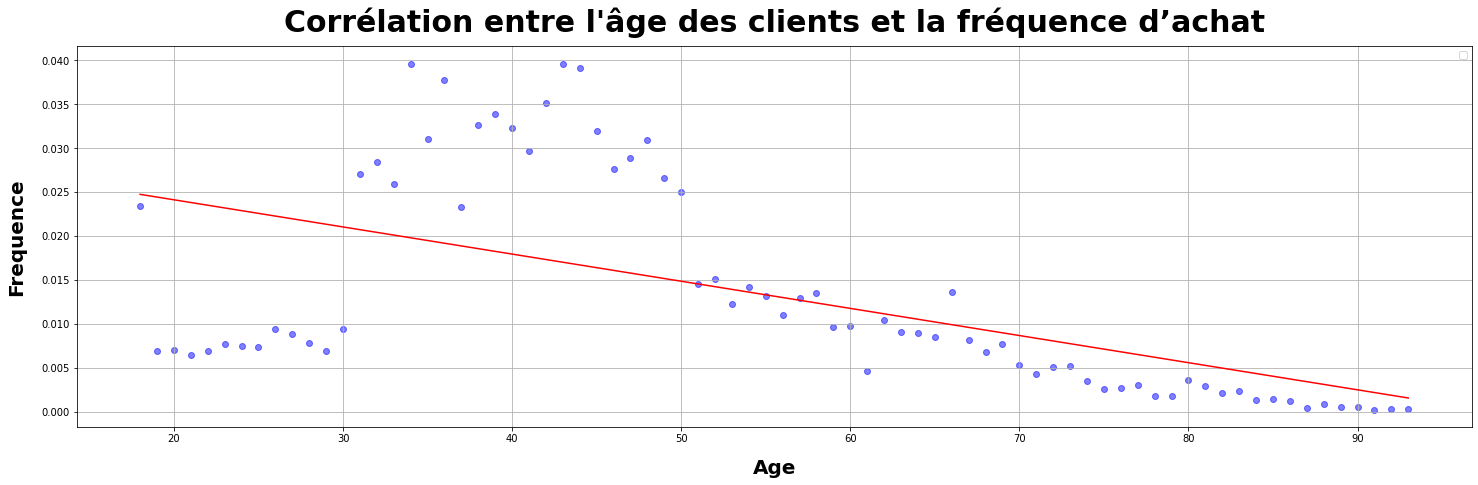

Coefficient de corrélation de Pearson: -0.04668185340256748
Sa p_value est de: 1.4923052949427392e-05


In [ ]:
plt.figure(figsize=(25,7))

# Visualisation de l'évolution des achats des prix  selon l'age avec un scatter
X =  agefreq.iloc[:,0] #selection de la variable age
Y =  agefreq.iloc[:,2] #selection de la frequence f

pente, intercept, r_value, p_value, std_err = st.linregress(X, Y)
                                        
pente, intercept
def predict(x):
    return pente * x + intercept

axes = plt.axes()
axes.grid()
plt.scatter(X,Y,label="", color='b',alpha=0.5)
fitLine = predict(X)
plt.plot(X, fitLine, c='r')
plt.legend()
plt.xlabel("Age", fontsize=20, fontweight="bold", labelpad=15)
plt.ylabel("Frequence", fontsize=20, fontweight="bold", labelpad=15)
plt.title("Corrélation entre l'âge des clients et la fréquence d’achat", fontsize=30, fontweight="bold", pad=15)

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Age clients et frequence d'achat.png")
plt.show()

# p_value + coefficient de corrélation de Pearson
pears(monthly_basket_mean, "age", "monthly_basket_av")

No handles with labels found to put in legend.


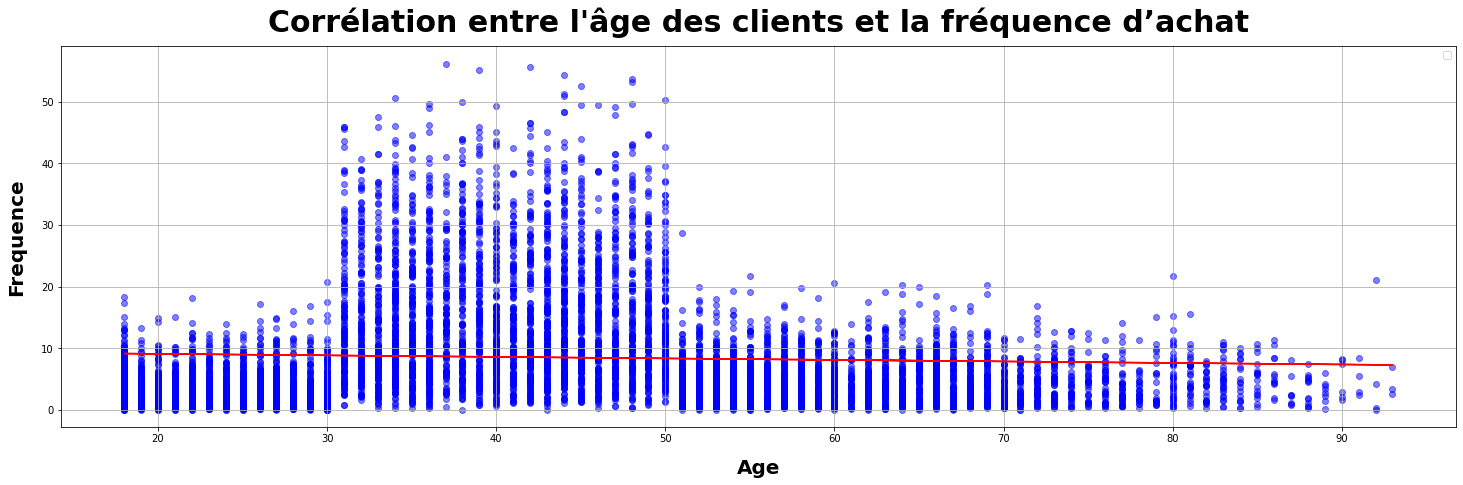

Coefficient de corrélation de Pearson: -0.04668185340256748
Sa p_value est de: 1.4923052949427392e-05


In [ ]:
plt.figure(figsize=(25,7))

# Visualisation de l'évolution des achats des prix  selon l'age avec un scatter
X =  monthly_basket_mean["age"]
Y =  monthly_basket_mean["monthly_basket_av"]

pente, intercept, r_value, p_value, std_err = st.linregress(X, Y)
                                        
pente, intercept
def predict(x):
    return pente * x + intercept

axes = plt.axes()
axes.grid()
plt.scatter(X,Y,label="", color='b',alpha=0.5)
fitLine = predict(X)
plt.plot(X, fitLine, c='r')
plt.legend()
plt.xlabel("Age", fontsize=20, fontweight="bold", labelpad=15)
plt.ylabel("Frequence", fontsize=20, fontweight="bold", labelpad=15)
plt.title("Corrélation entre l'âge des clients et la fréquence d’achat", fontsize=30, fontweight="bold", pad=15)

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Plot age clients et frequence d'achat.png")
plt.show()

# p_value + coefficient de corrélation de Pearson
pears(monthly_basket_mean, "age", "monthly_basket_av")

Malgré un coefficient de Pearson proche de 0, le nuage de points semble indiquer une éventuelle corrélation entre l'âge des clients et la fréquence d'achats: Les clients âgés de 31 à 50 effectuent plus d'achats chaque mois, que les tranches d'âges inférieure et supérieure.

Il serait alors très intéressant de se demander s'il y a corrélation entre les tranches d'âges des clients et cette fréquence d'achats.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


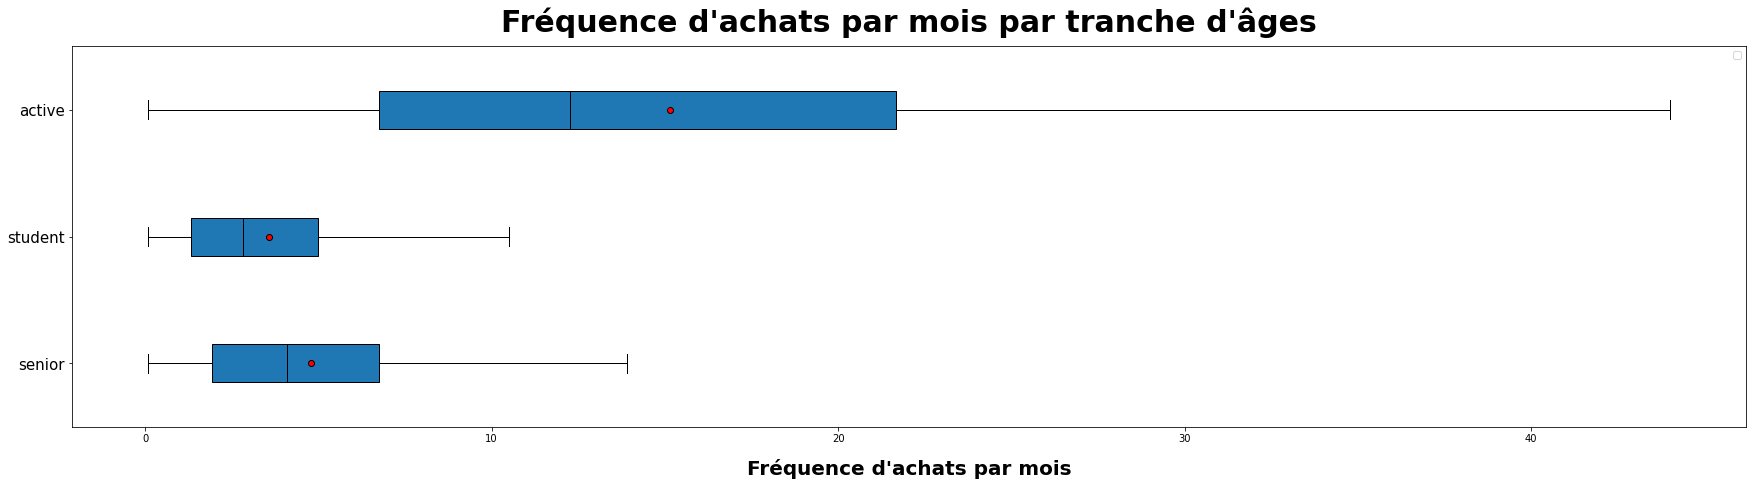

Rapport de corrélation: 0.3568082752218916


In [ ]:
# On s'intéresse aux tranches d'âges présentes parmi les monthly_basket_mean ayant effectué des achats dans chacune de 
# nos 3 catégories de produits:

# PLOTTING
X = "client_type"       # qualitative
Y = "monthly_basket_av" # quantitative

# On ne garde que les dépenses
subs = monthly_basket_mean[monthly_basket_mean["monthly_basket_av"] > 0].copy()

modalites = subs[X].unique()
groupes = []
for m in modalites:
    groupes.append(subs[subs[X]==m][Y])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'red'}

# Boîte à moustache
plt.figure(figsize=(30,7))
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, vert=False, patch_artist=True,
            showmeans=True, meanprops=meanprops)

# Titre
plt.title("Fréquence d'achats par mois par tranche d'âges", fontsize=30, fontweight="bold", pad=15)

# Titre des axes
plt.xlabel("Fréquence d'achats par mois", fontsize=20, fontweight="bold", labelpad=15)
plt.ylabel("")

# Ticks
plt.yticks(fontsize=15)

# Légende
plt.legend()

# Sauvegarde graphique
plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Boxplot types clients et frequence d'achats.png")

# Affichage
plt.show()

print("Rapport de corrélation:", eta_carre(monthly_basket_mean["client_type"], monthly_basket_mean["monthly_basket_av"]))

Notre supposition est vérifiée. Avec un rapport de corrélation très fort d'environ 35%, on peut fortement suggérer que les clients âgés d'entre 31 et 50 ans dépensent plus par mois que les deux autres tranches d'âges, à peu près équivalentes entre elles à ce niveau-là.

## Corrélation entre l'âge des clients et la taille du panier moyen (en nombre d’articles)

In [ ]:
# agregation entre l'age et le nombre de session
agebasket = tpc.groupby(['age', 'session_id'], as_index=False).agg({"price": ["count"]}).rename(columns={"price":"session_"})
agebasket.columns = ["".join(x) for x in agebasket.columns]
agebasket.sort_values(by=['age', 'session_id'], ascending=True)

age session_id  session_count
0        18   s_100056              1
1        18   s_100057              1
2        18   s_100084              1
3        18   s_100087              1
4        18   s_100148              1
...     ...        ...            ...
157803   93    s_83514              1
157804   93    s_87562              4
157805   93    s_92980              1
157806   93    s_95446              2
157807   93    s_95746              5

[157808 rows x 3 columns]

In [ ]:
# Calcul du panier moyen
basketmean = agebasket.groupby(['age'], as_index=False).agg({'session_count': ["mean"]}).rename(columns={"session_count":"session_"})
basketmean.columns = ["".join(x) for x in basketmean.columns]
basketmean.sort_values(by=['age'], ascending=True)

age  session_mean
0    18      1.757054
1    19      1.724901
2    20      1.742947
3    21      1.732310
4    22      1.843220
..  ...           ...
71   89      1.389831
72   90      1.543689
73   91      1.714286
74   92      1.597222
75   93      1.343750

[76 rows x 2 columns]

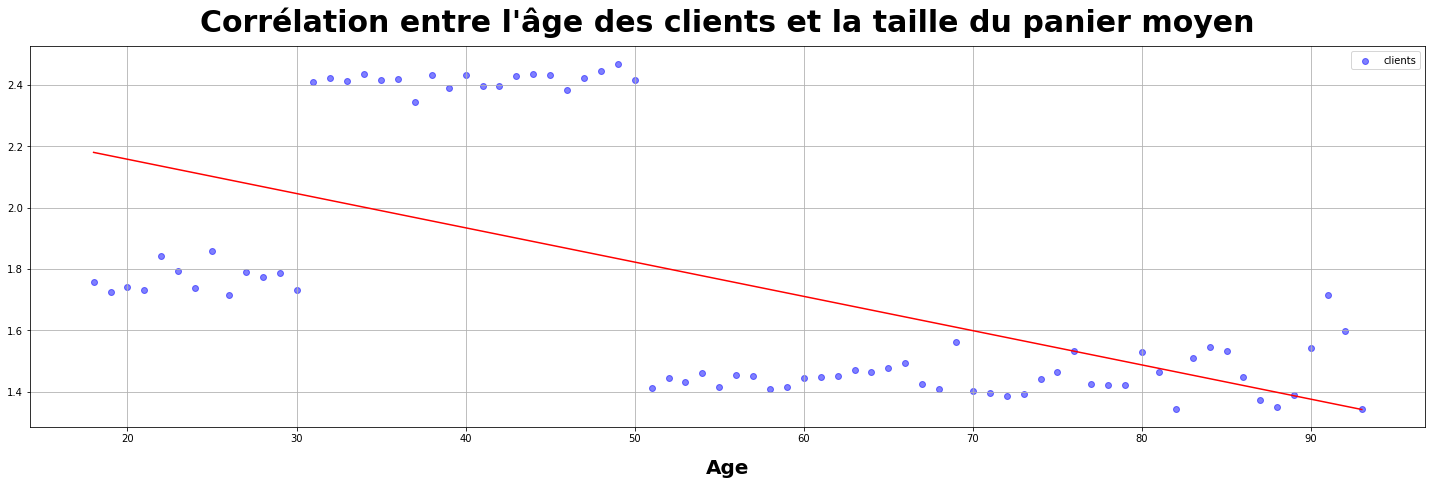

Coefficient de corrélation de Pearson: -0.17287840967597845
Sa p_value est de: 1.17787402504497e-58


In [ ]:
plt.figure(figsize=(25,7))
# Visualisation de l'évolution des achats des prix  selon l'age avec un scatter

X =  basketmean.iloc[:,0] #selection de la variable age
Y =  basketmean.iloc[:,1] #selection de la frequence f

# la pente :  de la line de prédiction
# intercept : représente le point d'intersection avec l'axe des ordonnées
# Les coefficients de notre fonction de prédiction ont déjà été calculé et valent :
pente, intercept, r_value, p_value, std_err = st.linregress(X, Y)
                                        
pente, intercept
def predict(x):
    return pente * x + intercept


axes = plt.axes()
axes.grid()
plt.scatter(X,Y,label="clients", color='b',alpha=0.5)
fitLine = predict(X)
plt.plot(X, fitLine, c='r')
plt.legend()
plt.xlabel("Age", fontsize=20, fontweight="bold", labelpad=15)
plt.title("Corrélation entre l'âge des clients et la taille du panier moyen", fontsize=30, fontweight="bold", pad=15)

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Nuage de points age clients et panier moyen.png")
plt.show()

# p_value + coefficient de corrélation de Pearson
pears(basket, "age", "basket_mean")

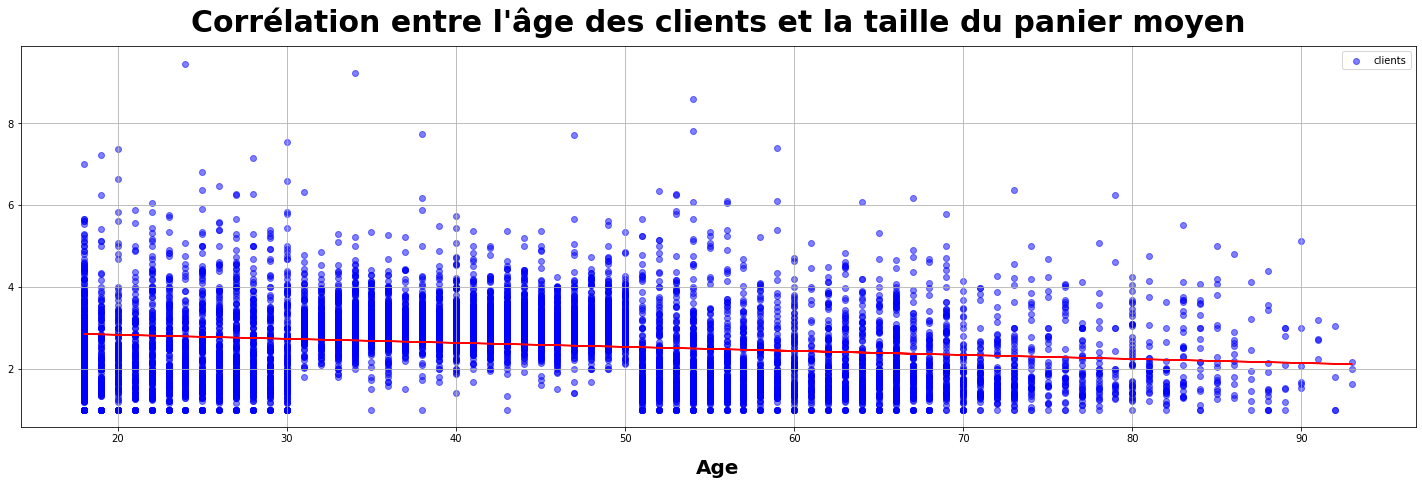

Coefficient de corrélation de Pearson: -0.17287840967597845
Sa p_value est de: 1.17787402504497e-58


In [ ]:
plt.figure(figsize=(25,7))
# Visualisation de l'évolution des achats des prix  selon l'age avec un scatter

X =  basket["age"]
Y =  basket["basket_mean"]

# la pente :  de la line de prédiction
# intercept : représente le point d'intersection avec l'axe des ordonnées
# Les coefficients de notre fonction de prédiction ont déjà été calculé et valent :
pente, intercept, r_value, p_value, std_err = st.linregress(X, Y)
                                        
pente, intercept
def predict(x):
    return pente * x + intercept


axes = plt.axes()
axes.grid()
plt.scatter(X,Y,label="clients", color='b',alpha=0.5)
fitLine = predict(X)
plt.plot(X, fitLine, c='r')
plt.legend()
plt.xlabel("Age", fontsize=20, fontweight="bold", labelpad=15)
plt.title("Corrélation entre l'âge des clients et la taille du panier moyen", fontsize=30, fontweight="bold", pad=15)

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Plot age clients et panier moyen.png")
plt.show()

# p_value + coefficient de corrélation de Pearson
pears(basket, "age", "basket_mean")

Ce nuage de points nous laisse supposer, qu'il existe une corrélation négative entre l'âge des clients et le panier moyen. À la vue de la "pente" de la droite de régression linéaire (coefficient directeur négatif) et par le calcul d'un coefficient de corrélation de Pearson proche de -0,2, on en conclue qu'il existe une corrélation négative faible entre l'âge des clients et le panier moyen. L'absence de points dans le rectangle [31; 50]x[0; 2] nous laisse penser que le panier moyen est globalement plus élevés chez les actifs. Comme pour la question 3, il ne se dégage aucune régression linéaire de ce nuage de points. C'est pourquoi nous allons encore une fois réétudier cette corrélation, cette fois-ci avec les tranches d'âges.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


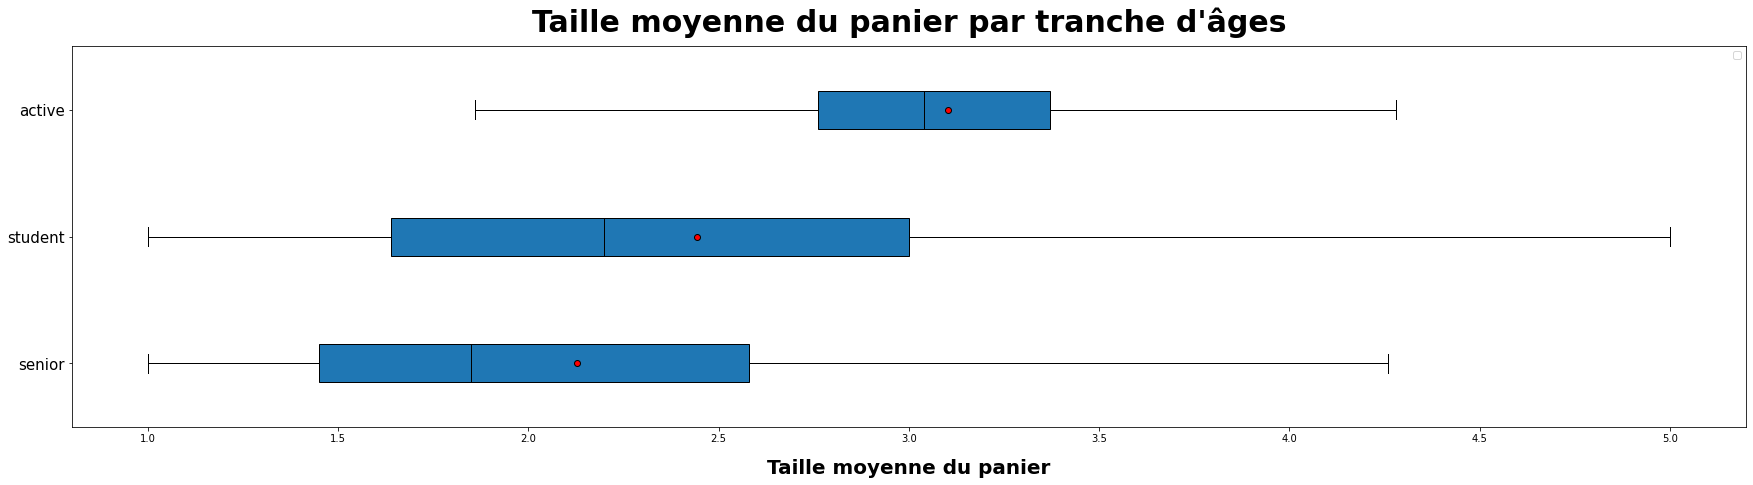

Rapport de corrélation: 19.7 %


In [ ]:
# On s'intéresse aux tranches d'âges présentes parmi les basket_mean ayant effectué des achats dans chacune de 
# nos 3 catégories de produits:

# PLOTTING
X = "client_type"       # qualitative
Y = "basket_mean" # quantitative

# On ne garde que les dépenses
subs = basket[basket["basket_mean"] > 0].copy()

modalites = subs[X].unique()
groupes = []
for m in modalites:
    groupes.append(subs[subs[X]==m][Y])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'red'}

# Boîte à moustache
plt.figure(figsize=(30,7))
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, vert=False, patch_artist=True,
            showmeans=True, meanprops=meanprops)

# Titre
plt.title("Taille moyenne du panier par tranche d'âges", fontsize=30, fontweight="bold", pad=15)

# Titre des axes
plt.xlabel("Taille moyenne du panier", fontsize=20, fontweight="bold", labelpad=15)
plt.ylabel("")

# Ticks
plt.yticks(fontsize=15)

# Légende
plt.legend()

# Sauvegarde graphique
plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Boxplot type clients et panier moyen.png")

# Affichage
plt.show()

print("Rapport de corrélation:", 100*round(eta_carre(basket["client_type"], basket["basket_mean"]), 3), "%")

Le rapport de corrélation est supérieur à 19,7%. On peut donc, à la vue des boîtes, fortement supposer une corrélation similaire à la celle de la question précédente: le panier moyen semble être plus élevés chez les personnes âgés d'entre 31 et 50 ans.

## Corrélation entre l'âge des clients et les catégories de produits achetés

In [ ]:
agecat = tpc[["categ", "age"]]
agecat_tab = pd.crosstab(agecat["age"], agecat["categ"])
agecat_tab

categ     0     1     2
age                    
18     1668  2759  2921
19      488   817   877
20      498   830   896
21      461   732   839
22      587   791   797
..      ...   ...   ...
89       71    92     1
90       73    85     1
91       36    47     1
92       43    71     1
93       35    51     0

[76 rows x 3 columns]

<Figure size 2880x504 with 0 Axes>

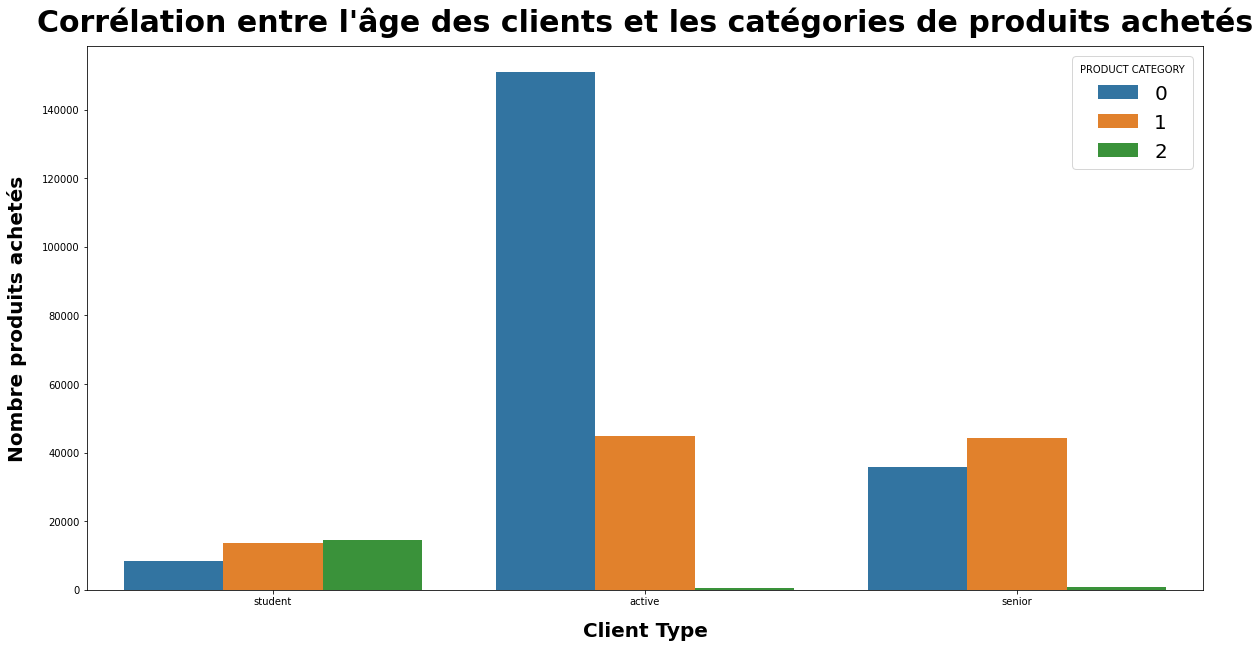

In [ ]:
# setting [client_type] column in the right order
cl_types = ["student", "active", "senior"]

tpc["client_type"] = pd.CategoricalIndex(tpc["client_type"], ordered=True, categories=cl_types)
tpc.sort_values(by=["age"])

# let's verify
tpc.groupby("client_type")[["price"]].sum()

# ANOVA : QL/QL

plt.figure(figsize=(40,7))
# Méthode .groupby() pour agréger les données selon l'âge et categ
agecat = tpc.groupby(['client_type', 'categ']).count().reset_index()
agecat = agecat[['client_type', 'session_id','categ']]
agecat.head(10)

# agecat['client_type'] = pd.cut(agecat['age'],15)
agecat = agecat.groupby(['client_type','categ']).sum().reset_index()
agecat.head(10)

# Visualisation rapide avec une BarPlot Seaborn
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x="client_type", y="session_id",hue="categ", data=agecat)

# BarPlot settings
ax.set_title("Corrélation entre l'âge des clients et les catégories de produits achetés", fontsize=30, fontweight="bold", pad=15)
ax.set_xlabel("Client Type", fontsize=20, fontweight="bold", labelpad=15)
ax.set_ylabel("Nombre produits achetés", fontsize=20, fontweight="bold", labelpad=15)
ax.legend(title="PRODUCT CATEGORY", fontsize=20)

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Barplot type clients et categorie produit acheté.png")
plt.show()

In [ ]:
X = "categ" # qualitative
Y = "age" # quantitative

subs = tpc[tpc["age"] < 0] 

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

round(eta_squared(agecat.client_type, agecat.session_id), 2)

# correlation tranche d'age et categ
# entre -1 et 1
# si coef est proche -1 = correlation negatif
# so coef est proche 1 = correlation positif
# si coef = 0 : pas de correaltion

0.26

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


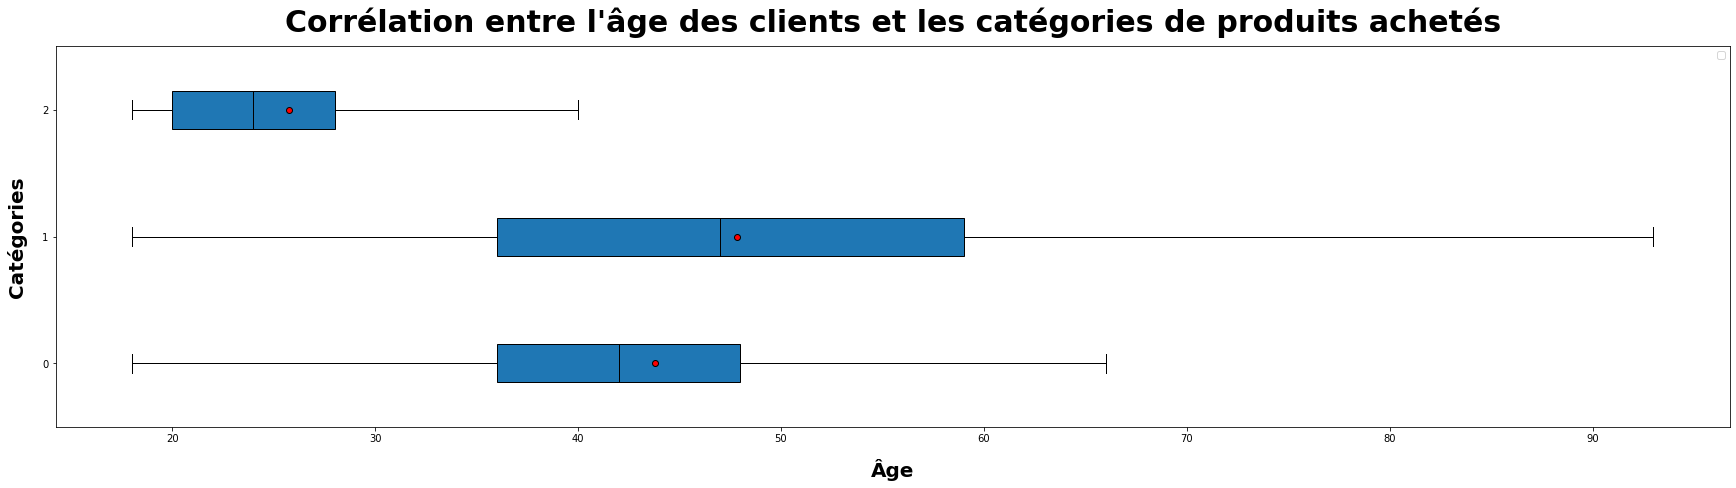

Rapport de corrélation: 11.3 %


In [ ]:
X = "categ" # qualitative
Y = "age" # quantitative

# On ne garde que les dépenses
subs = tpc[tpc["age"] > 0].copy()

modalites = subs[X].unique()
groupes = []
for m in modalites:
    groupes.append(subs[subs[X]==m][Y])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'red'}

# Boîte à moustache
plt.figure(figsize=(30,7))
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, vert=False, patch_artist=True,
            showmeans=True, meanprops=meanprops)

# Titre
plt.title("Corrélation entre l'âge des clients et les catégories de produits achetés", fontsize=30, fontweight="bold", pad=15)

# Titre des axes
plt.xlabel('Âge', fontsize=20, fontweight="bold", labelpad=15)
plt.ylabel('Catégories', fontsize=20, fontweight="bold", labelpad=15)

# Légende
plt.legend()

# Sauvegarde graphique
plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Boxplot age clients et categorie produit acheté.png")

# Affichage
plt.show()

print("Rapport de corrélation:", 100*round(eta_carre(tpc["categ"], tpc["age"]), 3), "%")

Il y a bien une corrélation entre l'âge et la catégorie, ici les jeunes clients s'orientent presque exclusivement sur la 2ème catégorie.

Avec un rapport de corrélation d'environ 10%, on peut donc sereinement qu'il y a corrélation entre l'âge des clients et les catégories de produits achetés: on remarque que la boîte à moustaches de la catégorie 2 diffère bien des deux autres, plus rapprochées. La catégorie 2 s'adresse globalement à une clientèle plus jeune, entre 18 et 25 ans, notamment, tandis que les moyennes d'âge des catégorie 0 et 1 semblent plus homogènes, et intéressent apparemment tout type de client, quelque soit l'âge.

In [ ]:
typecat = tpc[["categ", "client_type"]]
typecat_tab = pd.crosstab(typecat["client_type"], typecat["categ"])
typecat_tab

categ             0      1      2
client_type                      
student        8349  13532  14487
active       150974  44877    574
senior        35947  44216    695

In [ ]:
typecat_pct = pd.crosstab(typecat["client_type"], typecat["categ"], normalize="index")
typecat_pct

# If we want the percentages by column, then we should write normalize=’columns’
# and if we want the total percentage then we should write normalize=’all’

categ               0         1         2
client_type                              
student      0.229570  0.372085  0.398345
active       0.768609  0.228469  0.002922
senior       0.444569  0.546835  0.008595

In [ ]:
typecat.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)

# if coeff correlation = 1 : means strong correlation (straight line UP)
# if coeff correlation = -1 : means still strong correlation (straight line DOWN)
# id coeff correlation tends around 0 : means no relationship

categ  client_type
categ        1.000000     0.145328
client_type  0.145328     1.000000

In [ ]:
# categorical data to object
tpc["client_type"] = tpc.client_type.astype(str)

# tableau de contingence reel
c = tpc[["categ", "client_type"]].pivot_table(index="categ", columns="client_type", aggfunc=len)
cont =  c.copy()

tx = tpc["categ"].value_counts()
ty = tpc["client_type"].value_counts()

cont.loc[:, "Total"], cont.loc["total", :] = tx, ty
cont.loc["total", "Total"] = len(tpc) ; cont

client_type    active   senior  student     Total
categ                                            
0            150974.0  35947.0   8349.0  195270.0
1             44877.0  44216.0  13532.0  102625.0
2               574.0    695.0  14487.0   15756.0
total        196425.0  80858.0  36368.0  313651.0

In [ ]:
# tableau de contingence theorique
tx, ty = pd.DataFrame({"foo": tx}) , pd.DataFrame({"foo": ty})
indep = tx.dot(ty.T)/len(tpc) ; indep

active        senior       student
0  122288.498203  50339.841607  22641.660189
1   64269.253486  26456.323270  11899.423244
2    9867.248311   4061.835122   1826.916567

In [ ]:
# Chi-2, le degré de liberté, p_value
mesure = (c-indep)**2/indep

xi_n = mesure.sum().sum()
ddl = (len(c)-1)*(len(c.columns)-1)
pvalue = st.chi2_contingency(c)[1]

pd.DataFrame({"": [str(ddl), round(pvalue, 20), xi_n]}, index=["Dégré de liberté", "pvalue", "Chi-2"])

Dégré de liberté       4
pvalue                 0
Chi-2             137138

In [ ]:
# Chi-square test of independence
c, p, dof, expected = chi2_contingency(typecat_tab)

# Print the p-value
print(f"p-value of correlation between age class and category is {p}")

stat, p, dof, expected = chi2_contingency(typecat_tab)

# interpret p-value
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

p-value of correlation between age class and category is 0.0
Dependent (reject H0)


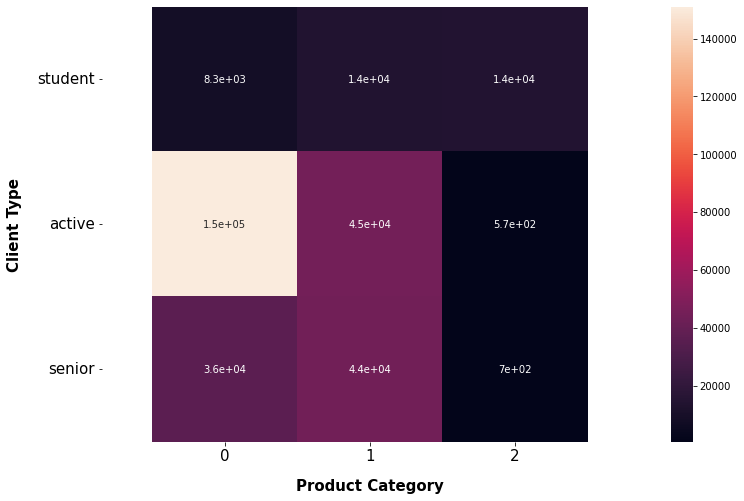

In [ ]:
plt.figure(figsize=(12,8)) 
sns.heatmap(typecat_tab, annot=True)

plt.xlabel("Product Category", fontsize=15, fontweight="bold", labelpad=15)
plt.ylabel("Client Type", fontsize=15, fontweight="bold", labelpad=15)
plt.xticks(rotation=0, fontsize=15)
plt.yticks(rotation=0, fontsize=15)
plt.axis("equal")


plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Table contingence type clients et categorie produit acheté pt1.png")
plt.show()

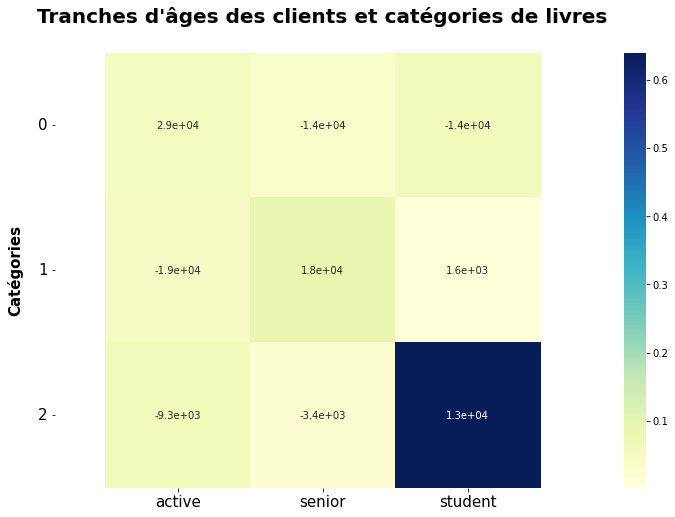

pvalue: 0.0
Chi-2: 137137.97556981342


In [ ]:
c = tpc[["categ", "client_type"]].pivot_table(index="categ", columns="client_type", aggfunc=len) ; cont =  c.copy()

tx, ty = tpc["categ"].value_counts(), tpc["client_type"].value_counts()
cont.loc[:, "Total"], cont.loc["total", :] = tx, ty
cont.loc["total", "Total"] = len(tpc) ; cont
tx, ty = pd.DataFrame({"foo": tx}) , pd.DataFrame({"foo": ty})
indep=tx.dot(ty.T)/len(tpc) ; indep

mesure = (c-indep)**2/indep
xi_n = mesure.sum().sum()
ddl = (len(c)-1)*(len(c.columns)-1)
pvalue = st.chi2_contingency(c)[1]

plt.figure(figsize=(12,8))

sns.heatmap(mesure/xi_n, annot=c-indep, cmap="YlGnBu")
plt.title("Tranches d'âges des clients et catégories de livres", fontsize=20, fontweight="bold", pad=30)
plt.xlabel("")
plt.ylabel("Catégories", fontsize=15, fontweight="bold", labelpad=15)
plt.xticks(rotation=0, fontsize=15)
plt.yticks(rotation=0, fontsize=15)
plt.axis("equal")

plt.savefig("/content/drive/MyDrive/OC/P4/P4_official_files/P4_graphiques/Table contingence type clients et categorie produit acheté.png")
plt.show()

print("pvalue:", pvalue)
print("Chi-2:", xi_n)

On observe finalement bien la corrélation supposée précédemment: Avec un pvalue nulle et un Chi-2 de 100 mille d'ordre de grandeur, on peut affirmer sans crainte que les étudiants s'intéressent beaucoup plus à la catégorie 2 que les actifs et les seniors. Pour les catégories 0 et 1, l'âge du client importe peu: tous semblent semblent porter à peu près le même degré d'intérêt pour chacune de ces deux catégories, qu'ils soient étudiants, actifs ou seniors.